# Análise das medidas do cálculo coerência do conjunto de dados CohQuAD CoIn en .

Realiza a análise dos cálculos de medida de coerência utilizando BERT.

Utiliza os arquivos resultantes da medição de `X` documentos perturbados e `Y` top K predições.

----------------------------

**Link biblioteca Transformers:**
https://github.com/huggingface/transformers

**Artigo original BERT:**
https://arxiv.org/pdf/1506.06724.pdf

**Artigo padding dinâmico:**
https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e

# 1 Preparação do ambiente
Preparação do ambiente para execução do exemplo.

## 1.1 Tempo inicial de processamento

In [1]:
# Import das bibliotecas
import time
import datetime

#marca o tempo de início do processamento.
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [2]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [3]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [4]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [5]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [6]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [7]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [8]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempo_arredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempo_arredondado))    

Classe(ModeloArgumentosMedida) de definição dos parâmetros do modelo para medida

In [9]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={'help': 'max seq len'},
    )    
    pretrained_model_name_or_path: str = field(
        default='neuralmind/bert-base-portuguese-cased',
        metadata={'help': 'nome do modelo pré-treinado do BERT.'},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={'help': 'define se o texto do modelo deve ser todo em minúsculo.'},
    )  
    output_attentions: bool = field(
        default=False,
        metadata={'help': 'habilita se o modelo retorna os pesos de atenção.'},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={'help': 'habilita gerar as camadas ocultas do modelo.'},
    )
    use_wandb : bool = field(
        default=True,
        metadata={'help': 'habilita o uso do wandb.'},
    )
    salvar_avaliacao : bool = field(
        default=True,
        metadata={'help': 'habilita o salvamento do resultado da avaliação.'},
    )     
    salvar_medicao : bool = field(
        default=False,
        metadata={'help': 'habilita o salvamento da medicao.'},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={'help': 'habilita o carragamento de mcl ajustado.'},
    )
    estrategia_medida_medida: int = field(
        default=0, # 0 - MEAN estratégia média / 1 - MAX  estratégia maior
        metadata={'help': 'Estratégia de cálculo da médida dos embeddings.'},
    )
    filtro_palavra: int = field(
        default=0, # 0 - Considera todas as palavras das sentenças / 1 - Desconsidera as stopwords / 2 - Considera somente as palavras substantivas
        metadata={'help': 'Define o filtro de palavras das sentenças para gerar os embeddings.'},
    )

Biblioteca de limpeza de tela


In [10]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [11]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4  Identificando o ambiente Colab

In [12]:
# Se estiver executando no Google Colaboratory.
import sys

# Retorna true ou false se estiver no Google Colaboratory.
IN_COLAB = 'google.colab' in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [13]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [14]:
# Import das bibliotecas.
import torch

def getDeviceGPU():
    """
      Retorna um dispositivo de GPU se disponível ou CPU.
    
      Retorno:
        `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [15]:
# Recupera o device com GPU ou CPU
device = getDeviceGPU()

INFO:root:Sem GPU disponível, usando CPU.


Memória

Memória disponível no ambiente

In [16]:
# Importando as bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

INFO:root:Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

INFO:root:Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
INFO:root:e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [17]:
# import necessário
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")

Mounted at /content/drive


# 2 Parametrização

## Gerais

In [18]:
# Nome base das saidas do projeto
NOME_BASE_SAIDA = "MedidaCohQuADCoInen_v1"

# Definição dos parâmetros a serem avaliados

## Específicos

Parâmetros do modelo

## Nome do diretório dos arquivos de dados

In [19]:
# Diretório do cohebert
DIRETORIO_COHEBERT = "COHQUAD_COIN_EN"

## Define o caminho para os arquivos de dados

In [20]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

# 3 Resultado do Cálculo das Medidas de (In)coerência

In [21]:
CONJUNTO_DADOS = 'Cohebert Auto en'

## 3.1 Carrega os dados das medidas 

### 3.1.1 Função que encontra a melhor mensuração

In [22]:
# Import das bibliotecas.
import os
import pandas as pd

def getResultadosMensuracao(DIRETORIO_COHEBERT, 
                            DOCUMENTOS_PERTURBADOS, 
                            TOP_K_PREDICAO):
  
  # Quantidade de documentos a serem perturbados a partir do original.    
  DOCUMENTOS_PERTURBADOS = DOCUMENTOS_PERTURBADOS

  # Quantidade de palavras a serem recuperadas mais próximas da máscara. 
  TOP_K_PREDICAO = TOP_K_PREDICAO

  # MCL a serem avaliados
  # MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
  MODELO_BERT = ['_BERT', '_BERTmultilingual']
  
  TAMANHO_BERT = ['_base','_large']
  
  MODELO = ['_pretreinado', '_ajustado'] 

  EQUACAO_MEDIDA_NUM = [0, 1, 2]
  EQUACAO_MEDIDA = ["_adj","_com","_ctx"]

  ESTRATEGIA_MEDIDA_NUM = [0, 1]  
  ESTRATEGIA_MEDIDA = ['_mean', '_max']
    
  #["TODAS_AS_PALAVRAS", "SEM_STOPWORDS", "SOMENTE_VERBOS_SUBSTANTIVOS"]
  FILTRO_PALAVRAS_NUM = [0, 1, 2]
  FILTRO_PALAVRAS = ['_tap','_ssw', '_svs'] 
  
  # Diretório para salvar o arquivo.
  DIRETORIO_AVALIACAO = "/content/drive/My Drive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Avaliacao/"  

  MELHOR_MODELO_BERT = ""
  MELHOR_TAMANHO_BERT = ""
  MELHOR_MODELO = ""
  MELHOR_DOCUMENTOS_PERTURBADOS = 0
  MELHOR_TOP_K_PREDICAO = 0
  MELHOR_EQUACAO_MEDIDA = 0  
  MELHOR_ESTRATEGIA_MEDIDA = 0
  MELHOR_FILTRO_PALAVRAS = 0  
  MELHOR_MEDIDA_GERAL = 0  
  MELHOR_MEDIDA_GERAL_STR = ""  
  MELHOR_RESULTADO = -1
  MELHOR_TEMPO = 0

  lista_resultados = []
    
  # Verifica se o diretório dos resultados existe.
  if os.path.exists(DIRETORIO_AVALIACAO):    
    arquivos = os.listdir(DIRETORIO_AVALIACAO) 
    for modelo_bert in MODELO_BERT:
      for tamanho in TAMANHO_BERT:        
        if modelo_bert != '_BERTmultilingual' or tamanho != '_large':  
          for modelo in MODELO:        
            for documentos_perturbados in DOCUMENTOS_PERTURBADOS:
              for top_k_predicao in TOP_K_PREDICAO:
                for equacao_medida in EQUACAO_MEDIDA:                      
                    for estrategia_medida in ESTRATEGIA_MEDIDA:  
                      for filtro_palavra in FILTRO_PALAVRAS:  
                        # Acumuladores.                        
                        for i in range(len(arquivos)):                                    
                          if ((("_P_" + str(documentos_perturbados)+"_") in arquivos[i]) 
                              and (("_K_" + str(top_k_predicao)+"_") in arquivos[i])                                 
                              and (modelo_bert in arquivos[i]) 
                              and (tamanho in arquivos[i]) 
                              and (modelo in arquivos[i])
                              and (equacao_medida in arquivos[i])  
                              and (estrategia_medida in arquivos[i]) 
                              and (filtro_palavra in arquivos[i])):
                                
                            NOME_ARQUIVO_AVALIACAO_COMPLETO = DIRETORIO_AVALIACAO + arquivos[i]                              
                            # Verifica se o arquivo existe.
                            if os.path.isfile(NOME_ARQUIVO_AVALIACAO_COMPLETO):
                              # Carrega os dados do arquivo  
                              dados = pd.read_csv(NOME_ARQUIVO_AVALIACAO_COMPLETO, sep=';')
                          
                              # Mostra os dados do teste da medida.
                              for index, linha in dados.iterrows():        
                                  # Cálculo das estatísticas
                                  ccos = (linha['ccos'])
                                  cman = (linha['cman'])
                                  ceuc = (linha['ceuc'])
                                  
                                  MELHOR_MEDIDA = -1
                                  MELHOR_MEDIDA_STR = ""
                                  if ccos >= cman and ccos >= ceuc:
                                      MELHOR_MEDIDA_STR = 'ccos'
                                      MELHOR_MEDIDA = ccos
                                  else:
                                      if ceuc >= ccos and ceuc >= cman:
                                          MELHOR_MEDIDA_STR = 'ceuc'
                                          MELHOR_MEDIDA = ceuc
                                      else:
                                          if cman >= ccos and cman >= ceuc:
                                            MELHOR_MEDIDA_STR = 'cman'
                                            MELHOR_MEDIDA = cman
                                  
                                  if MELHOR_MEDIDA > MELHOR_RESULTADO:
                                    MELHOR_DOCUMENTOS_PERTURBADOS = documentos_perturbados
                                    MELHOR_TOP_K_PREDICAO = top_k_predicao
                                    MELHOR_EQUACAO_MEDIDA = equacao_medida
                                    MELHOR_ESTRATEGIA_MEDIDA = estrategia_medida
                                    MELHOR_FILTRO_PALAVRAS = filtro_palavra
                                    MELHOR_RESULTADO = MELHOR_MEDIDA                                
                                    MELHOR_TEMPO = linha['tempo']
                                    MELHOR_MEDIDA_GERAL = MELHOR_MEDIDA
                                    MELHOR_MEDIDA_GERAL_STR = MELHOR_MEDIDA_STR 
                                    MELHOR_MODELO_BERT = modelo_bert
                                    MELHOR_TAMANHO_BERT = tamanho
                                    MELHOR_MODELO = modelo

                                  lista_resultados.append([MELHOR_MODELO_BERT,
                                                          MELHOR_TAMANHO_BERT,
                                                          MELHOR_MODELO,
                                                          documentos_perturbados,
                                                          top_k_predicao, 
                                                          equacao_medida,
                                                          estrategia_medida, 
                                                          filtro_palavra, 
                                                          ccos, 
                                                          ceuc, 
                                                          cman,
                                                          MELHOR_MEDIDA_STR,
                                                          MELHOR_MEDIDA,                                                        
                                                          linha['tempo']])
    
    # Retorno do melhor valor
    if MELHOR_MEDIDA_GERAL_STR == "ccos":
      lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[8], reverse=True)  
    else:
      if MELHOR_MEDIDA_GERAL_STR == "ceuc":
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[9], reverse=True)
      else:
        lista_resultado_ordenado = sorted(lista_resultados, key=lambda x: x[10], reverse=True)

    return MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultado_ordenado
  else:
      print('Diretório com os resultados não encontrado')

In [23]:
# Parametros para o Cohebert Manual
DOCUMENTOS_PERTURBADOS = [1, 20, 100]
TOP_K_PREDICAO = [1, 20, 100]

# Recupera os melhores parâmetros
MELHOR_MODELO_BERT, MELHOR_TAMANHO_BERT, MELHOR_MODELO, MELHOR_DOCUMENTOS_PERTURBADOS, MELHOR_TOP_K_PREDICAO, MELHOR_EQUACAO_MEDIDA, MELHOR_ESTRATEGIA_MEDIDA, MELHOR_FILTRO_PALAVRAS, MELHOR_RESULTADO, MELHOR_TEMPO, MELHOR_MEDIDA_GERAL, MELHOR_MEDIDA_GERAL_STR, lista_resultados = getResultadosMensuracao(DIRETORIO_COHEBERT, DOCUMENTOS_PERTURBADOS, TOP_K_PREDICAO)

In [24]:
print("Parâmetros do melhor resultado do mensurador")
print("\n  Modelo BERT           :", MELHOR_MODELO_BERT, 
      "\n  Tamanho BERT          :", MELHOR_TAMANHO_BERT, 
      "\n  Modelo                :", MELHOR_MODELO,     
      "\n  Documentos Perturbados:", MELHOR_DOCUMENTOS_PERTURBADOS, 
      "\n  Top k predição        :", MELHOR_TOP_K_PREDICAO, 
      "\n  Equação               :", MELHOR_EQUACAO_MEDIDA,
      "\n  Estratégia            :", MELHOR_ESTRATEGIA_MEDIDA, 
      "\n  Filtro                :", MELHOR_FILTRO_PALAVRAS, 
      "\n  Resultado             :", MELHOR_RESULTADO, 
      "\n  Medida                :", MELHOR_MEDIDA_GERAL_STR,       
      "\n  Tempo execução        :", MELHOR_TEMPO)

print("\nLista dos resultados ranqueados")
for i, linha in enumerate(lista_resultados):
    print((i+1),"=", linha)

Parâmetros do melhor resultado do mensurador

  Modelo BERT           : _BERT 
  Tamanho BERT          : _large 
  Modelo                : _pretreinado 
  Documentos Perturbados: 1 
  Top k predição        : 1 
  Equação               : _com 
  Estratégia            : _mean 
  Filtro                : _svs 
  Resultado             : 0.65 
  Medida                : cman 
  Tempo execução        : 0:00:07

Lista dos resultados ranqueados
1 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_svs', 0.425, 0.525, 0.65, 'cman', 0.65, '0:00:07']
2 = ['_BERT', '_large', '_pretreinado', 1, 1, '_adj', '_mean', '_svs', 0.45, 0.475, 0.55, 'cman', 0.55, '0:00:05']
3 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_max', '_svs', 0.425, 0.5, 0.55, 'cman', 0.55, '0:00:07']
4 = ['_BERT', '_large', '_pretreinado', 1, 1, '_adj', '_max', '_svs', 0.425, 0.45, 0.5, 'cman', 0.5, '0:00:06']
5 = ['_BERT', '_large', '_pretreinado', 1, 1, '_com', '_mean', '_tap', 0.4, 0.525, 0.5, 'ceuc', 0.525, '0

### Escolhendo um resultado diferente do melhor

In [25]:
# Carrega somente as melhores medidas para Np = 20
MELHOR_DOCUMENTOS_PERTURBADOS = 20
MELHOR_TOP_K_PREDICAO = 20

# Parametros para melhor de 100
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 100
# MELHOR_TOP_K_PREDICAO = 100
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.4705
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:29'
# lista_resultados = []

# Parametros para melhor de 20
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 20
# MELHOR_TOP_K_PREDICAO = 20
# MELHOR_EQUACAO_MEDIDA = '_ctx'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_com'
# MELHOR_RESULTADO = 0.4925
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:10'
# lista_resultados = []

# Parametros para melhor de 1
# MELHOR_MODELO_BERT = '_BERT'
# MELHOR_TAMANHO_BERT = '_large'
# MELHOR_MODELO = '_pretreinado'
# MELHOR_DOCUMENTOS_PERTURBADOS = 1
# MELHOR_TOP_K_PREDICAO = 1
# MELHOR_EQUACAO_MEDIDA = '_com'
# MELHOR_ESTRATEGIA_MEDIDA = '_mean'
# MELHOR_FILTRO_PALAVRAS = '_svs'
# MELHOR_RESULTADO = 0.65
# MELHOR_MEDIDA_GERAL_STR = 'cman'
# MELHOR_TEMPO = '0:00:07'
# lista_resultados = []

### 3.1.2 Função que carrega os parâmetros do resultado da melhor mensuração

In [26]:
def carregaMedidasCompactada(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO

  # Diretório do drive do arquivo
  DIRETORIO_MEDICAO_DRIVE = DIRETORIO_DRIVE + "validacao_medicao_palavra/Medicao/"

  # Diretório local para salvar o arquivo
  DIRETORIO_MEDICAO_LOCAL = DIRETORIO_LOCAL + "Medicao/"

  # Verifica se o diretório existe
  if not os.path.exists(DIRETORIO_MEDICAO_LOCAL):  
    # Cria o diretório
    os.makedirs(DIRETORIO_MEDICAO_LOCAL)
    logging.info("Diretório criado: {}.".format(DIRETORIO_MEDICAO_LOCAL))
  else:
    logging.info("Diretório já existe: {}.".format(DIRETORIO_MEDICAO_LOCAL))

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO_DRIVE):        

    # Caminho completo do arquivo compactado no drive
    NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO = DIRETORIO_MEDICAO_DRIVE + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO:", NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO)

    # Caminho completo do arquivo compactado no local
    NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".zip"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO:", NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO)

    # Caminho completo do arquivo no local
    NOME_ARQUIVO_MEDICAO_LOCAL = DIRETORIO_MEDICAO_LOCAL + NOME_ARQUIVO_MEDICAO + ".csv"
    # print("NOME_ARQUIVO_MEDICAO_LOCAL:", NOME_ARQUIVO_MEDICAO_LOCAL)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO):
      
      # Copia arquivo da medição compactado do google drive para o drive local
      !cp "$NOME_ARQUIVO_MEDICAO_DRIVE_COMPACTADO" "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO"  
                        
      # Descompacta arquivo da medição compactado no drive local
      !unzip -o -j -q "$NOME_ARQUIVO_MEDICAO_LOCAL_COMPACTADO" -d "$DIRETORIO_MEDICAO_LOCAL"

      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_LOCAL, sep=';')

      #print('Registros: ', len(dados_medida))
      print('Arquivo encontrado e carregado')        

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

In [27]:
def carregaMedidas1(MODELO_BERT, 
                   TAMANHO_BERT, 
                   MODELO, 
                   DOCUMENTOS_PERTURBADOS, 
                   TOP_K_PREDICOES,
                   EQUACAO_MEDIDA, 
                   ESTRATEGIA_MEDIDA, 
                   FILTRO_PALAVRAS):
  # Import das bibliotecas.
  import os
  import pandas as pd

  # Nome arquivo a ser aberto
  NOME_ARQUIVO_MEDICAO = NOME_BASE_SAIDA + "_P_" + str(DOCUMENTOS_PERTURBADOS) + "_K_" + str(TOP_K_PREDICOES) + EQUACAO_MEDIDA + ESTRATEGIA_MEDIDA + FILTRO_PALAVRAS + MODELO_BERT + TAMANHO_BERT + MODELO + ".csv"

  # Diretório para salvar o arquivo.
  DIRETORIO_MEDICAO = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/validacao_medicao_palavra/Medicao/"
  # print("DIRETORIO_MEDICAO:", DIRETORIO_MEDICAO)

  # Verifica se o diretório dos resultados existem.
  if os.path.exists(DIRETORIO_MEDICAO):    

    # Caminho completo do arquivo
    NOME_ARQUIVO_MEDICAO_COMPLETO = DIRETORIO_MEDICAO + NOME_ARQUIVO_MEDICAO
    # print("NOME_ARQUIVO_MEDICAO_COMPLETO:", NOME_ARQUIVO_MEDICAO_COMPLETO)

    # Verifica se o arquivo existe.
    if os.path.isfile(NOME_ARQUIVO_MEDICAO_COMPLETO):
      # Carrega os dados do arquivo  
      dados_medida = pd.read_csv(NOME_ARQUIVO_MEDICAO_COMPLETO, sep=';')

      print('Registros: ', len(dados_medida))

      return dados_medida
      
    else:
      print('Arquivo com as medições não encontrado')        

  else:
    print('Diretório com as medições não encontrado')
  
  return None

## 3.2 Carregamento dos arquivos de dados originais e perturbados

### 3.2.1 Especifica os nomes dos arquivos de dados



In [28]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(MELHOR_DOCUMENTOS_PERTURBADOS) + "_k" + str(MELHOR_TOP_K_PREDICAO) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [29]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Perturbados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

INFO:root:Diretório criado: /content/COHQUAD_COIN_EN


### 3.2.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [30]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

INFO:root:Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [31]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

INFO:root:Terminei a descompactação!


### 3.2.4 Carregamento das lista com os dados dos arquivos originais e perturbados

#### Carrega o arquivo dos dados originais e POS

In [32]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

INFO:root:TERMINADO ORIGINAIS: 40.
INFO:root:TERMINADO ORIGINAIS POS: 40.


In [33]:
lista_documentos_originais.sample(5)

id                                          sentencas  \
6      4       ['How to push and pop elements in a stack?']   
20    11  ['What is a queue and how to dequeue an elemen...   
37  19p0  ['In a stack does the enqueue operation occur ...   
25  13p0  ['What is a stack and how to enqueue an elemen...   
1    1p0            ['How to dequeue elements in a stack?']   

                                            documento  
6            How to push and pop elements in a stack?  
20  What is a queue and how to dequeue an element ...  
37  In a stack does the enqueue operation occur at...  
25  What is a stack and how to enqueue an element ...  
1                 How to dequeue elements in a stack?

In [34]:
lista_documentos_originais_pos.sample(5)

id                                      pos_documento
9   5p0  [[['How', 'to', 'push', 'elements', 'in', 'a',...
24   13  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
12    7  [[['How', 'to', 'pop', 'elements', 'from', 'a'...
18   10  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
5   3p0  [[['How', 'to', 'push', 'elements', 'in', 'a',...

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [35]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_originais = lista_documentos_originais.astype(tipos)
  lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
  logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

  return lista_documentos_originais, lista_documentos_originais_pos

In [36]:
lista_documentos_originais, lista_documentos_originais_pos = corrigirTipoDadosColunasOriginais(lista_documentos_originais, lista_documentos_originais_pos)

INFO:root:TERMINADO CORREÇÃO ORIGINAIS: 40.
INFO:root:TERMINADO CORREÇÃO ORIGINAIS POS: 40.


#### Criando dados indexados originais

In [37]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_indexado = lista_documentos_originais.set_index(["id"])
lista_documentos_originais_indexado.head()

sentencas  \
id                                           
1    [How to enqueue elements in a queue?]   
1p0  [How to dequeue elements in a stack?]   
2    [How to dequeue elements in a queue?]   
2p0  [How to dequeue elements in a stack?]   
3       [How to push elements in a stack?]   

                               documento  
id                                        
1    How to enqueue elements in a queue?  
1p0  How to dequeue elements in a stack?  
2    How to dequeue elements in a queue?  
2p0  How to dequeue elements in a stack?  
3       How to push elements in a stack?

In [38]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.set_index(["id"])
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                    
1    [[[How, to, enqueue, elements, in, a, queue, ?...
1p0  [[[How, to, dequeue, elements, in, a, stack, ?...
2    [[[How, to, dequeue, elements, in, a, queue, ?...
2p0  [[[How, to, dequeue, elements, in, a, stack, ?...
3    [[[How, to, push, elements, in, a, stack, ?], ...

#### Carrega o arquivo dos dados perturbados e POS

In [39]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

INFO:root:TERMINADO PERTURBADOS: 800.
INFO:root:TERMINADO PERTURBADOS POS: 800.


Alguns csv estão com os nomes das colunas errados

In [40]:
lista_documentos_perturbados = lista_documentos_perturbados.rename(columns={'documentoPerturbado': 'documento_perturbado'})

In [41]:
lista_documentos_perturbados.sample(5)

id                                         perturbado  \
730   19_pert_10  ['In a stack does the pop operation ask at whi...   
523    14_pert_3  ['What is a stack and how to define an element...   
277  7p0_pert_17            ['How to sort elements from a queue ?']   
406    11_pert_6  ['What is a queue and how to store an element ...   
726    19_pert_6  ['In a stack does the pop operation indicate a...   

                                  documento_perturbado  \
730  In a stack does the pop operation ask at which...   
523  What is a stack and how to define an element o...   
277                How to sort elements from a queue ?   
406  What is a queue and how to store an element in...   
726  In a stack does the pop operation indicate at ...   

                                             sentencas  
730  [['In a stack does the pop operation [MASK] at...  
523  [['What is a stack and how to [MASK] an elemen...  
277  [['How to [MASK] elements from a queue ?', 'po...  
406  [['What is a queue and how to [MASK] an elemen...  
726  [['In a stack does the pop operation [MASK] at...

In [42]:
lista_documentos_perturbados_pos.sample(5)

id                                      pos_documento
590  15p0_pert_10  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
671  17p0_pert_11  [[['How', 'are', 'the', 'operations', 'to', 'p...
403     11_pert_3  [[['What', 'is', 'a', 'queue', 'and', 'how', '...
642     17_pert_2  [[['How', 'are', 'the', 'operations', 'to', 'd...
253     7_pert_13  [[['How', 'to', 'eliminate', 'elements', 'from...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [43]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

def corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos):

  # Corrige os tipos dos dados 
  tipos = {"id": str}
  lista_documentos_perturbados = lista_documentos_perturbados.astype(tipos)
  lista_documentos_perturbados_pos = lista_documentos_perturbados_pos.astype(tipos)

  # Verifica se o tipo da coluna não é list e converte
  lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
  lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

  logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
  logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

  return lista_documentos_perturbados, lista_documentos_perturbados_pos

In [44]:
 lista_documentos_perturbados, lista_documentos_perturbados_pos = corrigirTipoDadosColunasPerturbados(lista_documentos_perturbados, lista_documentos_perturbados_pos)

INFO:root:TERMINADO CORREÇÃO PERTURBADO: 800.
INFO:root:TERMINADO CORREÇÃO PERTURBADO POS: 800.


#### Criando dados indexados perturbados

In [45]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.set_index(["id"])
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                  
1_pert_0     [How to place elements in a queue ?]   
1_pert_1   [How to arrange elements in a queue ?]   
1_pert_2  [How to organize elements in a queue ?]   
1_pert_3    [How to manage elements in a queue ?]   
1_pert_4       [How to put elements in a queue ?]   

                           documento_perturbado  \
id                                                
1_pert_0     How to place elements in a queue ?   
1_pert_1   How to arrange elements in a queue ?   
1_pert_2  How to organize elements in a queue ?   
1_pert_3    How to manage elements in a queue ?   
1_pert_4       How to put elements in a queue ?   

                                                  sentencas  
id                                                           
1_pert_0  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_1  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_2  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_3  [[How to [MASK] elements in a queue ?, enqueue...  
1_pert_4  [[How to [MASK] elements in a queue ?, enqueue...

In [46]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.set_index(["id"])
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                         
1_pert_0  [[[How, to, place, elements, in, a, queue, ?],...
1_pert_1  [[[How, to, arrange, elements, in, a, queue, ?...
1_pert_2  [[[How, to, organize, elements, in, a, queue, ...
1_pert_3  [[[How, to, manage, elements, in, a, queue, ?]...
1_pert_4  [[[How, to, put, elements, in, a, queue, ?], [...

### 3.2.5 Agrupar os dados originais e perturbados

In [47]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado):

  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])
    
      # Percorre os documentos perturbados apartir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado 
        #documento_perturbado = lista_documentos_perturbados.loc[lista_documentos_perturbados['id']==id_perturbado].values[0]
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
            
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [48]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados_indexado)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])

# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 40 documentos originais


Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

INFO:root:TERMINADO AGRUPAMENTO: 840.


In [49]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

INFO:root:TERMINADO AGRUPAMENTO: 840.


In [50]:
lista_documentos_agrupados.sample(5)

id                                          sentencas  \
538  13p0_pert_12  [What is a stack and how to describe an elemen...   
738   18p0_pert_2  [How are the operations to load and dequeue el...   
376   9p0_pert_18  [What is a queue and how to describe its eleme...   
11      1_pert_10               [How to order elements in a queue ?]   
676     17_pert_3  [How are the operations to pull and pop elemen...   

                                             documento  classe  
538  What is a stack and how to describe an element...       0  
738  How are the operations to load and dequeue ele...       0  
376  What is a queue and how to describe its element ?       0  
11                  How to order elements in a queue ?       0  
676  How are the operations to pull and pop element...       0

In [51]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

INFO:root:TERMINADO AGRUPAMENTO POS: 840.


#### Criar dados indexados

In [52]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_indexado = lista_documentos_agrupados.set_index(["id"])
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                  
1           [How to enqueue elements in a queue?]   
1_pert_0     [How to place elements in a queue ?]   
1_pert_1   [How to arrange elements in a queue ?]   
1_pert_2  [How to organize elements in a queue ?]   
1_pert_3    [How to manage elements in a queue ?]   

                                      documento  classe  
id                                                       
1           How to enqueue elements in a queue?       1  
1_pert_0     How to place elements in a queue ?       0  
1_pert_1   How to arrange elements in a queue ?       0  
1_pert_2  How to organize elements in a queue ?       0  
1_pert_3    How to manage elements in a queue ?       0

In [53]:
# Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.set_index(["id"])
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                    
1    [[[How, to, enqueue, elements, in, a, queue, ?...
1p0  [[[How, to, dequeue, elements, in, a, stack, ?...
2    [[[How, to, dequeue, elements, in, a, queue, ?...
2p0  [[[How, to, dequeue, elements, in, a, stack, ?...
3    [[[How, to, push, elements, in, a, stack, ?], ...

## 3.3 Carregando o resultado da melhor mensuração

In [54]:
# MODELO_BERT = [MELHOR_MODELO_BERT]
# TAMANHO_BERT = [MELHOR_TAMANHO_BERT]
# MODELO = [MELHOR_MODELO] 
# DOCUMENTOS_PERTURBADOS = [MELHOR_DOCUMENTOS_PERTURBADOS]
# TOP_K_PREDICAO = [MELHOR_TOP_K_PREDICAO]
# EQUACAO_MEDIDA = [MELHOR_EQUACAO_MEDIDA]
# ESTRATEGIA_MEDIDA = [MELHOR_ESTRATEGIA_MEDIDA]
# FILTRO_PALAVRAS = [MELHOR_FILTRO_PALAVRAS]  

# dados_mensuracao = carregaMedidasCompacta(MELHOR_MODELO_BERT, 
#                                  MELHOR_TAMANHO_BERT,
#                                  MELHOR_MODELO,
#                                  MELHOR_DOCUMENTOS_PERTURBADOS, 
#                                  MELHOR_TOP_K_PREDICAO,
#                                  MELHOR_EQUACAO_MEDIDA,
#                                  MELHOR_ESTRATEGIA_MEDIDA,
#                                  MELHOR_FILTRO_PALAVRAS)

### Carrega as melhores de cada equação(CAW, CWP,CG) para Np = 20

In [55]:
# MODELO_BERT = ['_BERTimbau', '_BERTmultilingual']
MODELO_BERT = ['_BERT', '_BERTmultilingual']
TAMANHO_BERT = ['_base','_large']
MODELO = ['_pretreinado', '_ajustado'] 
DOCUMENTOS_PERTURBADOS = [1,20,100]
TOP_K_PREDICAO = [1,20,100]
EQUACAO_MEDIDA = ['_adj','_com','_ctx'] # ['CAW - palavras adjacentes','CWP - combinação de todas as palavras','CG - contexto global']
ESTRATEGIA_MEDIDA = ['_mean', '_max']
FILTRO_PALAVRA = ['_tap','_ssw', '_ssb']  #['TODAS_AS_PALAVRAS', 'SEM_STOPWORDS', 'SOMENTE_SUBSTANTIVOS']  

# Muda somente o carregamento da equação
dados_mensuracaoCAW = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20  
                                    EQUACAO_MEDIDA[0], #CAW
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCWP = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1],#20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[1], #CWP
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

dados_mensuracaoCG = carregaMedidasCompactada(MODELO_BERT[0], 
                                    TAMANHO_BERT[1], 
                                    MODELO[0],
                                    DOCUMENTOS_PERTURBADOS[1], #20
                                    TOP_K_PREDICAO[1], #20
                                    EQUACAO_MEDIDA[2], #CG
                                    ESTRATEGIA_MEDIDA[0],
                                    FILTRO_PALAVRA[0])

print("Registros CAW:", len(dados_mensuracaoCAW))
print("Registros CWP:", len(dados_mensuracaoCWP))
print("Registros  CG:", len(dados_mensuracaoCG))

INFO:root:Diretório criado: /content/COHQUAD_COIN_EN/Medicao/.
INFO:root:Diretório já existe: /content/COHQUAD_COIN_EN/Medicao/.


Arquivo encontrado e carregado


INFO:root:Diretório já existe: /content/COHQUAD_COIN_EN/Medicao/.


Arquivo encontrado e carregado
Arquivo encontrado e carregado
Registros CAW: 1600
Registros CWP: 1600
Registros  CG: 1600


In [56]:
dados_mensuracaoCAW.sample(5)

data      arquivo      ccos       ceuc         cman
859   29/09/2022 05:02  11p0_pert_9  0.615524  39.744047  1995.467292
407   29/09/2022 05:02     6_pert_3  0.508626  42.496240  1981.615245
894   29/09/2022 05:02           12  0.596198  39.952692  2008.667558
1539  29/09/2022 05:02    20_pert_9  0.583496  40.602691  2038.763018
1186  29/09/2022 05:02         15p0  0.543187  41.169606  1929.549475

In [57]:
dados_mensuracaoCWP.sample(5)

data     arquivo      ccos       ceuc         cman
1526  29/09/2022 05:04          20  0.559541  41.937945  2105.788592
55    29/09/2022 05:04  1p0_pert_7  0.609785  38.650441  1921.548557
820   29/09/2022 05:04          11  0.579777  40.725729  2047.638004
276   29/09/2022 05:04           4  0.578824  40.712773  2037.558967
840   29/09/2022 05:04        11p0  0.569489  41.516595  2071.112221

In [58]:
dados_mensuracaoCG.sample(5)

data       arquivo      ccos       ceuc         cman
848   29/09/2022 05:06          11p0  0.775515  28.310198  1408.867292
166   29/09/2022 05:06             3  0.703604  28.458073  1305.797937
1585  29/09/2022 05:06  20p0_pert_12  0.770830  28.501795  1422.859325
158   29/09/2022 05:06           2p0  0.785557  26.774306  1313.492119
953   29/09/2022 05:06  12p0_pert_16  0.775648  28.084624  1410.337346

In [59]:
def getMedidasDocumento(df_dados_medida, id_documento):

  # Corrige os tipos dos dados 
  tipos = {"arquivo": str}
  df_dados_medida = df_dados_medida.astype(tipos)
  
  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_dados_medida = df_dados_medida.set_index(["arquivo"])

  # Separa os originais
  #df_medida = df_dados_medida.loc[df_dados_medida['arquivo']==id_documento]
  df_medida = df_dados_medida.loc[id_documento]
  
  return df_medida['ccos'],df_medida['ceuc'],df_medida['cman'],

### Separa os documentos e remove as repetições

In [60]:
def separaDocumentos(dados_medida):
  
  # Separa os originais
  df_original_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==False]
  # Remove os duplicados
  df_original_medida = df_original_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Originais: ', len(df_original_medida))

  # Separa os perturbados
  df_perturbado_medida = dados_medida.loc[dados_medida['arquivo'].str.contains('pert')==True]
  # Remove os duplicados
  df_perturbado_medida = df_perturbado_medida.drop_duplicates(subset=['arquivo'])
  print('Registros Perturbados: ', len(df_perturbado_medida))

  return df_original_medida, df_perturbado_medida  

In [61]:
df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW = separaDocumentos(dados_mensuracaoCAW)
df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP = separaDocumentos(dados_mensuracaoCWP)
df_original_mesuracaoCG, df_perturbado_mesuracaoCG = separaDocumentos(dados_mensuracaoCG)

Registros Originais:  40
Registros Perturbados:  800
Registros Originais:  40
Registros Perturbados:  800
Registros Originais:  40
Registros Perturbados:  800


### Organiza os pares de documentos

In [62]:
def organizaParesDocumentos(df_original_medida, df_perturbado_medida):

  # Import das bibliotecas.
  import pandas as pd

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  df_perturbado_medida_indexado = df_perturbado_medida.set_index(["arquivo"])
  df_perturbado_medida_indexado.head()

  lista_pares_documentos_medidas = []
  # Refaz os pares de documentos
  for i, documento_orirginal in df_original_medida.iterrows():

    for j in range(0,MELHOR_DOCUMENTOS_PERTURBADOS):

      nome_arquivo_perturbado = str(documento_orirginal['arquivo']) + "_pert_" + str(j)

      documento_perturbado = df_perturbado_medida_indexado.loc[nome_arquivo_perturbado]

      lista_pares_documentos_medidas.append(
                                      [documento_orirginal['data'], 
                                       documento_orirginal['arquivo'],	
                                       documento_orirginal['ccos'], 
                                       documento_orirginal['ceuc'], 
                                       documento_orirginal['cman'],
                                       
                                       documento_perturbado['data'], 
                                       nome_arquivo_perturbado, 	
                                       documento_perturbado['ccos'], 
                                       documento_perturbado['ceuc'], 
                                       documento_perturbado['cman']])

  print('Registros antes:', len(lista_pares_documentos_medidas))

  df_lista_pares_documentos_medidas = pd.DataFrame(lista_pares_documentos_medidas, columns=('data_DO', 
                                                                                     'id_DO',
                                                                                     'ccos_DO', 
                                                                                     'ceuc_DO', 
                                                                                     'cman_DO', 
                                                                                     'data_pertDO', 
                                                                                     'id_pertDO', 
                                                                                     'ccos_pertDO', 
                                                                                     'ceuc_pertDO', 
                                                                                     'cman_pertDO')) 
  
  print('Registros depois:', len(df_lista_pares_documentos_medidas))

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id_DO": str}
  df_lista_pares_documentos_medidas = df_lista_pares_documentos_medidas.astype(tipos)

  return df_lista_pares_documentos_medidas

In [63]:
df_lista_pares_documentos_mensuracaoCAW = organizaParesDocumentos(df_original_mesuracaoCAW, df_perturbado_mesuracaoCAW)
df_lista_pares_documentos_mensuracaoCWP = organizaParesDocumentos(df_original_mesuracaoCWP, df_perturbado_mesuracaoCWP)
df_lista_pares_documentos_mensuracaoCG = organizaParesDocumentos(df_original_mesuracaoCG, df_perturbado_mesuracaoCG)

Registros antes: 800
Registros depois: 800
Registros antes: 800
Registros depois: 800
Registros antes: 800
Registros depois: 800


In [64]:
df_lista_pares_documentos_mensuracaoCAW.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
797  29/09/2022 05:02  20p0  0.595365  40.443978  2028.488718   
632  29/09/2022 05:02  16p0  0.593177  39.015835  1934.028208   
490  29/09/2022 05:02    13  0.604405  39.525137  1986.726133   
602  29/09/2022 05:02    16  0.592565  38.688299  1917.060967   
461  29/09/2022 05:02  12p0  0.602529  39.558304  1987.767350   

          data_pertDO     id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
797  29/09/2022 05:02  20p0_pert_17     0.585619    40.977140  2052.999555  
632  29/09/2022 05:02  16p0_pert_12     0.605377    39.322469  1959.764750  
490  29/09/2022 05:02    13_pert_10     0.536557    40.740526  1944.329700  
602  29/09/2022 05:02     16_pert_2     0.614986    38.358761  1914.743392  
461  29/09/2022 05:02   12p0_pert_1     0.527745    41.180446  1975.063783

In [65]:
df_lista_pares_documentos_mensuracaoCWP.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
570  29/09/2022 05:04    15  0.504704  43.002720  2033.601354   
563  29/09/2022 05:04    15  0.504704  43.002720  2033.601354   
441  29/09/2022 05:04    12  0.556617  41.943350  2105.743588   
758  29/09/2022 05:04  19p0  0.557310  42.323727  2119.283832   
184  29/09/2022 05:04   5p0  0.495051  42.872094  1977.805896   

          data_pertDO     id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
570  29/09/2022 05:04    15_pert_10     0.483971    45.119210  2148.392938  
563  29/09/2022 05:04     15_pert_3     0.496848    44.140811  2094.884332  
441  29/09/2022 05:04     12_pert_1     0.503593    42.843813  2064.087150  
758  29/09/2022 05:04  19p0_pert_18     0.564033    42.061087  2104.440483  
184  29/09/2022 05:04    5p0_pert_4     0.496895    42.907494  1986.460480

In [66]:
df_lista_pares_documentos_mensuracaoCG.sample(5)

data_DO id_DO   ccos_DO    ceuc_DO      cman_DO  \
218  29/09/2022 05:06     6  0.703977  30.645739  1448.951033   
644  29/09/2022 05:06    17  0.698866  31.085049  1486.030886   
52   29/09/2022 05:06     2  0.789442  26.087126  1284.252487   
369  29/09/2022 05:06    10  0.786809  27.003635  1352.960318   
729  29/09/2022 05:06    19  0.767845  28.902013  1445.914925   

          data_pertDO  id_pertDO  ccos_pertDO  ceuc_pertDO  cman_pertDO  
218  29/09/2022 05:06  6_pert_18     0.717268    29.508971  1389.585458  
644  29/09/2022 05:06  17_pert_4     0.701546    31.211517  1490.575214  
52   29/09/2022 05:06  2_pert_12     0.675619    28.642201  1280.199594  
369  29/09/2022 05:06  10_pert_9     0.789840    27.169802  1362.480100  
729  29/09/2022 05:06  19_pert_9     0.769953    28.719354  1436.603800

### Retorna as medidas de um documento pelo seu índice

Uma uma lista ordenada de medidas pelo DO e depois pelo pertDO da medida

In [67]:
def getDocumentoPeloIndiceEmMedidas(lista_medidas_documento, indice_documento_original, medida = "cos"):

  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medida_documento = lista_medidas_documento_ordenado.iloc[indice_documento_original]
  # print("medida_documento:",medida_documento)

  id_documento_original = str(medida_documento['id_DO'])
  # print("id_documento_original:", id_documento_original)

  documento = lista_documentos_originais_indexado.loc[id_documento_original]
  
  return id_documento_original, documento

In [68]:
def getMedidasParesDocumento(lista_medidas_documento, indice_documento_original, medida = "cos"):

  # Especifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
  lista_medidas_documento = lista_medidas_documento.set_index(["id_DO"])
    
  lista_medidas_documento_ordenado = lista_medidas_documento.sort_values(by=["c" + medida + "_DO", "c" + medida + "_pertDO" ])

  medidas_documento = lista_medidas_documento_ordenado.loc[indice_documento_original]
  print("medida_documentos:",len(medidas_documento))
      
  return medidas_documento

## 3.4 Estatísticas das Medidas

### Listas em pares

#### Listas de pares de documentos originais e perturbados medidos corretamente

In [69]:
# Lista os documentos medidos corretamente
def listaMedidaCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [70]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCAW = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCAW,
                                                               MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCAW))

Equação CAW para a medida para : cman
lista_retorno_medido_corretamente: 506


In [71]:
print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCWP = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCWP,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCWP))

Equação CWP para a medida para : cman
lista_retorno_medido_corretamente: 630


In [72]:
print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_corretamenteCG = listaMedidaCorretamente(df_lista_pares_documentos_mensuracaoCG,
                                                            MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_corretamente:', len(lista_retorno_medido_corretamenteCG))

Equação CG para a medida para : cman
lista_retorno_medido_corretamente: 540


#### Listas de pares de documentos originais e perturbados classificados incorretamente

In [73]:
# Lista os documentos medidos incorretamente
def listaMedidaIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == 'ccos':
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])        
        lista_retorno.append(linha['id_pertDO'])
    else:
       # Medida de distância (euc, man)
       if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])          
          lista_retorno.append(linha['id_pertDO'])

  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [74]:
print("Equação CAW para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCAW = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCAW,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCAW))

print("Equação CWP para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCWP = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCWP,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCWP))

print("Equação CG para a medida para :",MELHOR_MEDIDA_GERAL_STR)
lista_retorno_medido_incorretamenteCG = listaMedidaIncorretamente(df_lista_pares_documentos_mensuracaoCG,MELHOR_MEDIDA_GERAL_STR)
print('lista_retorno_medido_incorretamente:', len(lista_retorno_medido_incorretamenteCG))

Equação CAW para a medida para : cman
lista_retorno_medido_incorretamente: 1094
Equação CWP para a medida para : cman
lista_retorno_medido_incorretamente: 970
Equação CG para a medida para : cman
lista_retorno_medido_incorretamente: 1060


#### Acertos das listas

In [75]:
print("Equação CAW")
total = len(lista_retorno_medido_corretamenteCAW) + len(lista_retorno_medido_incorretamenteCAW)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCAW))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCAW))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCAW)/total)

Equação CAW
Total de documentos: 1600
Total de acertos   : 506
Total de erros     : 1094
Percentual acerto  : 0.31625


In [76]:
print("Equação CWP")
total = len(lista_retorno_medido_corretamenteCWP) + len(lista_retorno_medido_incorretamenteCWP)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCWP))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCWP))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCWP)/total)

Equação CWP
Total de documentos: 1600
Total de acertos   : 630
Total de erros     : 970
Percentual acerto  : 0.39375


In [77]:
print("Equação CG")
total = len(lista_retorno_medido_corretamenteCG) + len(lista_retorno_medido_incorretamenteCG)
print("Total de documentos:", total)
print("Total de acertos   :", len(lista_retorno_medido_corretamenteCG))
print("Total de erros     :", len(lista_retorno_medido_incorretamenteCG))
print("Percentual acerto  :", len(lista_retorno_medido_corretamenteCG)/total)

Equação CG
Total de documentos: 1600
Total de acertos   : 540
Total de erros     : 1060
Percentual acerto  : 0.3375


#### Listas documentos originais e perturbados e suas medições sem repetições

Remove as duplicidades dos dados originais.

In [78]:
print("Com repetição:",len(lista_retorno_medido_corretamenteCAW))
lista_retorno_medido_corretamente_sem_repeticaoCAW = lista_retorno_medido_corretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_corretamenteCAW))

Com repetição: 506
Sem repetição: 506


Remove as duplicidades dos dados perturbados.

In [79]:
print("Com repetição:",len(lista_retorno_medido_incorretamenteCAW))
lista_retorno_medido_incorretamente_sem_repeticaoCAW = lista_retorno_medido_incorretamenteCAW.drop_duplicates(subset=['id'])
print("Sem repetição:", len(lista_retorno_medido_incorretamente_sem_repeticaoCAW))

Com repetição: 1094
Sem repetição: 586


#### Listas documentos originais e perturbados medidos corretamente

In [80]:
print("Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)):", len(lista_retorno_medido_corretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_corretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:

    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]       
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados medidos corretamente(CSm(DO) >= CSm(pertDO)): 506
    1 How to enqueue elements in a queue? 1
    2 How to position elements in a queue ? 0
    3 How to enqueue elements in a queue? 1
    4 How to rank elements in a queue ? 0
    5 How to enqueue elements in a queue? 1
    6 How to create elements in a queue ? 0
    7 How to dequeue elements in a stack? 1
    8 How to put elements in a stack ? 0
    9 How to dequeue elements in a stack? 1
    10 How to manage elements in a stack ? 0


#### Listas documentos originais e perturbados medidos incorretamente

In [81]:
print("Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)):", len(lista_retorno_medido_incorretamenteCAW))
conta = 0
for i, linha in lista_retorno_medido_incorretamenteCAW.iterrows():
  conta = conta + 1
  if i < 10:        
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]           
    
    print("   ", conta, documento['documento'], documento['classe'])

Documentos originais e perturbados classificados incorretamente(CSm(DO) < CSm(pertDO)): 1094
    1 How to enqueue elements in a queue? 1
    2 How to place elements in a queue ? 0
    3 How to enqueue elements in a queue? 1
    4 How to arrange elements in a queue ? 0
    5 How to enqueue elements in a queue? 1
    6 How to organize elements in a queue ? 0
    7 How to enqueue elements in a queue? 1
    8 How to manage elements in a queue ? 0
    9 How to enqueue elements in a queue? 1
    10 How to put elements in a queue ? 0


### Listas

#### Lista de documentos originais(1) medidos corretamente(1)

In [82]:
def listaOriginalMedidoCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [83]:
lista_documento_original_medido_corretamenteCAW = listaOriginalMedidoCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)
print('lista_documento_original_medido_corretamente:', len(lista_documento_original_medido_corretamenteCAW))

lista_documento_original_medido_corretamente: 253


In [84]:
print("Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)):", len(lista_documento_original_medido_corretamenteCAW))
for i, documento in lista_documento_original_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido       
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos corretamente(coerentes) (CSm(DO) >= CSm(pertDO)): 253
   0 - How to enqueue elements in a queue? 1
   1 - How to enqueue elements in a queue? 1
   2 - How to enqueue elements in a queue? 1
   3 - How to dequeue elements in a stack? 1
   4 - How to dequeue elements in a stack? 1
   5 - How to dequeue elements in a stack? 1
   6 - How to dequeue elements in a stack? 1
   7 - How to dequeue elements in a stack? 1
   8 - How to dequeue elements in a stack? 1
   9 - How to dequeue elements in a queue? 1


#### Lista de documento originais(1) medidos incorretamente(0)

In [85]:
def listaOriginalMedidoIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
        lista_retorno.append(linha['id_DO'])                
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
          lista_retorno.append(linha['id_DO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno  

In [86]:
lista_documento_original_medido_incorretamenteCAW = listaOriginalMedidoIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos originais medidos incorretamente:",len(lista_documento_original_medido_incorretamenteCAW))

Lista de documentos originais medidos incorretamente: 547


In [87]:
print("Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)):", len(lista_documento_original_medido_incorretamenteCAW))
for i, documento in lista_documento_original_medido_incorretamenteCAW.iterrows():
  if i < 10:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos originais medidos incorretamente(incoerentes)(CSm(DO) > CSm(pertDO)): 547
   0 - How to enqueue elements in a queue? 1
   1 - How to enqueue elements in a queue? 1
   2 - How to enqueue elements in a queue? 1
   3 - How to enqueue elements in a queue? 1
   4 - How to enqueue elements in a queue? 1
   5 - How to enqueue elements in a queue? 1
   6 - How to enqueue elements in a queue? 1
   7 - How to enqueue elements in a queue? 1
   8 - How to enqueue elements in a queue? 1
   9 - How to enqueue elements in a queue? 1


#### Lista Documentos Perturbados(0) medidos corretamente(0)

In [88]:
def listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] < linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [89]:
lista_documento_perturbado_medido_corretamenteCAW  = listaPerturbadoMedidosCorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos corretamente:",len(lista_documento_perturbado_medido_corretamenteCAW))

Lista de documentos perturbados medidos corretamente: 547


In [90]:
print("Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)):", len(lista_documento_perturbado_medido_corretamenteCAW))
for i, documento in lista_documento_perturbado_medido_corretamenteCAW.iterrows():
  if i < 10:
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos corretamente(incoerentes)(CSm(DO) >= CSm(pertDO)): 547
   0 - How to place elements in a queue ? 0
   1 - How to arrange elements in a queue ? 0
   2 - How to organize elements in a queue ? 0
   3 - How to manage elements in a queue ? 0
   4 - How to put elements in a queue ? 0
   5 - How to sort elements in a queue ? 0
   6 - How to store elements in a queue ? 0
   7 - How to find elements in a queue ? 0
   8 - How to separate elements in a queue ? 0
   9 - How to identify elements in a queue ? 0


#### Lista Documentos Perturbados(0) medidos  incorretamente(1)

In [91]:
def listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_medidas, medida):
  lista_retorno = []  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    # Medida de similaridade do cosseno
    if medida == "ccos":
      if linha[medida + '_DO'] >= linha[ medida + '_pertDO']:
         lista_retorno.append(linha['id_pertDO'])
    else:
        # Medida de distância (euc, man)
        if linha[medida + '_DO'] <= linha[ medida + '_pertDO']:
           lista_retorno.append(linha['id_pertDO'])
          
  df_lista_retorno = pd.DataFrame(lista_retorno, columns = ["id"])

  # Corrige o tipo de dado da coluna id da lista
  tipos = {"id": str}
  df_lista_retorno = df_lista_retorno.astype(tipos)

  return df_lista_retorno    

In [92]:
lista_documento_perturbado_medido_incorretamenteCAW = listaPerturbadoMedidosIncorretamente(df_lista_pares_documentos_mensuracaoCAW, MELHOR_MEDIDA_GERAL_STR)

print("Lista de documentos perturbados medidos incorretamente:",len(lista_documento_perturbado_medido_incorretamenteCAW))

Lista de documentos perturbados medidos incorretamente: 253


In [93]:
print("Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)):", len(lista_documento_perturbado_medido_incorretamenteCAW))
for i, documento in lista_documento_perturbado_medido_incorretamenteCAW.iterrows():
  if i < 10:  
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[documento["id"]]   
    
    print("  ",i, "-", documento['documento'], documento['classe'])

Lista de documentos perturbados medidos incorretamente(coerentes)(CSm(DO) < CSm(pertDO)): 253
   0 - How to position elements in a queue ? 0
   1 - How to rank elements in a queue ? 0
   2 - How to create elements in a queue ? 0
   3 - How to put elements in a stack ? 0
   4 - How to manage elements in a stack ? 0
   5 - How to separate elements in a stack ? 0
   6 - How to connect elements in a stack ? 0
   7 - How to order elements in a stack ? 0
   8 - How to find elements in a stack ? 0
   9 - How to place elements in a queue ? 0


### Estatísticas medidas documentos coerentes e incoerentes

In [94]:
def geraEstatisticas(df_lista_pares_documentos_medidas):

  # Lista das estatísticas das medidas
  stats_medidas_documentos = []

  for i, linha in df_lista_pares_documentos_medidas.iterrows():
      
      # Registra as estatística da comparação
      stats_medidas_documentos.append(
        {  
          'documento': i,                  
          'original ccos': linha['ccos_DO'],
          'perturbado ccos': linha['ccos_pertDO'],
          'dif ccos' : linha['ccos_DO'] - linha['ccos_pertDO'],
          'difabs ccos' : abs(linha['ccos_DO'] - linha['ccos_pertDO']),
          'original ceuc': linha['ceuc_DO'],
          'perturbado ceuc': linha['ceuc_pertDO'],
          'dif ceuc' : linha['ceuc_DO'] - linha['ceuc_pertDO'],
          'difabs ceuc' : abs(linha['ceuc_DO'] - linha['ceuc_pertDO']),
          'original cman': linha['cman_DO'],
          'perturbado cman': linha['cman_pertDO'],
          'dif cman' : linha['cman_DO'] - linha['cman_pertDO'],
          'difabs cman' : abs(linha['cman_DO'] - linha['cman_pertDO']),
        }
      )     
  return stats_medidas_documentos

In [95]:
stats_mensuracao_documentos_CAW = geraEstatisticas(df_lista_pares_documentos_mensuracaoCAW)
stats_mensuracao_documentos_CWP = geraEstatisticas(df_lista_pares_documentos_mensuracaoCWP)
stats_mensuracao_documentos_CG = geraEstatisticas(df_lista_pares_documentos_mensuracaoCG)

Estatísticas de todas as Medidas

Define o formato de exibição dos números reais no dataframe.

In [96]:
# Import das bibliotecas
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.8f' %x)

Equação CAW

In [97]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 800.00000000   800.00000000     800.00000000 800.00000000 800.00000000   
mean  399.50000000     0.57407514       0.57337651   0.00069862   0.03702779   
std   231.08440017     0.04897973       0.05648661   0.05947819   0.04653354   
min     0.00000000     0.42011827       0.41947552  -0.22874331   0.00000000   
25%   199.75000000     0.54973250       0.52779372  -0.01952868   0.00738083   
50%   399.50000000     0.59578137       0.59408415  -0.00566674   0.01683174   
75%   599.25000000     0.60609295       0.61772800   0.01139255   0.04587427   
max   799.00000000     0.62090731       0.67055041   0.19126611   0.22874331   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   800.00000000     800.00000000 800.00000000 800.00000000   
mean     40.01300345      39.99772333   0.01528011   1.22716668   
std       1.38852535       1.76143918   1.80408817   1.32179614   
min      37.94035176      35.08613232  -5.42134476   0.00000000   
25%      39.09867991      38.69388711  -0.71241257   0.32569807   
50%      39.90555963      40.14188820   0.00858925   0.73259885   
75%      40.83233755      41.21043177   0.76517006   1.64919546   
max      43.56640566      44.58702528   7.36585018   7.36585018   

       original cman  perturbado cman      dif cman  difabs cman  
count   800.00000000     800.00000000  800.00000000 800.00000000  
mean   1959.11873363    1937.88611321   21.23262042  36.34819532  
std      56.72837117      72.06651168   43.73907374  32.27460484  
min    1864.72625556    1736.94130000 -120.37910000   0.00000000  
25%    1912.95943000    1880.45454805   -7.31172351  12.71320833  
50%    1960.27138846    1939.68845909   16.68120909  27.78137626  
75%    2009.25655833    1997.15215000   44.65955198  48.88040617  
max    2069.77868462    2109.85077273  179.71273333 179.71273333

Equação CWP

In [98]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 800.00000000   800.00000000     800.00000000 800.00000000 800.00000000   
mean  399.50000000     0.54408728       0.54189462   0.00219266   0.02922773   
std   231.08440017     0.04088059       0.04517201   0.04679414   0.03659475   
min     0.00000000     0.44267474       0.42002186  -0.17694854   0.00000000   
25%   199.75000000     0.52864691       0.50136471  -0.01383345   0.00589421   
50%   399.50000000     0.55774166       0.55510049  -0.00393723   0.01290968   
75%   599.25000000     0.57186906       0.57872971   0.01027555   0.03890157   
max   799.00000000     0.59029730       0.62399892   0.14382501   0.17694854   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   800.00000000     800.00000000 800.00000000 800.00000000   
mean     41.63071988      41.76917069  -0.13845080   0.98790742   
std       1.49079821       1.53685772   1.44639168   1.06492204   
min      39.14985064      37.64274338  -4.59377391   0.00000000   
25%      40.43385945      40.61739266  -0.72434597   0.23158621   
50%      41.65752064      41.98661738  -0.01399356   0.56239660   
75%      42.59456852      42.84954868   0.44587556   1.35285766   
max      45.67383058      45.87820873   5.50189747   5.50189747   

       original cman  perturbado cman      dif cman  difabs cman  
count   800.00000000     800.00000000  800.00000000 800.00000000  
mean   2044.80739961    2033.50154843   11.30585118  30.76042608  
std      68.24806334      74.30784086   39.74816546  27.57736134  
min    1929.62177857    1824.37146607 -114.79158462   0.00000000  
25%    1985.15670207    1975.80887872  -12.17904101  10.61184537  
50%    2035.58016026    2035.80879744    8.86022280  22.56946990  
75%    2102.58539129    2092.45334615   32.78133082  43.83458571  
max    2188.79038571    2217.97146264  169.31330152 169.31330152

Equação CG

In [99]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int'])

documento  original ccos  perturbado ccos     dif ccos  difabs ccos  \
count 800.00000000   800.00000000     800.00000000 800.00000000 800.00000000   
mean  399.50000000     0.76069938       0.75768756   0.00301182   0.02059456   
std   231.08440017     0.02749933       0.03346097   0.03399838   0.02720855   
min     0.00000000     0.69886583       0.64686863  -0.11550753   0.00000000   
25%   199.75000000     0.74826760       0.72583448  -0.00837397   0.00375062   
50%   399.50000000     0.76898528       0.76936401  -0.00291080   0.00779270   
75%   599.25000000     0.78138838       0.78363111   0.00606776   0.02393164   
max   799.00000000     0.79283419       0.81911165   0.11612120   0.11612120   

       original ceuc  perturbado ceuc     dif ceuc  difabs ceuc  \
count   800.00000000     800.00000000 800.00000000 800.00000000   
mean     28.13518634      28.15182797  -0.01664162   0.62155666   
std       1.07419834       1.13670509   0.90505190   0.65770816   
min      26.08712554      24.88441658  -2.69451237   0.00000000   
25%      27.39824273      27.42379515  -0.38747036   0.15918314   
50%      28.31711798      28.33150636   0.03715667   0.34988847   
75%      28.80356296      28.86464272   0.33315135   0.83392064   
max      31.08504922      31.26461029   3.57365632   3.57365632   

       original cman  perturbado cman     dif cman  difabs cman  
count   800.00000000     800.00000000 800.00000000 800.00000000  
mean   1380.33522722    1370.34942613   9.98580109  20.61300174  
std      56.27658321      62.06031781  25.94512652  18.64304132  
min    1274.24610375    1206.57733750 -78.30583846   0.00000000  
25%    1333.12746750    1319.58630500  -5.55555192   7.05664213  
50%    1376.98265070    1379.15377404   8.34350481  15.00331875  
75%    1430.72625306    1421.61658393  23.44783437  29.68339442  
max    1486.03088571    1508.79511429 114.42278000 114.42278000

### Estatísticas de todas as Medidas(Transposta)

In [100]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CAW)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       800.00000000  399.50000000 231.08440017    0.00000000   
original ccos   800.00000000    0.57407514   0.04897973    0.42011827   
perturbado ccos 800.00000000    0.57337651   0.05648661    0.41947552   
dif ccos        800.00000000    0.00069862   0.05947819   -0.22874331   
difabs ccos     800.00000000    0.03702779   0.04653354    0.00000000   
original ceuc   800.00000000   40.01300345   1.38852535   37.94035176   
perturbado ceuc 800.00000000   39.99772333   1.76143918   35.08613232   
dif ceuc        800.00000000    0.01528011   1.80408817   -5.42134476   
difabs ceuc     800.00000000    1.22716668   1.32179614    0.00000000   
original cman   800.00000000 1959.11873363  56.72837117 1864.72625556   
perturbado cman 800.00000000 1937.88611321  72.06651168 1736.94130000   
dif cman        800.00000000   21.23262042  43.73907374 -120.37910000   
difabs cman     800.00000000   36.34819532  32.27460484    0.00000000   

                          25%           50%           75%           max  
documento        199.75000000  399.50000000  599.25000000  799.00000000  
original ccos      0.54973250    0.59578137    0.60609295    0.62090731  
perturbado ccos    0.52779372    0.59408415    0.61772800    0.67055041  
dif ccos          -0.01952868   -0.00566674    0.01139255    0.19126611  
difabs ccos        0.00738083    0.01683174    0.04587427    0.22874331  
original ceuc     39.09867991   39.90555963   40.83233755   43.56640566  
perturbado ceuc   38.69388711   40.14188820   41.21043177   44.58702528  
dif ceuc          -0.71241257    0.00858925    0.76517006    7.36585018  
difabs ceuc        0.32569807    0.73259885    1.64919546    7.36585018  
original cman   1912.95943000 1960.27138846 2009.25655833 2069.77868462  
perturbado cman 1880.45454805 1939.68845909 1997.15215000 2109.85077273  
dif cman          -7.31172351   16.68120909   44.65955198  179.71273333  
difabs cman       12.71320833   27.78137626   48.88040617  179.71273333

In [101]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CWP)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       800.00000000  399.50000000 231.08440017    0.00000000   
original ccos   800.00000000    0.54408728   0.04088059    0.44267474   
perturbado ccos 800.00000000    0.54189462   0.04517201    0.42002186   
dif ccos        800.00000000    0.00219266   0.04679414   -0.17694854   
difabs ccos     800.00000000    0.02922773   0.03659475    0.00000000   
original ceuc   800.00000000   41.63071988   1.49079821   39.14985064   
perturbado ceuc 800.00000000   41.76917069   1.53685772   37.64274338   
dif ceuc        800.00000000   -0.13845080   1.44639168   -4.59377391   
difabs ceuc     800.00000000    0.98790742   1.06492204    0.00000000   
original cman   800.00000000 2044.80739961  68.24806334 1929.62177857   
perturbado cman 800.00000000 2033.50154843  74.30784086 1824.37146607   
dif cman        800.00000000   11.30585118  39.74816546 -114.79158462   
difabs cman     800.00000000   30.76042608  27.57736134    0.00000000   

                          25%           50%           75%           max  
documento        199.75000000  399.50000000  599.25000000  799.00000000  
original ccos      0.52864691    0.55774166    0.57186906    0.59029730  
perturbado ccos    0.50136471    0.55510049    0.57872971    0.62399892  
dif ccos          -0.01383345   -0.00393723    0.01027555    0.14382501  
difabs ccos        0.00589421    0.01290968    0.03890157    0.17694854  
original ceuc     40.43385945   41.65752064   42.59456852   45.67383058  
perturbado ceuc   40.61739266   41.98661738   42.84954868   45.87820873  
dif ceuc          -0.72434597   -0.01399356    0.44587556    5.50189747  
difabs ceuc        0.23158621    0.56239660    1.35285766    5.50189747  
original cman   1985.15670207 2035.58016026 2102.58539129 2188.79038571  
perturbado cman 1975.80887872 2035.80879744 2092.45334615 2217.97146264  
dif cman         -12.17904101    8.86022280   32.78133082  169.31330152  
difabs cman       10.61184537   22.56946990   43.83458571  169.31330152

In [102]:
# Import das bibliotecas
import pandas as pd

# Mostra somente com duas casas decimais os números reais
pd.set_option('precision', 2)

# Exibe todas as linhas
pd.set_option('display.max_rows', None)

# Exibe todas as linhas
pd.set_option('display.max_columns', None)

# Cria um DataFrame das estatísticas
df_stats = pd.DataFrame(data=stats_mensuracao_documentos_CG)

# Exibe as estatísticas
df_stats.describe(include=['float', 'int']).transpose()

count          mean          std           min  \
documento       800.00000000  399.50000000 231.08440017    0.00000000   
original ccos   800.00000000    0.76069938   0.02749933    0.69886583   
perturbado ccos 800.00000000    0.75768756   0.03346097    0.64686863   
dif ccos        800.00000000    0.00301182   0.03399838   -0.11550753   
difabs ccos     800.00000000    0.02059456   0.02720855    0.00000000   
original ceuc   800.00000000   28.13518634   1.07419834   26.08712554   
perturbado ceuc 800.00000000   28.15182797   1.13670509   24.88441658   
dif ceuc        800.00000000   -0.01664162   0.90505190   -2.69451237   
difabs ceuc     800.00000000    0.62155666   0.65770816    0.00000000   
original cman   800.00000000 1380.33522722  56.27658321 1274.24610375   
perturbado cman 800.00000000 1370.34942613  62.06031781 1206.57733750   
dif cman        800.00000000    9.98580109  25.94512652  -78.30583846   
difabs cman     800.00000000   20.61300174  18.64304132    0.00000000   

                          25%           50%           75%           max  
documento        199.75000000  399.50000000  599.25000000  799.00000000  
original ccos      0.74826760    0.76898528    0.78138838    0.79283419  
perturbado ccos    0.72583448    0.76936401    0.78363111    0.81911165  
dif ccos          -0.00837397   -0.00291080    0.00606776    0.11612120  
difabs ccos        0.00375062    0.00779270    0.02393164    0.11612120  
original ceuc     27.39824273   28.31711798   28.80356296   31.08504922  
perturbado ceuc   27.42379515   28.33150636   28.86464272   31.26461029  
dif ceuc          -0.38747036    0.03715667    0.33315135    3.57365632  
difabs ceuc        0.15918314    0.34988847    0.83392064    3.57365632  
original cman   1333.12746750 1376.98265070 1430.72625306 1486.03088571  
perturbado cman 1319.58630500 1379.15377404 1421.61658393 1508.79511429  
dif cman          -5.55555192    8.34350481   23.44783437  114.42278000  
difabs cman        7.05664213   15.00331875   29.68339442  114.42278000

### Divide os pares das medidas das equações em listas 





In [103]:
def divideMedidas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original 
  lista_medida_original = [linha[medida + '_DO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]
  
  # Medida do documento perturbado
  lista_medida_perturbado = [linha[medida + '_pertDO'] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  return lista_medida_original, lista_medida_perturbado

In [104]:
# Equações CAW
lista_original_CcosCAW, lista_perturbado_CcosCAW = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CcosCAW), len(lista_perturbado_CcosCAW))

lista_original_CeucCAW, lista_perturbado_CeucCAW = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CeucCAW), len(lista_perturbado_CeucCAW))

lista_original_CmanCAW, lista_perturbado_CmanCAW = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_CmanCAW), len(lista_perturbado_CmanCAW))

# Equações CWP
lista_original_CcosCWP, lista_perturbado_CcosCWP = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_CeucCWP, lista_perturbado_CeucCWP = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CeucCWP), len(lista_perturbado_CeucCWP))

lista_original_CmanCWP, lista_perturbado_CmanCWP = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CmanCWP), len(lista_perturbado_CmanCWP))

# Equações CG
lista_original_CcosCG, lista_perturbado_CcosCG = divideMedidas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CcosCG), len(lista_perturbado_CcosCG))

lista_original_CeucCG, lista_perturbado_CeucCG = divideMedidas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CeucCG), len(lista_perturbado_CeucCG))

lista_original_CmanCG, lista_perturbado_CmanCG = divideMedidas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_CmanCG), len(lista_perturbado_CmanCG))


800 800
800 800
800 800
800 800
800 800
800 800
800 800
800 800
800 800


### Divide os pares das medidas das equações em listas ordenadas

In [105]:
def divideMedidasOrdenadas(medida, df_lista_pares_documentos_medidas):

  # Medida do documento original e perturbado
  lista_medida_original_perturbado = [[linha[medida + '_DO'], linha[medida + '_pertDO']] for i, linha in df_lista_pares_documentos_medidas.iterrows()]

  lista_medida_original_perturbado_ordenado = sorted(lista_medida_original_perturbado, key = lambda x: (x[0], x[1]))
  
  lista_medida_original_ordenado = [linha[0] for linha in lista_medida_original_perturbado_ordenado]  
  lista_medida_perturbado_ordenado  = [linha[1] for linha in lista_medida_original_perturbado_ordenado]

  return lista_medida_original_ordenado, lista_medida_perturbado_ordenado

In [106]:
# Equações CAW
lista_original_ordenado_CcosCAW, lista_perturbado_ordenado_CcosCAW = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CcosCAW), len(lista_perturbado_ordenado_CcosCAW))

lista_original_ordenado_CeucCAW, lista_perturbado_ordenado_CeucCAW = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CeucCAW), len(lista_perturbado_ordenado_CeucCAW))

lista_original_ordenado_CmanCAW, lista_perturbado_ordenado_CmanCAW = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCAW)
print(len(lista_original_ordenado_CmanCAW), len(lista_perturbado_ordenado_CmanCAW))

# Equações CWP
lista_original_ordenado_CcosCWP, lista_perturbado_ordenado_CcosCWP = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_CcosCWP), len(lista_perturbado_CcosCWP))

lista_original_ordenado_CeucCWP, lista_perturbado_ordenado_CeucCWP = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CeucCWP), len(lista_perturbado_ordenado_CeucCWP))

lista_original_ordenado_CmanCWP, lista_perturbado_ordenado_CmanCWP = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCWP)
print(len(lista_original_ordenado_CmanCWP), len(lista_perturbado_ordenado_CmanCWP))

# Equações CG
lista_original_ordenado_CcosCG, lista_perturbado_ordenado_CcosCG = divideMedidasOrdenadas('ccos', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CcosCG), len(lista_perturbado_ordenado_CcosCG))

lista_original_ordenado_CeucCG, lista_perturbado_ordenado_CeucCG = divideMedidasOrdenadas('ceuc', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CeucCG), len(lista_perturbado_ordenado_CeucCG))

lista_original_ordenado_CmanCG, lista_perturbado_ordenado_CmanCG = divideMedidasOrdenadas('cman', df_lista_pares_documentos_mensuracaoCG)
print(len(lista_original_ordenado_CmanCG), len(lista_perturbado_ordenado_CmanCG))


800 800
800 800
800 800
800 800
800 800
800 800
800 800
800 800
800 800


### Funções estatísticas

#### Conta os acertos de uma medida de distância do original

In [107]:
# Conta os documentos originais com menor incoerencia,
# ou seja a menor distância média entre as sentenças
def acertosMedidaDistanciaOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] <= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado

#### Conta os acertos de uma medida de distância do perturbado

In [108]:
# Conta os documentos perturbados com maior incoerencia,
# ou seja a maior distância média entre as sentenças
def acertosMedidaDistanciaPerturbado(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0  
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:      
      acertos_perturbado = acertos_perturbado + 1
    else:
      acertos_original = acertos_original + 1
      
  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do original

In [109]:
def acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_medidas, medida):

  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha['c' + medida + '_DO'] >= linha['c' + medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Conta os acertos de uma medida de similaridade do perturbado

In [110]:
def acertosMedidaSimilaridadePerturbado(df_lista_pares_documentos_medidas, medida):
  acertos_original  = 0
  acertos_perturbado  = 0  
  for i, linha in df_lista_pares_documentos_medidas.iterrows():
    if linha[medida + '_DO'] > linha[ medida + '_pertDO']:
      acertos_original = acertos_original + 1
    else:
      acertos_perturbado = acertos_perturbado + 1

  resultado_original = acertos_original / len(df_lista_pares_documentos_medidas)
  resultado_perturbado = acertos_perturbado / len(df_lista_pares_documentos_medidas)

  return acertos_original, acertos_perturbado, resultado_original, resultado_perturbado  

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos

In [111]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos

In [112]:
def getSomatorioDiferencaAbsoluta(lista_medida1, lista_medida2):
  soma = 0
  for i, linha in enumerate(lista_medida1): 
    # lista_medida2 = pertDO
    # lista_medida1 = DO
    diferenca = abs(lista_medida2[i] - lista_medida1[i])
    soma = soma + diferenca
  return soma

#### Calcula o somatório da diferença absoluta entre as  medidas de um documento original

In [113]:
def getSomatorioDiferencaAbsolutaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre as medidas de um documento original

In [114]:
def getSomatorioDiferencaDeDocumento(id_documento, medida, df_lista_pares_documentos_mensuracao):

  # Acumula as diferenças dos pares de documentos
  soma = 0

  # Seleciona as medidas do documento
  df_lista_pares_documentos_mensuracao = df_lista_pares_documentos_mensuracao.loc[df_lista_pares_documentos_mensuracao["id_DO"] == id_documento]
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    diferenca = linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO']
    soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [115]:
def getSomatorioDiferencaAbsolutaPorDocumento(medida, 
                                              df_lista_pares_documentos_mensuracao,
                                              reverso = True):

  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    # print(id_documento_original, diferenca)
    
    diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
    
    if id_documento_original in dic_diferenca:      
      soma = dic_diferenca.get(id_documento_original) + diferenca
      dic_diferenca.update({id_documento_original: soma})
    else:
      dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista dos somatórios
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1] , reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
    
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença entre duas medidas ordenadas para cada documento original

In [116]:
def getSomatorioDiferencaPorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            soma = dic_diferenca.get(id_documento_original) + diferenca
            dic_diferenca.update({id_documento_original: soma})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          soma = dic_diferenca.get(id_documento_original) + diferenca
          dic_diferenca.update({id_documento_original: soma})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório da diferença absoluta entre duas medidas de documentos de pares

In [117]:
def getSomatorioDiferencaAbsolutaTotalDocumentos(medida, df_lista_pares_documentos_mensuracao, tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print("diferenca:", diferenca)
          soma = soma + diferenca
      else:  
        # todas as medidas
        diferenca = abs(linha['c' + medida + '_pertDO']- linha['c' + medida + '_DO'])
        # print("diferenca:", diferenca)
        soma = soma + diferenca

  return soma

#### Calcula o somatório da diferença entre duas medidas de documentos de pares

In [118]:
def getSomatorioDiferencaTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao,
                                         tipo_medida = 0
                                         ):
  
  # Retorna a lista das medidas de cada documento
  lista = getSomatorioDiferencaPorDocumento(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            tipo_medida = tipo_medida)
  
  # Calcula o somatório das diferenças
  soma = 0
  for i, linha in enumerate(lista):
    soma = soma + linha[1]
  return soma

#### Gera uma lista com o id dos documentos e as medidas ordenadas

In [119]:
def getMedidasDocumentosOriginaisOrdenadaId(medida, 
                                            df_lista_pares_documentos_mensuracao,
                                            reverso = False):

  # Acumula as diferenças dos pares de documentos
  dic_medida = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    valor_medida = linha['c' + medida + '_DO']
    # print(id_documento_original, diferenca)
    if id_documento_original in dic_medida:      
      dic_medida.update({id_documento_original: valor_medida})
    else:
      dic_medida.update({id_documento_original: valor_medida})

  lista = [[chave, valor] for chave, valor in dic_medida.items()] 

  #ordena a lista
  lista_ordenada = sorted(lista, key = lambda x: x[1],reverse=reverso)

  return lista_ordenada

#### Calcula o somatório das maiores amplitudes entre duas medidas ordenadas para cada documento original

In [120]:
def getMaiorAmplitudePorDocumento(medida, 
                                      df_lista_pares_documentos_mensuracao,
                                      tipo_medida = 0,
                                      reverso = False):

  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [[chave, valor] for chave, valor in dic_diferenca.items()] 

  #ordena a lista
  lista_ordenada_somatorio = sorted(lista, key = lambda x: x[1], reverse=reverso)

  # Localiza a posição no gráfico com base na lista das medidas ordenadas
  lista_medida_ordenada = getMedidasDocumentosOriginaisOrdenadaId(medida, df_lista_pares_documentos_mensuracao, False)

  # Lista de retorno
  lista_retorno = []

  for i, linha1 in enumerate(lista_ordenada_somatorio):
    
    id_documento_original = linha1[0]

    # Registro com os dados da medida
    registro = []

    # Localiza a posição no gráfico com base na lista das medidas ordenadas
    pos = -1
    for j, linha2 in enumerate(lista_medida_ordenada):
        if linha2[0] == linha1[0]:
            pos = j

    # Recupera o documento
    documento = lista_documentos_originais_indexado.loc[id_documento_original]
        
    # Cria o registro da medida
    registro.append(id_documento_original)
    registro.append(linha1[1])
    registro.append(pos+1)
    registro.append(documento[1])

    lista_retorno.append(registro)

  return lista_retorno

#### Calcula o somatório das maiores amplitudes entre duas medidas de documentos de pares

In [121]:
def getSomatorioAmplitudeTotalDocumentos(medida, 
                                         df_lista_pares_documentos_mensuracao, 
                                         tipo_medida = 0):
  '''
    tipo_medida{-1 - medidas abaixo da medida de DO,  0 - todas as medidas, 1 - medidas acima da medida de DO}
  '''
  # Acumula as diferenças dos pares de documentos
  soma = 0
  
  # Guarda a maior diferença dos pares de documentos
  dic_diferenca = {}
  
  for i, linha in df_lista_pares_documentos_mensuracao.iterrows(): 

    id_documento_original = linha['id_DO']
    
    # abaixo da medida de DO
    if tipo_medida == -1:
      if linha['c' + medida + '_pertDO'] < linha['c' + medida + '_DO']:
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})
    else:
      # acima da medida de DO
      if tipo_medida == 1:
        if linha['c' + medida + '_pertDO'] > linha['c' + medida + '_DO']:
          diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
          # print(id_documento_original, diferenca)
          if id_documento_original in dic_diferenca:      
            if diferenca > dic_diferenca.get(id_documento_original):
              dic_diferenca.update({id_documento_original: diferenca})
          else:
            dic_diferenca.update({id_documento_original: diferenca})

      else:         
        diferenca = abs(linha['c' + medida + '_pertDO'] - linha['c' + medida + '_DO'])
        # print(id_documento_original, diferenca)
        if id_documento_original in dic_diferenca:      
          if diferenca > dic_diferenca.get(id_documento_original):
            dic_diferenca.update({id_documento_original: diferenca})
        else:
          dic_diferenca.update({id_documento_original: diferenca})

  lista = [valor for chave, valor in dic_diferenca.items()] 

  soma = sum(lista)

  return soma

### Funções dos gráficos

#### Configuração do tamanho da fonte dos gráficos

In [122]:
import matplotlib

TAMANHO_FONTE = 22
matplotlib.rc('font', size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc('axes', titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc('axes', labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc('xtick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc('ytick', labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc('legend', fontsize=TAMANHO_FONTE-2)    # Tamanho da fonte da legenda
matplotlib.rc('figure', titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

#### Gráfico de linha da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [123]:
# Import da biblioteca
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np

def graficoLinhaMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                      medida = 'cos'):
                       
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixoX1 = list(range(1, len(lista_medidaDOBERTimbaub)+1))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixoX2 = list(range(1, len(lista_medidaPermBERTimbaub)+1))
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(1, len(lista_medidaDOBERTimbaul)+1))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixoX4 = list(range(1, len(lista_medidaPermBERTimbaul)+1))
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(1, len(lista_medidaDOBERTm)+1))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixoX6 = list(range(1, len(lista_medidaPermBERTm)+1))
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence utilizando a medida de distância' + medida + ' nos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixoX1, eixoY1, 'r-', label='OD CAW'+medida) 
  # conta = 0
  # for x,y in zip(eixoX1,eixoY1):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1 
  plt.plot(eixoX2, eixoY2, 'r--', label='CD CAW'+medida)

  plt.plot(eixoX3, eixoY3, 'b-', label='OD CWP'+medida)  
  # conta = 0
  # for x,y in zip(eixoX3,eixoY3):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX4, eixoY4, 'b--', label='CD CWP'+medida)  

  plt.plot(eixoX5, eixoY5, 'g-', label='OD CG'+medida)
  # conta = 0
  # for x,y in zip(eixoX5,eixoY5):
  #   if conta%20==0: 

  #     label = "{:.2f}".format(y)

  #     plt.annotate(label, # this is the text
  #                 (x,y), # these are the coordinates to position the label
  #                 textcoords="offset points", # how to position the text
  #                 xytext=(0,20), # distance from text to points (x,y)
  #                 ha='center',
  #                  size=12) # horizontal alignment can be left, right or center
  #   conta = conta + 1
  plt.plot(eixoX6, eixoY6, 'g--', label='OD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.05, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  if medida != 'cos':
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)
    
  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)  
  # plt.ylim(bottom = 0) 
        
  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [124]:
def graficoBarraMedida(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,                      
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixoX1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixoY1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Permutado
  eixoX2 = [x + 0.25 for x in eixoX1]
  eixoY2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixoX3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixoY3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Permutado
  eixoX4 = [x + 0.25 for x in eixoX3]
  eixoY4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixoX5 = list(range(0, len(lista_medidaDOBERTm)))
  eixoY5 = lista_medidaDOBERTm

  # Eixo x e y de Permutado
  eixoX6 = [x + 0.25 for x in eixoX5]
  eixoY6 = lista_medidaPermBERTm

  # Título do gráfico
  #plt.title('Measure of coherence utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e permutados do ' + CONJUNTODADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='permDO BERTimbau base')

  #plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='permDO BERTimbau large')

  #plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='permDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixoX1, eixoY1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixoX2, eixoY2, width=0.25, color= 'c', label='CD CAW'+medida)  
  plt.bar(eixoX3, eixoY3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixoX4, eixoY4, width=0.25, color= 'k', label='CD CWP'+medida)
  plt.bar(eixoX5, eixoY5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixoX6, eixoY6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legenda:', loc=(0.09, -0.35), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de linha da medida de (in)coerência "medida" de 2 listas de documentos originais e suas permutações aleatórias de 1 MCL.

In [125]:
def graficoLinhaMedida2Preenchido(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor1='r',
                       cor2='b',
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = lista_medidaPermBERTimbaub
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)
  
  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor1+'-', label='Doc Original') 
  plt.plot(eixo_x2, eixo_y2, cor2+'-', label='Doc Changed')
  plt.tight_layout()
  
  plt.fill_between(eixo_x2, eixo_y2, color=cor2)    
  plt.fill_between(eixo_x1, eixo_y1, color=cor1)

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legenda:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)


  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

Gráfico de linha dos documentos Cohebert Auto originais e perturbados por ordem crescente de incoerência calculada através da medida e distâncias entre sentenças medidas através do valor da medida dos respectivos embeddings do BERTimbau base.

In [126]:
def graficoLinhaMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       cor='r',
                       medida = 'cos'):
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = sorted(lista_medidaDOBERTimbaub)

  # Eixo x e y de Perturbado
  eixo_x2 = list(range(0, len(lista_medidaPermBERTimbaub)))
  eixo_y2 = sorted(lista_medidaPermBERTimbaub)
  
  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.plot(eixo_x1, eixo_y1, cor+'-', label='Doc Original')
  plt.plot(eixo_x2, eixo_y2, cor+'--', label='Doc Changed')

  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" das listas de documentos originais e suas permutações aleatórias dos MCLs.

In [127]:
def graficoBarraMedidaOrdenada(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       lista_medidaDOBERTimbaul, 
                       lista_medidaPermBERTimbaul,
                       lista_medidaDOBERTm, 
                       lista_medidaPermBERTm,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Eixo x e y de Original
  eixo_x3 = list(range(0, len(lista_medidaDOBERTimbaul)))
  eixo_y3 = lista_medidaDOBERTimbaul

  # Eixo x e y de Perturbado
  eixo_x4 = [x + 0.25 for x in eixo_x3]
  eixo_y4 = lista_medidaPermBERTimbaul

  # Eixo x e y de Original
  eixo_x5 = list(range(0, len(lista_medidaDOBERTm)))
  eixo_y5 = lista_medidaDOBERTm

  # Eixo x e y de Perturbado
  eixo_x6 = [x + 0.25 for x in eixo_x5]
  eixo_y6 = lista_medidaPermBERTm

  # Título do gráfico
  # plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' por MCL')
  # Texto do eixo x
  plt.xlabel('Document')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  #plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='DO BERTimbau base')
  #plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='pertDO BERTimbau base')

  #plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='DO BERTimbau large')
  #plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='pertDO BERTimbau large')

  #plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='DO BERT multilingual')
  #plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='pertDO BERT multilingual')

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='OD CAW'+medida)
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='CD CAW'+medida)

  plt.bar(eixo_x3, eixo_y3, width=0.25, color= 'b', label='OD CWP'+medida)
  plt.bar(eixo_x4, eixo_y4, width=0.25, color= 'k', label='CD CWP'+medida)
  
  plt.bar(eixo_x5, eixo_y5, width=0.25, color= 'y', label='OD CG'+medida)
  plt.bar(eixo_x6, eixo_y6, width=0.25, color= 'm', label='CD CG'+medida)

  # Insere a legenda e por padrão usa o label de cada gráfico em duas colunas na parte inferior
  plt.legend(title='Legend:', loc=(0.09, -0.41), ncol=3)._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaul) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaul)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

#### Gráfico de barra da medida de (in)coerência "medida" **ordenada crescentemente** de  documentos originais e suas permutações aleatórias de 1 MCL.

In [128]:
def graficoBarraMedida2(rotulo_eixoy, 
                       lista_medidaDOBERTimbaub, 
                       lista_medidaPermBERTimbaub,
                       medida = 'cos'):
  
  # Import da biblioteca
  import matplotlib.pyplot as plt

  # Dados do gráfico
  # Eixo x e y de Original
  # Cria eixo x para x2 com base em x1 com uma separação de 0.25 entre as barras
  eixo_x1 = list(range(0, len(lista_medidaDOBERTimbaub)))
  eixo_y1 = lista_medidaDOBERTimbaub

  # Eixo x e y de Perturbado
  eixo_x2 = [x + 0.25 for x in eixo_x1]
  eixo_y2 = lista_medidaPermBERTimbaub

  # Título do gráfico
  #plt.title('Measure of coherence ordenada utilizando a medida de distância ' + medida + ' dos\ndocumentos originais e perturbados do ' + CONJUNTO_DADOS + ' no MCL BERTimbau base')
  # Texto do eixo x
  plt.xlabel('OD/CD')
  # Texto do eixo y
  plt.ylabel(rotulo_eixoy)

  # Aumenta o tamanho da plotagem e o tamanho da fonte.
  plt.rcParams['figure.figsize'] = (15,8)

  # Insere os dados no gráfico
  plt.bar(eixo_x1, eixo_y1, width=0.25, color= 'r', label='Doc Original')
  plt.bar(eixo_x2, eixo_y2, width=0.25, color= 'c', label='Doc Changed')
  
  # Insere a legenda e por padrão usa o label de cada gráfico.
  plt.legend(title='Legend:')._legend_box.align='left'

  # Desenha linha da grade
  plt.grid(color='gray', linestyle='solid')

  # Configura o eixo x e y para conter somente números inteiros
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 
  plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}')) 

  if len(lista_medidaDOBERTimbaub) == 20:
    # Valores para o eixo x
    x_ticks = list(range(0,len(lista_medidaDOBERTimbaub)+1))

    # Adiciona os valores do x para o gráfico
    plt.xticks(ticks=x_ticks, labels=x_ticks)

  # Define os valores inciais dos rótulos para
  plt.xlim(left = 0)
  # plt.ylim(bottom = 0) 

  # Mostra o gráfico
  plt.show()

### Funções auxiliares

###### getEstrategiaMedidaStr

In [129]:
def getEstrategiaMedidaStr(estrategia_medida):
  if estrategia_medida == 0:
    return "MEAN - Média dos tokens"
  else:
    if estrategia_medida == 1:
      return "MAX - Máximo dos tokens"
    else:
      return None

###### getFiltroPalavraStr

In [130]:
def getFiltroPalavraStr(filtro_palavra):
  if filtro_palavra == 0:
    return "ALL - Todas as palavras"
  else:
    if filtro_palavra == 1:
      return "CLEAN - Sem as stopwords"
    else:
      if filtro_palavra == 2:
        return "REL - Somente verbos(aux) e substantivos"
      else:
        return None

###### getEquacaoMedidaStr

In [131]:
def getEquacaoMedidaStr(equacao_medida):
  if equacao_medida == 0:
    return "CAW - Palavras adjacentes"
  else:
    if equacao_medida == 1:
      return "CWP - Todos os pares de palavras"
    else:
      if equacao_medida == 2:
        return "CG - Contexto global"
      else:
        return None     

###### getEquacaoMedidaStrCurto

In [132]:
def getEquacaoMedidaStrCurto(equacao_medida):
  if equacao_medida == 0:
    return "CAW"
  else:
    if equacao_medida == 1:
      return "CWP"
    else:
      if equacao_medida == 2:
        return "CG"
      else:
        return None   

###### getDadosDocumento

Recuperar os dados de documentos originais ou perturbados.

In [133]:
def getDadosDocumento(_id_documento):
  """
    Recupera os dados de um documento. Procura na lista de documentos originais e documentos perturbados.
    
    Parâmetros:
      `_id_documento` - Um id de documento original o perturbado.
      
    Retorno:
      `documento_original` - Um texto com o documento. 
      `lista_sentenca_documento_original` - Uma lista com as sentenças do documento.
      `lista_tokens_documento_original` - Uma lista com os tokens do documento.
      `lista_pos_documento_original` - Uma lista com os PoS-Tagging do documento.
  
  """

  # print("_id_documento:",_id_documento)
  # Procurar nos documentos perturbados
  if "_pert_" in str(_id_documento):
    # localiza os dados do documento perturbado 
    reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_documento]
        
    # Recupera as sentenças do documento perturbado
    lista_sentenca_documento_perturbado = reg_documento_perturbado["perturbado"]
    # Recupera o documento perturbado
    documento_perturbado = reg_documento_perturbado["documento_perturbado"]  

    # Recupera as POS Tagging do documento perturbado
    tokens_perturbado = []
    tokens_perturbado_pos = []        
    reg_perturbado_pos = lista_documentos_perturbados_pos_indexado.loc[_id_documento]
    #print("reg_perturbado_pos:",reg_perturbado_pos)
    pos_documento_perturbado = reg_perturbado_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_perturbado):
      tokens_perturbado.append(linha2[0])
      tokens_perturbado_pos.append(linha2[1])

    # Recupera os tokens e pos do documento perturbado
    lista_tokens_documento_perturbado = tokens_perturbado
    lista_pos_documento_perturbado = tokens_perturbado_pos

    return documento_perturbado, lista_sentenca_documento_perturbado, lista_tokens_documento_perturbado, lista_pos_documento_perturbado
  else:
    # Procurar nos documentos originais
    # localiza os dados do documento original                                     
    reg_documento_original = lista_documentos_originais_indexado.loc[_id_documento]

    # Recupera as sentenças do documento orriginal    
    lista_sentenca_documento_original = reg_documento_original["sentencas"]     
    #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
    #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
    # Recupera o documento Original
    documento_original = reg_documento_original["documento"]    
          
    # Recupera as POS Tagging do documento original
    documentos_originais_pos = lista_documentos_originais_pos_indexado.loc[_id_documento]
    # print("documentos_originais_pos:", documentos_originais_pos)
    # print("len(documentos_originais_pos):", len(documentos_originais_pos))

    # Recupera os tokens e POS do documento original
    tokens_original = []
    tokens_original_pos = []    
    reg_original_pos = lista_documentos_originais_pos_indexado.loc[_id_documento] 
    # print("reg_original_pos:",reg_original_pos)    
    pos_documento_original = reg_original_pos['pos_documento']
    for i, linha2 in enumerate(pos_documento_original):      
      tokens_original.append(linha2[0])
      tokens_original_pos.append(linha2[1])
              
    # Recupera os tokens e pos do documento original
    lista_tokens_documento_original = tokens_original
    lista_pos_documento_original = tokens_original_pos

    return documento_original, lista_sentenca_documento_original, lista_tokens_documento_original, lista_pos_documento_original

###### getDadosPerturbacao

In [134]:
def getDadosPerturbacao(_id_perturbado):
  
  # localiza os dados do documento perturbado mascarado
  reg_documento_perturbado = lista_documentos_perturbados_indexado.loc[_id_perturbado]

  # Recupera a lista das sentenças perturbadas
  lista_sentencas_mascarada = reg_documento_perturbado[2]

  # Índice da sentença perturbada
  index_sentenca = -1

  # Percorre as sentenças para encontrar a sentença perturbada
  for i, linha in enumerate(lista_sentencas_mascarada):

    # Identifica a sentença mascarada que foi perturbada
    if 'MASK' in linha[0] :
      # Recupera a palavra mascarada sentença do documento perturbado
      index_sentenca = i
      sentenca_mascarada = linha[0]
      palavra_mascarada = linha[1]
      token_predito = linha[2]
      peso_predito = linha[3] 

  return index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito

###### getPosPalavraSentenca

In [135]:
def getPosPalavraSentenca(sentenca_token, sentenca_pos, token_procura):

  pos_token_procura = "" 
  # print("token_procura:",token_procura)
  # print("sentenca_token:", sentenca_token)
  # print("sentenca_pos:",sentenca_pos)
    
  for i, sentenca in enumerate(sentenca_token):
    # print("sentenca:", sentenca)
    for j, token_sentenca in enumerate(sentenca):
        # print("token_sentenca:", token_sentenca)        
        if token_sentenca == token_procura:
          # print("sentenca_pos[i][j]:", sentenca_pos[i][j])
          pos_token_procura = sentenca_pos[i][j]
  
  return pos_token_procura

###### getIndicePalavraMascarada

In [136]:
def getIndicePalavraMascarada(sentenca_mascarada):

  palavras = sentenca_mascarada.split()
  indice_token_procura = -1  
    
  for i, palavra in enumerate(palavras):
    # print("palavra:", palavra)
    if palavra == '[MASK]':
       indice_token_procura = i      
  
  return indice_token_procura

###### getLinhaMedida

In [137]:
def getLinhaMedida(x, melhorDO, melhor_pertDO, indice_palavra_selecionada, indice_palavra_substituida):
  
  linha = str(x[1] 
              + " [" 
              + x[2] 
              + "(" 
              + melhorDO 
              + trataNumero(x[indice_palavra_selecionada]) 
              + ") -> "  
              + x[4] 
              + "(" 
              + melhor_pertDO 
              + trataNumero(x[indice_palavra_substituida]) 
              + ")" 
              + " - " 
              + trataNumero(x[6]) 
              + "] - " 
              + str(x[7]))
  return linha

###### getLinhaMedidaExibicao

In [138]:
def getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida):
  
  # similaridade do cosseno euclidiana(busca a maior distância)
  if medida == 'cos':
    if x[indice_palavra_selecionada] >= x[indice_palavra_substituida]: #cos
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"              
            
  else:
    # distância euclidiana(busca a menor distância)          
    if x[indice_palavra_selecionada] <= x[indice_palavra_substituida]: #euc e man  
      # Palavra selecionada possui medida melhor que a modificada(substituta) em relação ao documento      
      melhorDO = ">"
      melhor_pertDO = ""              
              
    else:
      # Palavra modificada(substituta) possui medida melhor que a palavra selecionada em relação ao documento.
      melhorDO = ""
      melhor_pertDO = ">"

  palavra_igual = "0"
  if x[2] == x[4]:
    palavra_igual = "1"
  
  pos_igual = "0"
  if x[3] == x[5]:
    pos_igual = "1"

  eqDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(DO)="
  eqpertDO = getEquacaoMedidaStrCurto(equacao_medida) + medida + "(pertDO)="
  linha = str(x[1] + 
              " [" + 
              x[2] +               
              "(" +               
              melhorDO + 
              eqDO +
              trataNumero(x[indice_palavra_selecionada]) + 
              ") -> " + 
              x[4] +
              "(" + 
              melhor_pertDO + 
              eqpertDO +
              trataNumero(x[indice_palavra_substituida]) + 
              ")" +               
              "] - " + 
              x[3] + 
              "/" + 
              x[5] + 
              "-" + 
              pos_igual + 
              "-" + 
              palavra_igual)
  return linha

###### getLinhaMedidaExibicaoCSV

In [139]:
def getLinhaMedidaExibicaoCSV(x):
  
  # Se palavra selecionado diferente a palavra perturbada  
  # 1 - Igual
  # 0 - Diferente
  palavra_igual = "0"  
  if x[2] == x[4]:
    # Se palavra selecionada é igual da palavra selecionada
    palavra_igual = "1"
  
  # Muda PoS-Tag da palavra selecionada igual da palavra selecionada
  # 1 - Igual
  # 0 - Diferente
  pos_igual = "0"
  if x[3] == x[5]:
    # Se PoS-Tag da palavra selecionada igual da palavra selecioanda
    pos_igual = "1"

  linha = str(x[0] +
              ";" +
              x[1] + 
              ";" + 
              x[2] +               
              ";" +               
              x[3] + 
              ";" + 
              trataNumero(x[8]) + 
              ";" + 
              trataNumero(x[9]) + 
              ";" + 
              trataNumero(x[10]) + 
              ";" + 
              x[4] +
              ";" +
              x[5] +
              ";" +               
              trataNumero(x[11]) + 
              ";" + 
              trataNumero(x[12]) + 
              ";" + 
              trataNumero(x[13]) + 
              ";" +     
              trataNumero(x[6]) + 
              ";" +
              palavra_igual + 
              ";" +
              pos_igual)
  return linha

###### trataNumero

In [140]:
def trataNumero(numero, casas_decimais=10):
    # Converte o número para string
    # Troca "." por vírgula
    # Especifica o número de casas decimais
    return str(format(numero, "." + str(casas_decimais) + "f")).replace(".", ",")

###### visualizaMedidasEquacao

In [141]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacao(_id_documento_original,
                             equacao_medida = 0,
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):
 

  print("Equação medida   :", getEquacaoMedidaStr(equacao_medida))
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      # print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
            
      # CAW
      if equacao_medida == 0:
        indice_palavra_selecionada = 8 # índice palavra original selecionada
        indice_palavra_substituida = 11 # índice palavra substiuída
      
      else:        
        # CWP
        if equacao_medida == 1:          
          indice_palavra_selecionada = 9 # índice palavra original selecionada
          indice_palavra_substituida = 12 # índice palavra substituída
      
        else:          
          # CG
          if equacao_medida == 2:
            indice_palavra_selecionada = 10 # índice palavra original selecionada
            indice_palavra_substituida = 13 # índice palavra substituída

      # Ordena as listas     
      lista_perturbado_medidas = sorted(lista_perturbado_medidas, key=lambda x: (x[indice_palavra_selecionada], x[indice_palavra_substituida]))

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
        linha = getLinhaMedidaExibicao(x, equacao_medida, medida, indice_palavra_selecionada, indice_palavra_substituida)
        print("  " + str(i+1), "- " + linha)            

###### visualizaMedidasEquacoesCSV

In [142]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

def visualizaMedidasEquacoesCSV(_id_documento_original,                             
                             medida = 'euc',
                             estrategia_medida = 0,
                             filtro_palavra = 0):   
  print("Medida           :", medida)
  print("Estratégia medida:", getEstrategiaMedidaStr(estrategia_medida))
  print("Filtro palavra   :", getFiltroPalavraStr(filtro_palavra))

  # Lista as medidas de um documento ou de todos
  lista_documentos = lista_documentos_originais.loc[lista_documentos_originais['id']==_id_documento_original]
        
  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos))

  # Percorre os documentos
  for i, linha in lista_documentos_originais_bar:   

    # Limita a quantidade de dados a serem exibidas
    #if i < 2:    
    # Procura um documento específico
    #if "Em uma fila a operação de enfileirar ocorre em qual extremidade" in linha['documento']:

      # Recupera o id do documento original
      id_documento_original = linha['id']

      # print("id_documento_original:",id_documento_original) 
      # Localiza os dados do documento original
      documento_original, lista_sentenca_documento_original, documento_original_tokens, documento_original_pos = getDadosDocumento(id_documento_original)
      # Recupera o documento Original
      #print("documento_original:",documento_original)
      #print("lista_sentenca_documento_original:",lista_sentenca_documento_original)
      #print("len(lista_sentenca_documento_original):",len(lista_sentenca_documento_original))
      #print("documento_original_tokens:",documento_original_tokens)
      #print("len(documento_original_tokens):",len(documento_original_tokens))
      #print("documento_original_pos:",documento_original_pos)
      #print("len(documento_original_pos):",len(documento_original_pos))
            
      #Mostra o documento original e sua classificação
      print("\nidDO: " + id_documento_original)
      print("DO: " + linha["documento"])    
      pos_concatenado = ""
      # Concatena as pos do documento
      for doc_pos1 in documento_original_pos:
        # print("doc_pos1",doc_pos1)
        for doc_pos2 in doc_pos1:
          pos_concatenado = pos_concatenado + doc_pos2 + " "
      print("    " + " " + pos_concatenado)
      
      # Lista com documentos perturbados e sua medida
      lista_perturbado_medidas = []

      # Percorre os documentos perturbados e suas classificações a partir do original
      for j in range(0, MELHOR_DOCUMENTOS_PERTURBADOS):

          # Id do documento perturbado
          id_perturbado = str(linha['id']) + "_pert_" + str(j)
          #id_perturbado = str(int(linha['id']) + 1)
          # print("id_perturbado:",id_perturbado)

          # Localiza os dados do documento perturbado
          documento_perturbado, lista_sentenca_documento_perturbado, documento_perturbado_tokens, documento_perturbado_pos = getDadosDocumento(id_perturbado)
          # Recupera o documento perturrbado
          #print("documento_perturbado:",documento_perturbado)
          #print("lista_sentenca_documento_perturbado:",lista_sentenca_documento_perturbado)
          #print("len(lista_sentenca_documento_perturbado):",len(lista_sentenca_documento_perturbado))
          #print("documento_perturbado_tokens:",documento_perturbado_tokens)
          #print("len(documento_perturbado_tokens):",len(documento_perturbado_tokens))
          #print("documento_perturbado_pos:",documento_perturbado_pos)
          #print("len(documento_perturbado_pos):",len(documento_perturbado_pos))

          # Recupera a sentença mascarada e seus dados do documento perturbado
          index_sentenca, sentenca_mascarada, palavra_mascarada, token_predito, peso_predito = getDadosPerturbacao(id_perturbado)
          
          # Encontrar o índice da palavra mascarada
          index_wi = getIndicePalavraMascarada(sentenca_mascarada)

          palavra_mascarada_classe = getPosPalavraSentenca(documento_original_tokens, documento_original_pos, palavra_mascarada)
          #print("palavra_mascarada:", palavra_mascarada, " /palavra_mascarada_classe:",palavra_mascarada_classe)          
          token_predito_classe = getPosPalavraSentenca(documento_perturbado_tokens, documento_perturbado_pos, token_predito)
          # print("token_predito:", token_predito, " /token_predito_classe:",token_predito_classe)

          CAWcos_DO, CAWeuc_DO, CAWman_DO = getMedidasDocumento(df_original_mesuracaoCAW ,id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CAWcos_DO, CAWeuc_DO, CAWman_DO)

          CWPcos_DO, CWPeuc_DO, CWPman_DO = getMedidasDocumento(df_original_mesuracaoCWP, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CWPcos_DO, CWPeuc_DO, CWPman_DO)

          CGcos_DO, CGeuc_DO, CGman_DO = getMedidasDocumento(df_original_mesuracaoCG, id_documento_original)
          # print("     DO     :", palavra_mascarada, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCAW , id_perturbado)
          # print("    pertDO :", token_predito, " - ", CAWcos_pertDO, CAWeuc_pertDO, CAWman_pertDO)

          CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCWP ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CWPcos_pertDO, CWPeuc_pertDO, CWPman_pertDO)

          CGcos_pertDO, CGeuc_pertDO, CGman_pertDO = getMedidasDocumento(df_perturbado_mesuracaoCG ,id_perturbado)
          # print("    pertDO :", token_predito, " - ", CGcos_DO, CGeuc_DO, CGman_DO)

          if medida == 'cos':
            CAW_DO = CAWcos_DO
            CWP_DO = CWPcos_DO
            CG_DO = CGcos_DO
            CAW_pertDO = CAWcos_pertDO
            CWP_pertDO = CWPcos_pertDO
            CG_pertDO = CGcos_pertDO
          else:
            if medida == 'euc':
              CAW_DO = CAWeuc_DO
              CWP_DO = CWPeuc_DO
              CG_DO = CGeuc_DO
              CAW_pertDO = CAWeuc_pertDO
              CWP_pertDO = CWPeuc_pertDO
              CG_pertDO = CGeuc_pertDO
            else:
              if medida == 'man':
                CAW_DO = CAWman_DO
                CWP_DO = CWPman_DO
                CG_DO = CGman_DO
                CAW_pertDO = CAWman_pertDO
                CWP_pertDO = CWPman_pertDO
                CG_pertDO = CGman_pertDO

          lista_perturbado_medidas.append([str(id_documento_original) + "_pert_" + str(j), #0
                                                          documento_perturbado,                   #1
                                                          palavra_mascarada,                      #2
                                                          palavra_mascarada_classe,               #3
                                                          token_predito,                          #4
                                                          token_predito_classe,                   #5
                                                          peso_predito,                           #6
                                                          0,                                      #7
                                                          CAW_DO,                                 #8
                                                          CWP_DO,                                 #9
                                                          CG_DO,                                  #10
                                                          CAW_pertDO,                             #11
                                                          CWP_pertDO,                             #12
                                                          CG_pertDO,                              #13
                                                          ]) 
      #Cabecalho CSV
      print("idPertDO;" + 
            "pertDO;" +
            "palavra selecionada;" +   
            "PoS;" +
            "CAW" + medida + "(DO)" + ";" +
            "CWP" + medida + "(DO)" + ";" +
            "CG" + medida + "(DO)" + ";" + 
            "palavra predita;" +
            "PoS predita;" +             
            "CAW" + medida + "(pertDO)" + ";" + 
            "CWP" + medida + "(pertDO)" + ";" +
            "CG" + medida + "(pertDO)" + ";" + 
            "Ranking predição;" +        
            "Palavra igual;" +
            "PoS igual")   

      # Mostra os dados dos documentos perturbados
      for i, x in enumerate(lista_perturbado_medidas):
                
        linha = getLinhaMedidaExibicaoCSV(x)
        print(linha)    

## 3.5 Avaliando o cálculo da incoerência com todas as equações e com a medida de similaridade do cosseno(cos)


In [143]:
medida = 'cos'

### Estatística

#### CAW

In [144]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 327 de 800
Percentual de documentos coerentes em relação ao total: 40.875
Acertos Perturbado : 473 de 800
Percentual de documentos incoerentes em relação ao total: 59.12500000000001


#### CWP

In [145]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 322 de 800
Percentual de documentos coerentes em relação ao total: 40.25
Acertos Perturbado : 478 de 800
Percentual de documentos incoerentes em relação ao total: 59.75


#### CG

In [146]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaSimilaridadeOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 317 de 800
Percentual de documentos coerentes em relação ao total: 39.625
Acertos Perturbado : 483 de 800
Percentual de documentos incoerentes em relação ao total: 60.375


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [147]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=True)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 40 documentos originais


Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [148]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to order elements in a queue ?
1p0;How to order elements in a stack ?
2;How to move elements in a queue ?
2p0;How to find elements in a stack ?
3;How to separate elements in a stack ?
3p0;How to process elements in a queue ?
4;How to connect and pop elements in a stack ?
4p0;How to jazz and pop elements in a queue ?
5;How to sort elements in a stack data structure ?
5p0;How to order elements in a queue data structure ?
6;How to scratch and pop elements in a stack data structure ?
6p0;How to pull and pop elements in a queue data structure ?
7;How to split elements from a stack ?
7p0;How to retrieve elements from a queue ?
8;How to arrange elements in a stack data structure ?
8p0;How to find elements in a queue data structure ?
9;What is a stack and how to count its element ?
9p0;What is a queue and how to select its element ?
10;What is a queue and how to choose its element ?
10p0;What is a stack and how to store its element ?
11;What is a queue and how to insert an element in it 

### Gráficos

#### Gráfico de linha das medida de coerência Ccos dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





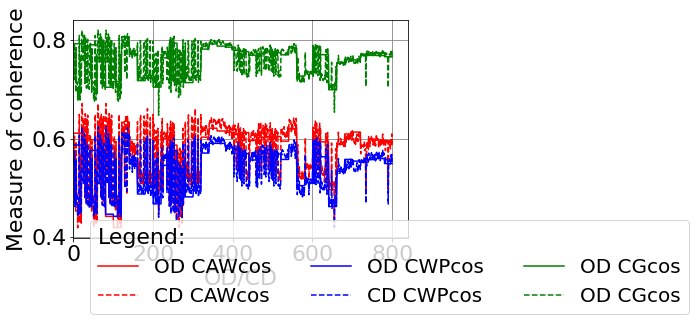

In [149]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW, 
                   lista_perturbado_CcosCAW, 
                   lista_original_CcosCWP, 
                   lista_perturbado_CcosCWP, 
                   lista_original_CcosCG, 
                   lista_perturbado_CcosCG,
                   medida = medida)

In [150]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCAW, lista_perturbado_CcosCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CcosCWP, lista_perturbado_CcosCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CcosCG, lista_perturbado_CcosCG))

Diferença entre as equação CAW      : 29.622233281492402
Diferença entre as equação CWP      : 23.38218165191126
Diferença entre as equação CG       : 16.475648176195804


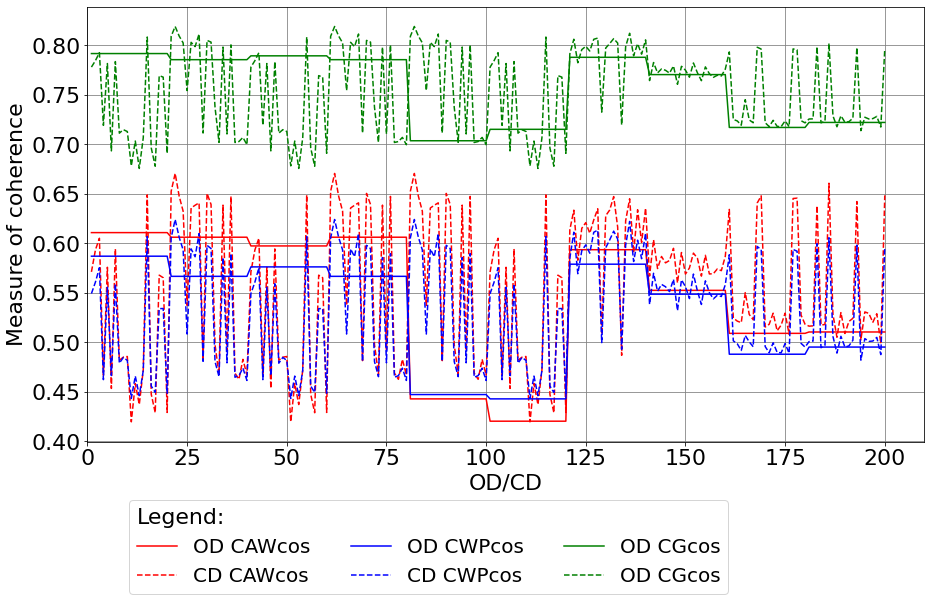

In [151]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:200], 
                   lista_perturbado_CcosCAW[0:200], 
                   lista_original_CcosCWP[0:200], 
                   lista_perturbado_CcosCWP[0:200], 
                   lista_original_CcosCG[0:200], 
                   lista_perturbado_CcosCG[0:200],
                   medida = medida)

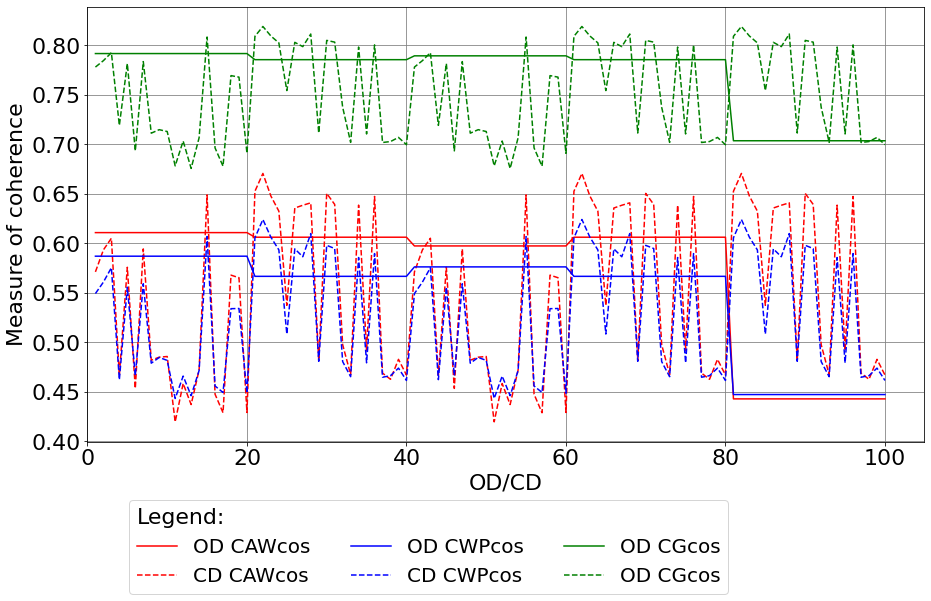

In [152]:

graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:100], 
                   lista_perturbado_CcosCAW[0:100], 
                   lista_original_CcosCWP[0:100], 
                   lista_perturbado_CcosCWP[0:100], 
                   lista_original_CcosCG[0:100], 
                   lista_perturbado_CcosCG[0:100],
                  medida = medida)

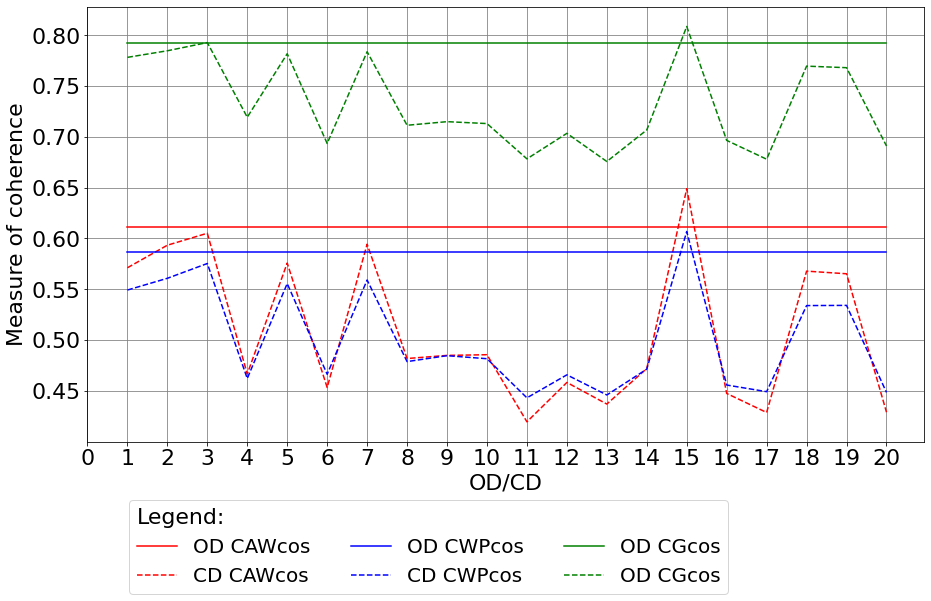

In [153]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_CcosCAW[0:20], 
                   lista_perturbado_CcosCAW[0:20], 
                   lista_original_CcosCWP[0:20], 
                   lista_perturbado_CcosCWP[0:20], 
                   lista_original_CcosCG[0:20], 
                   lista_perturbado_CcosCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

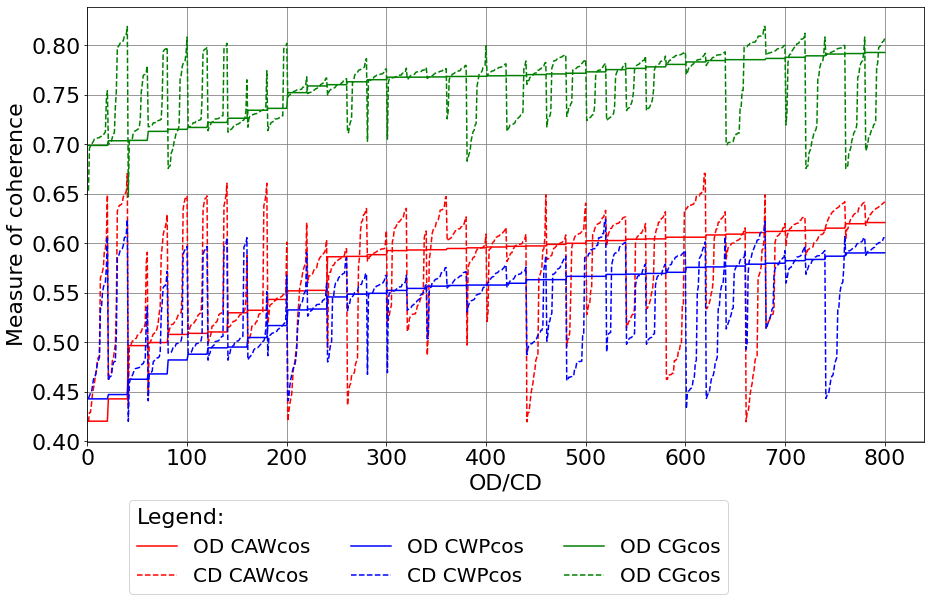

In [154]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW, 
                   lista_perturbado_ordenado_CcosCAW, 
                   lista_original_ordenado_CcosCWP, 
                   lista_perturbado_ordenado_CcosCWP, 
                   lista_original_ordenado_CcosCG, 
                   lista_perturbado_ordenado_CcosCG,
                   medida = medida)

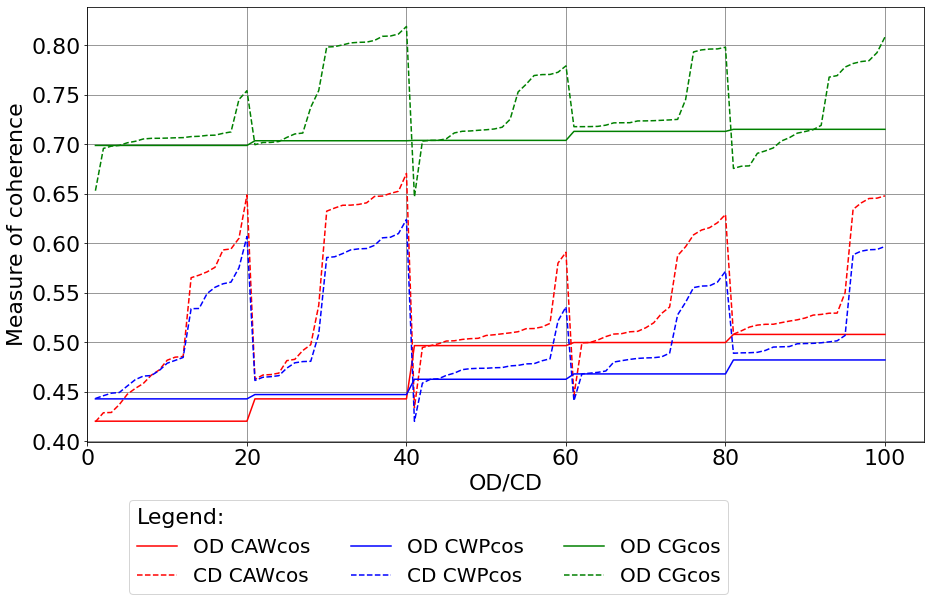

In [155]:
graficoLinhaMedida('Measure of coherence', 
                   lista_original_ordenado_CcosCAW[0:100], 
                   lista_perturbado_ordenado_CcosCAW[0:100], 
                   lista_original_ordenado_CcosCWP[0:100], 
                   lista_perturbado_ordenado_CcosCWP[0:100], 
                   lista_original_ordenado_CcosCG[0:100], 
                   lista_perturbado_ordenado_CcosCG[0:100],
                  medida = medida)

#### Gráfico de linha da medida de coerência Ccos ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

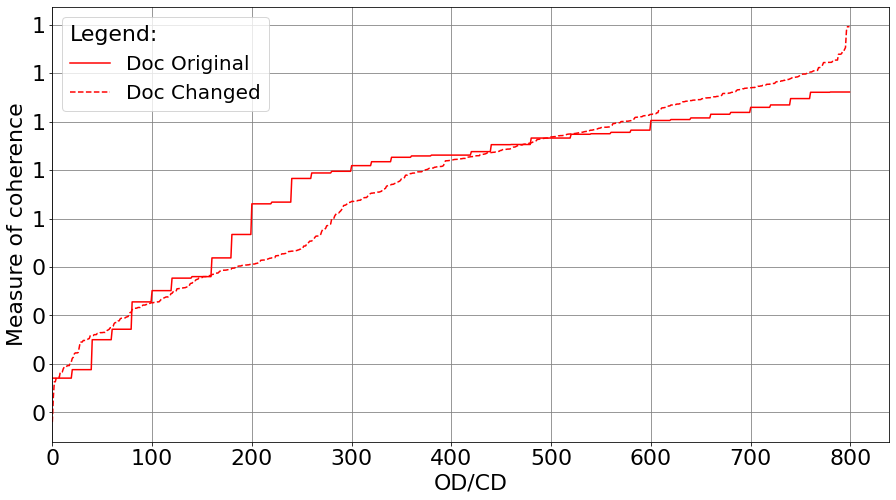

In [156]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_ordenado_CcosCWP, 
                    lista_perturbado_ordenado_CcosCWP,
                    medida = 'cos')

Sem ordem

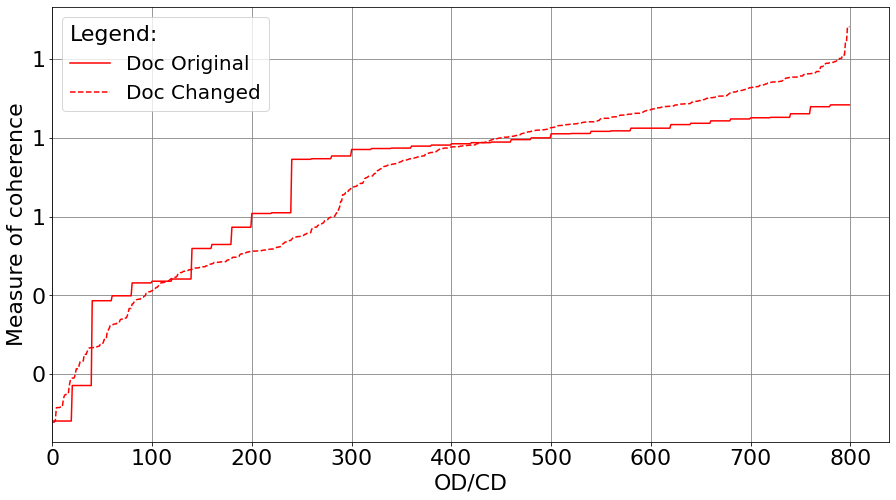

In [157]:
graficoLinhaMedida2('Measure of coherence', 
                    lista_original_CcosCAW, 
                    lista_perturbado_CcosCAW)

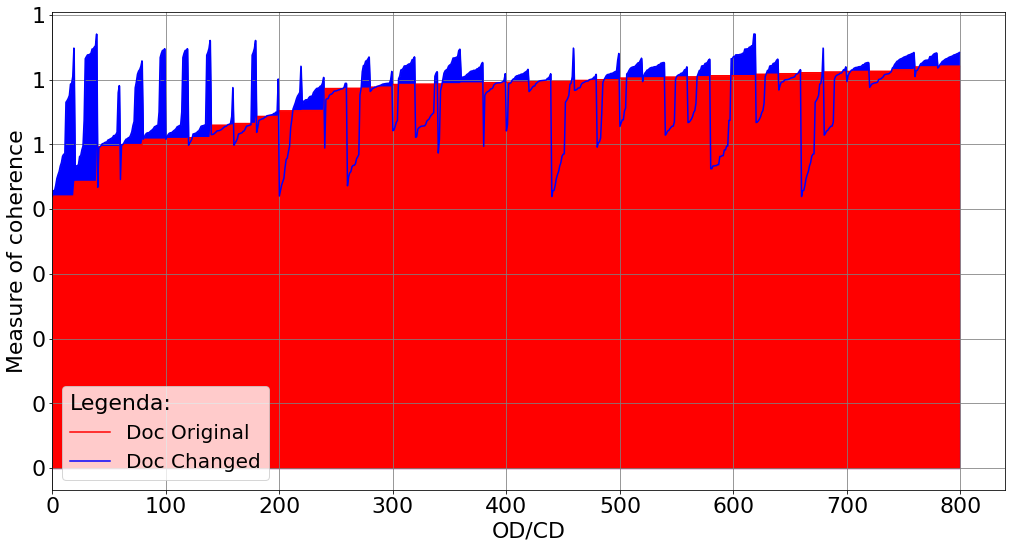

In [158]:
graficoLinhaMedida2Preenchido('Measure of coherence', 
                              lista_original_ordenado_CcosCAW, 
                              lista_perturbado_ordenado_CcosCAW,
                              medida = 'cos')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [159]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 29.622233281492402

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['17p0', 0.10154444896257864, 15, 'How are the operations to push and pop elements in a queue implemented?']
['20', 0.1105570305477489, 22, 'In a queue does the enqueue operation occur at which end?']
['19p0', 0.12548798322677646, 24, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.157696688175201, 36, 'What is a stack and how to enqueue its element?']
['15p0', 0.1587836161876719, 10, 'What is a queue and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 1.6258489816848725, 14, 'How to pop elements from a stack?']
['3p0', 1.7834287305761662, 1, 'How to push elements in a queue?']
['2', 1.8796617262331499, 23, 'How to dequeue elements in a 

##### Usando CAW onde Cm(pertDO)>Cm(DO) *


In [160]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 14.531666728615836

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.011364239912766583, 33, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11p0', 0.01550743232170737, 35, 'What is a stack and how to dequeue an element in it?']
['19', 0.01805874163454224, 13, 'In a stack does the pop operation occur at which end?']
['20p0', 0.02078902721404996, 20, 'In a queue does the push operation occur at which end?']
['19p0', 0.02751395648176036, 24, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.8764975691835079, 6, 'How to push elements in a stac

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [161]:
# id_documento = "3"
id_documento = lista[-1:][0][0]

In [162]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [163]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [164]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 15.090566552876547

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['3p0', 0.0006427583949906168, 1, 'How to push elements in a queue?']
['5', 0.0009162185920609245, 6, 'How to push elements in a stack data structure?']
['9p0', 0.004135400056838878, 40, 'What is a queue and how to push its element?']
['9', 0.00567538738250728, 27, 'What is a stack and how to push its element?']
['17p0', 0.015230089426040427, 15, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 1.0993925418172568, 30, 'How to dequeue elements in a stack?']
['2p0', 1.0993925418172568, 31, 'How to dequeu

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [165]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [166]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [167]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

#### Usando CWP

In [168]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 23.38218165191126

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10p0', 0.1076862313530661, 37, 'What is a stack and how to enqueue its element?']
['17p0', 0.12215493504817676, 12, 'How are the operations to push and pop elements in a queue implemented?']
['19p0', 0.13599157649459326, 19, 'In a stack does the enqueue operation occur at which end?']
['9p0', 0.14027795629067852, 40, 'What is a queue and how to push its element?']
['10', 0.1425148860974753, 39, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 1.1746004660214702, 26, 'How to dequeue elements in a stack?']
['7', 1.4589270923918642, 31, 'How to pop elements from a stack?']
['2', 1.5563768502657431, 32, 'How to dequeue elements in a queue?']
['1

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [169]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 10.814026785733747

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.000516145438938298, 20, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['18p0', 0.006584952493290275, 17, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['1', 0.01986428137336449, 38, 'How to enqueue elements in a queue?']
['11p0', 0.02544789474744036, 29, 'What is a stack and how to dequeue an element in it?']
['13p0', 0.028315645379897614, 28, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.6460554122924813, 6, 'How to push elements in a

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [170]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [171]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to find elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> find(>CWPcos(pertDO)=0,4612955031)] - VERB/VERB-1-0
  2 - How to connect elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> connect(>CWPcos(pertDO)=0,4645378393)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> separate(>CWPcos(pertDO)=0,4651108677)] - VERB/VERB-1-0
  4 - How to order elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> order(>CWPcos(pertDO)=0,4661453345)] - VERB/VERB-1-0
  5 - How to create elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> create(>CWPcos(pertDO)=0,4737560845)] - VERB/VERB-1-0
  6 - How to manipulate elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> manipulate(>CWPcos(pertDO)=0,4791309333)] - VERB/VERB-1-0
  7 - How to use elements in a stack ? [push(CWPcos(DO)=0,4470503824) -> use(>CWPcos(pertDO)=0,4803760238)] - VERB/VERB-

In [172]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [173]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 12.568154866177498

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00030205226861523826, 21, 'What is a stack and how to push an element on it?']
['9', 0.002004726908423682, 30, 'What is a stack and how to push its element?']
['10', 0.0027173302390357534, 39, 'What is a queue and how to enqueue its element?']
['9p0', 0.0029969464648853528, 40, 'What is a queue and how to push its element?']
['19p0', 0.004426009727246716, 19, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 0.8196803054639271, 26, 'How to dequeue elements in a stack?']
['16p0', 1.0319113525179908, 23, 'W

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [174]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [175]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to execute an element on it ? [push(>CWPcos(DO)=0,5577448244) -> execute(CWPcos(pertDO)=0,5574427721)] - VERB/VERB-1-0
  2 - What is a stack and how to construct an element on it ? [push(CWPcos(DO)=0,5577448244) -> construct(>CWPcos(pertDO)=0,5601501014)] - VERB/VERB-1-0
  3 - What is a stack and how to load an element on it ? [push(CWPcos(DO)=0,5577448244) -> load(>CWPcos(pertDO)=0,5612344551)] - VERB/VERB-1-0
  4 - What is a stack and how to build an element on it ? [push(CWPcos(DO)=0,5577448244) -> build(>CWPcos(pertDO)=0,5632937302)] - VERB/VERB-1-0
  5 - What is a stack and how to have an element on it ? [push(CWPcos(DO)=0,5577448244) -> have(>CWPcos(pertDO)=0,5645030576)] - VERB/VERB-1-0
  6 - What is a stack and how to represent an element on it ? [push(CWPcos(DO)=0,5577448244) -> represent(>CWPcos(pertDO)=0,565802932

In [176]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a stack and how to put an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;put;VERB;0,6192863633;0,5697919325;0,7764330277;0,2460652888;0;1
14_pert_1;What is a stack and how to place an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;place;VERB;0,6169475690;0,5722487191;0,7778891829;0,1942972094;0;1
14_pert_2;What is a stack and how to implement an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;implement;VERB;0,6121923799;0,5665102674;0,7744744374;0,0522025973;0;1
14_pert_3;What is a stack and how to define an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;define;VERB;0,6190907856;0,5774

#### Usando CG

In [177]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 16.475648176195804

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.07215456451688473, 13, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['17p0', 0.07541475977216461, 11, 'How are the operations to push and pop elements in a queue implemented?']
['9p0', 0.08005840128118269, 38, 'What is a queue and how to push its element?']
['19p0', 0.08082972466945659, 18, 'In a stack does the enqueue operation occur at which end?']
['18p0', 0.08536972744124283, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 0.8628280935809016, 34, 'How to dequeue elements in a stack?']
['7', 0.9979386630002409, 40, 'How to pop elements from a stack?']
['2', 1.1

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [178]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 7.033097747293168

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['1', 0.01761838048696518, 39, 'How to enqueue elements in a queue?']
['11p0', 0.018014605228717562, 27, 'What is a stack and how to dequeue an element in it?']
['2', 0.022215552628040314, 37, 'How to dequeue elements in a queue?']
['18', 0.024954872471945944, 13, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['18p0', 0.028629090104784538, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.48549378775060137, 6, 'How to push elements in a stack data structure

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [179]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [180]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to find elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> find(CGcos(pertDO)=0,6995989825)] - VERB/VERB-1-0
  2 - How to connect elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> connect(CGcos(pertDO)=0,7018327564)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> separate(CGcos(pertDO)=0,7019377626)] - VERB/VERB-1-0
  4 - How to order elements in a stack ? [push(>CGcos(DO)=0,7036041166) -> order(CGcos(pertDO)=0,7027993700)] - VERB/VERB-1-0
  5 - How to create elements in a stack ? [push(CGcos(DO)=0,7036041166) -> create(>CGcos(pertDO)=0,7069749818)] - VERB/VERB-1-0
  6 - How to manipulate elements in a stack ? [push(CGcos(DO)=0,7036041166) -> manipulate(>CGcos(pertDO)=0,7104687942)] - VERB/VERB-1-0
  7 - How to sort elements in a stack ? [push(CGcos(DO)=0,7036041166) -> sort(>CGcos(pertDO)=0,7114053844)] - VERB/VERB-1-0
  8 - Ho

In [181]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [182]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00018393993377685547, 21, 'What is a stack and how to push an element on it?']
['9', 0.0011645392938093302, 30, 'What is a stack and how to push its element?']
['9p0', 0.001677789471366209, 38, 'What is a queue and how to push its element?']
['19p0', 0.002688676118850708, 18, 'In a stack does the enqueue operation occur at which end?']
['20', 0.0039013723532359545, 17, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 0.6695222479756922, 20, 'How to pop elements from a queue?']
['16p0', 0.7885122307791155, 2

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [183]:
id_documento = "4"
id_documento = lista[0:1][0][0]

In [184]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
  1 - What is a stack and how to execute an element on it ? [push(>CGcos(DO)=0,7692333231) -> execute(CGcos(pertDO)=0,7690493831)] - VERB/VERB-1-0
  2 - What is a stack and how to construct an element on it ? [push(CGcos(DO)=0,7692333231) -> construct(>CGcos(pertDO)=0,7706754208)] - VERB/VERB-1-0
  3 - What is a stack and how to load an element on it ? [push(CGcos(DO)=0,7692333231) -> load(>CGcos(pertDO)=0,7713220028)] - VERB/VERB-1-0
  4 - What is a stack and how to build an element on it ? [push(CGcos(DO)=0,7692333231) -> build(>CGcos(pertDO)=0,7725568964)] - VERB/VERB-1-0
  5 - What is a stack and how to have an element on it ? [push(CGcos(DO)=0,7692333231) -> have(>CGcos(pertDO)=0,7732839447)] - VERB/VERB-1-0
  6 - What is a stack and how to represent an element on it ? [push(CGcos(DO)=0,7692333231) -> represent(>CGcos(pertDO)=0,7740541330)] - VERB/V

In [185]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 14
DO: What is a stack and how to push an element on it?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB DET NOUN ADP PRON PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
14_pert_0;What is a stack and how to put an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;put;VERB;0,6192863633;0,5697919325;0,7764330277;0,2460652888;0;1
14_pert_1;What is a stack and how to place an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;place;VERB;0,6169475690;0,5722487191;0,7778891829;0,1942972094;0;1
14_pert_2;What is a stack and how to implement an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;implement;VERB;0,6121923799;0,5665102674;0,7744744374;0,0522025973;0;1
14_pert_3;What is a stack and how to define an element on it ?;push;VERB;0,5946985558;0,5577448244;0,7692333231;define;VERB;0,6190907856;0,5774

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [186]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWcos: 9.442550428902623

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.015294703570279178, 22, 'In a queue does the enqueue operation occur at which end?']
['19p0', 0.015336061065847284, 24, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.015657290816307068, 36, 'What is a stack and how to enqueue its element?']
['9p0', 0.0211719989776612, 40, 'What is a queue and how to push its element?']
['14p0', 0.021680305401484135, 39, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 0.1506307486976896, 14, 'How to pop elements from a stack?']
['2', 0.17779871927840363, 23, 'How to dequeue elements in a queue?']
['1', 0.19126610777207786, 34,

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [187]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.006337307966672423, 33, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11p0', 0.007941357791423798, 35, 'What is a stack and how to dequeue an element in it?']
['19', 0.008114671165292853, 13, 'In a stack does the pop operation occur at which end?']
['19p0', 0.009541628035632077, 24, 'In a stack does the enqueue operation occur at which end?']
['20', 0.01227254488251428, 22, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 0.13897576928138733, 6, 'How to push elements in a stack data

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [188]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [189]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [push(>CAWcos(DO)=0,4201182744) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> move(>CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> process(>CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> connect(>CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> rank(>CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> sort(>CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [push(CAWcos(DO)=0,4201182744) -> position(>CAWcos(pertDO)=0,4582101437)] - VERB/VERB-1-0
  

In [190]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3p0
DO: How to push elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3p0_pert_0;How to place elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
3p0_pert_1;How to arrange elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
3p0_pert_2;How to organize elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
3p0_pert_3;How to manage elements in a queue ?;push;VERB;0,4201182744;0,4426747426;0,7151520588;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
3p0_pert_4;How to put elements in a queue ?;push;VERB;0,42011

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [191]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['3p0', 0.0006427583949906168, 1, 'How to push elements in a queue?']
['5', 0.0009162185920609245, 6, 'How to push elements in a stack data structure?']
['9p0', 0.002923977375030473, 40, 'What is a queue and how to push its element?']
['9', 0.00567538738250728, 27, 'What is a stack and how to push its element?']
['17p0', 0.0065564054709214, 15, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.14362994049276628, 30, 'How to dequeue elements in a stack?']
['2p0', 0.14362994049276628, 31, 'How to dequeue elements 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [192]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [193]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [194]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

#### Usando CWP






In [195]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPcos: 9.442550428902623

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['19p0', 0.014103910236647699, 19, 'In a stack does the enqueue operation occur at which end?']
['10p0', 0.015017429265108961, 37, 'What is a stack and how to enqueue its element?']
['9p0', 0.015319946679202001, 40, 'What is a queue and how to push its element?']
['10', 0.0154597547921268, 39, 'What is a queue and how to enqueue its element?']
['20', 0.01637325639074505, 22, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 0.1330055384231465, 32, 'How to dequeue elements in a queue?']
['7', 0.1429494619535815, 31, 'How to pop elements from a stack?']
['1', 0.1438250129244158, 38, 'How t

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [196]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.000516145438938298, 20, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['18p0', 0.003781843971420118, 17, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['10p0', 0.00899190306663511, 37, 'What is a stack and how to enqueue its element?']
['11p0', 0.009460702156409151, 29, 'What is a stack and how to dequeue an element in it?']
['13p0', 0.010177639814523465, 28, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.11051347636514242, 8, 'How to push elements

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [197]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [198]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [199]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [200]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00030205226861523826, 21, 'What is a stack and how to push an element on it?']
['9', 0.002004726908423682, 30, 'What is a stack and how to push its element?']
['10', 0.002303894541480278, 39, 'What is a queue and how to enqueue its element?']
['9p0', 0.0024437026544050777, 40, 'What is a queue and how to push its element?']
['19p0', 0.002521100820917055, 19, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.10524938415203777, 25, 'How to dequeue elements in a stack?']
['2p0', 0.10524938415203777, 26, 'How to dequeue 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [201]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [202]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [203]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

#### Usando CG






In [204]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGcos: 9.442550428902623

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.008141232388360176, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['19p0', 0.00841757158438361, 18, 'In a stack does the enqueue operation occur at which end?']
['9p0', 0.008727983994917365, 38, 'What is a queue and how to push its element?']
['10p0', 0.00880587642843067, 32, 'What is a stack and how to enqueue its element?']
['20', 0.009746576348940494, 17, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 0.09330941364169121, 5, 'How to push elements in a queue?']
['7', 0.09929525258485228, 40, 'How to pop elements from a stack?']
['2'

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [205]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18', 0.006098168236868706, 13, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['11p0', 0.006338087412027238, 27, 'What is a stack and how to dequeue an element in it?']
['18p0', 0.008141232388360176, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['19p0', 0.00841757158438361, 18, 'In a stack does the enqueue operation occur at which end?']
['13p0', 0.008610720817859296, 26, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.07998133376240735, 7, 'How to push 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [206]:
id_documento = "15"
id_documento = lista[-1:][0][0]

In [207]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> order(>CAWcos(pertDO)=0,4624630064)] - VERB/VERB-1-0
  2 - How to find elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> find(>CAWcos(pertDO)=0,4667726979)] - VERB/VERB-1-0
  3 - How to separate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> separate(>CAWcos(pertDO)=0,4672470966)] - VERB/VERB-1-0
  4 - How to connect elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> connect(>CAWcos(pertDO)=0,4687169173)] - VERB/VERB-1-0
  5 - How to sort elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> sort(>CAWcos(pertDO)=0,4813343851)] - VERB/VERB-1-0
  6 - How to create elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> create(>CAWcos(pertDO)=0,4826276228)] - VERB/VERB-1-0
  7 - How to manipulate elements in a stack ? [push(CAWcos(DO)=0,4426719219) -> manipulate(>CAWcos(pertDO)=0,4915693988)] - VERB/VER

In [208]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;arrange;VERB;0,6525400536;0,6054948622;0,8091780618;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;organize;VERB;0,6705504145;0,6239989198;0,8191116452;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;store;VERB;0,6476989388;0,6060953225;0,8094890118;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;0,4426719219;0,4470503824;0,7036041166;put;VERB;0,6324272156;0,5932627363;0,8025276884;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VERB;0,4426719219;0,4470503

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [209]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos: 9.442550428902623

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGcos ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['14', 0.00018393993377685547, 21, 'What is a stack and how to push an element on it?']
['9', 0.0011645392938093302, 30, 'What is a stack and how to push its element?']
['9p0', 0.0014044208960100057, 38, 'What is a queue and how to push its element?']
['19p0', 0.001522347331047058, 18, 'In a stack does the enqueue operation occur at which end?']
['20', 0.002474367618560791, 17, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 0.08595838444307446, 33, 'How to dequeue elements in a stack?']
['2p0', 0.08595838444307446, 34, 'How to

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [210]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [211]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to order elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> order(CAWcos(pertDO)=0,4194755160)] - VERB/VERB-1-0
  2 - How to move elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> move(CAWcos(pertDO)=0,4286599862)] - VERB/VERB-1-0
  3 - How to process elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> process(CAWcos(pertDO)=0,4289324193)] - VERB/VERB-1-0
  4 - How to connect elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> connect(CAWcos(pertDO)=0,4369510955)] - VERB/VERB-1-0
  5 - How to rank elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> rank(CAWcos(pertDO)=0,4473739378)] - VERB/VERB-1-0
  6 - How to sort elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> sort(CAWcos(pertDO)=0,4532546103)] - VERB/VERB-1-0
  7 - How to position elements in a queue ? [enqueue(>CAWcos(DO)=0,6107416238) -> position(CAWcos(pertDO)=0,458210143

In [212]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : cos
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWcos(DO);CWPcos(DO);CGcos(DO);palavra predita;PoS predita;CAWcos(pertDO);CWPcos(pertDO);CGcos(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;place;VERB;0,5710570642;0,5491354689;0,7780830786;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;arrange;VERB;0,5932505642;0,5606968190;0,7845610753;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;organize;VERB;0,6050297448;0,5752453761;0,7926375046;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;0,6107416238;0,5869072612;0,7917402983;manage;VERB;0,4665834860;0,4621098174;0,7191541316;0,0467672087;0;1
1_pert_4;How to put elements in a queue ?;enqueue;VERB;0

## 3.6  Avaliando o cálculo da incoerência com todas as equações e com a medida de distância euclidiana(euc)






In [213]:
medida = 'euc'

### Estatística

#### CAW

In [214]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 397 de 800
Percentual de documentos coerentes em relação ao total: 49.625
Acertos Perturbado : 403 de 800
Percentual de documentos incoerentes em relação ao total: 50.375


#### CWP

In [215]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 413 de 800
Percentual de documentos coerentes em relação ao total: 51.625
Acertos Perturbado : 387 de 800
Percentual de documentos incoerentes em relação ao total: 48.375


#### CG

In [216]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 384 de 800
Percentual de documentos coerentes em relação ao total: 48.0
Acertos Perturbado : 416 de 800
Percentual de documentos incoerentes em relação ao total: 52.0


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [217]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 40 documentos originais


Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [218]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to order elements in a queue ?
1p0;How to connect elements in a stack ?
2;How to move elements in a queue ?
2p0;How to order elements in a stack ?
3;How to find elements in a stack ?
3p0;How to position elements in a queue ?
4;How to connect and pop elements in a stack ?
4p0;How to jazz and pop elements in a queue ?
5;How to sort elements in a stack data structure ?
5p0;How to sort elements in a queue data structure ?
6;How to scratch and pop elements in a stack data structure ?
6p0;How to load and pop elements in a queue data structure ?
7;How to split elements from a stack ?
7p0;How to select elements from a queue ?
8;How to write elements in a stack data structure ?
8p0;How to order elements in a queue data structure ?
9;What is a stack and how to count its element ?
9p0;What is a queue and how to select its element ?
10;What is a queue and how to choose its element ?
10p0;What is a stack and how to store its element ?
11;What is a queue and how to retrieve an element in it ?


### Gráficos

#### Gráfico de linha das medida de coerência Ceuc dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.





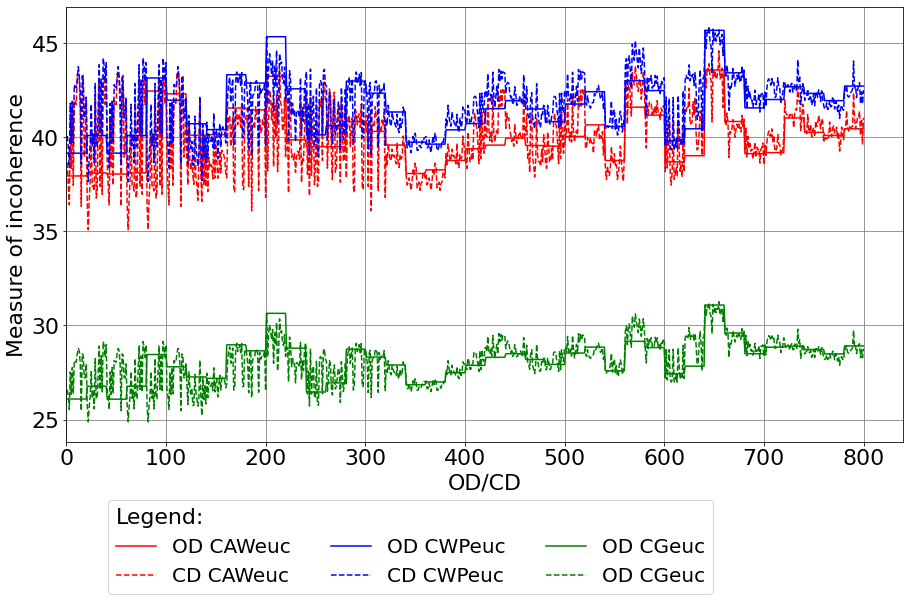

In [219]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW, 
                   lista_perturbado_CeucCAW, 
                   lista_original_CeucCWP, 
                   lista_perturbado_CeucCWP, 
                   lista_original_CeucCG, 
                   lista_perturbado_CeucCG,
                   medida = medida)

In [220]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 981.7333464664204
Diferença absoluta entre as medidas equação CWP : 790.3259358834791
Diferença absoluta entre as medidas equação CG  : 497.2453315490651


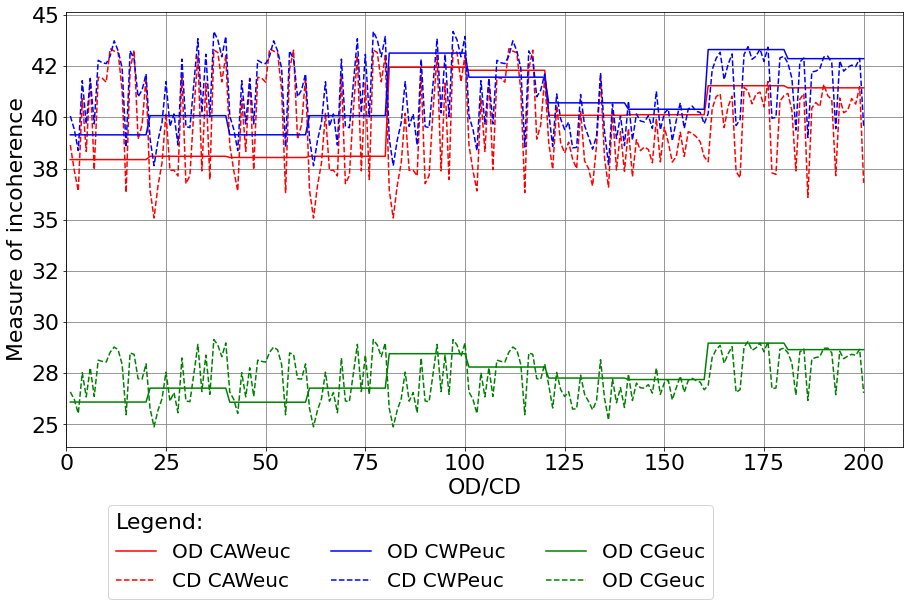

In [221]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CeucCAW[0:200], 
                   lista_perturbado_CeucCAW[0:200], 
                   lista_original_CeucCWP[0:200], 
                   lista_perturbado_CeucCWP[0:200], 
                   lista_original_CeucCG[0:200], 
                   lista_perturbado_CeucCG[0:200],
                   medida = medida)

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

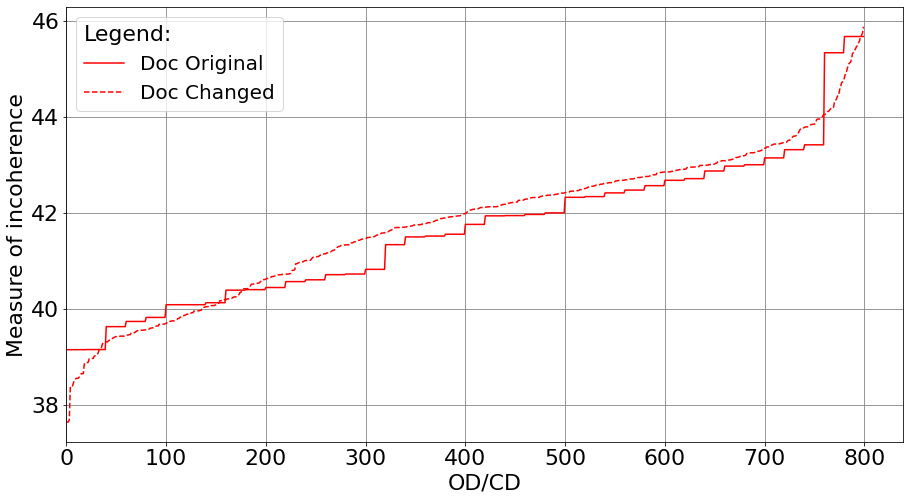

In [222]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCWP, 
                    lista_perturbado_CeucCWP,
                    'r',
                    medida = medida)

Sem ordem

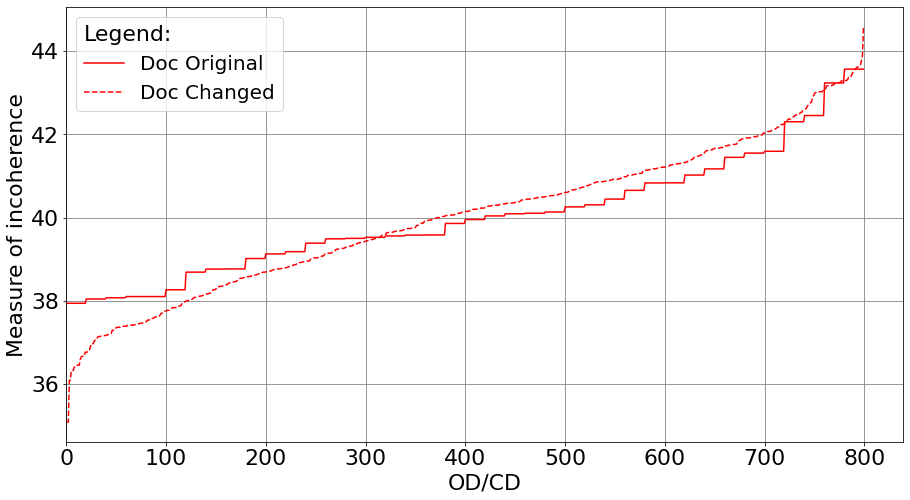

In [223]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CeucCAW, 
                    lista_perturbado_CeucCAW,
                    'r',
                    medida = 'euc')

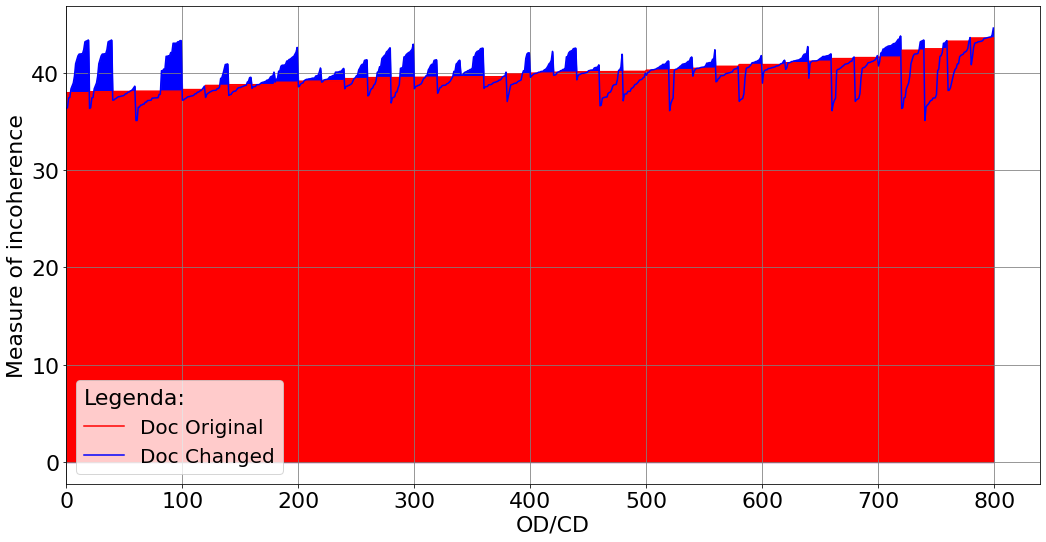

In [224]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CeucCAW, 
                              lista_perturbado_ordenado_CeucCAW,
                              medida = 'euc')

#### Gráfico de linha da medida de coerência Ceuc ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações.

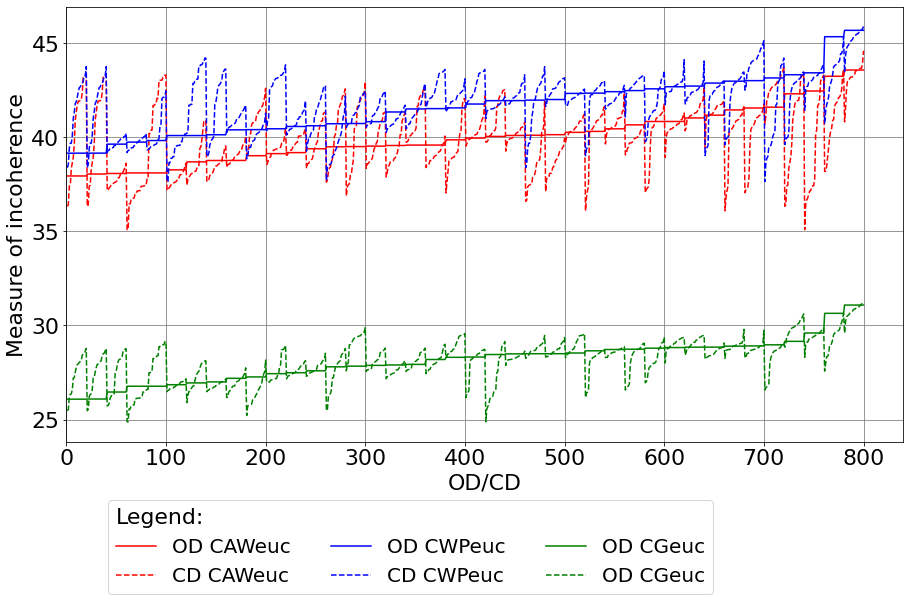

In [225]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW, 
                   lista_perturbado_ordenado_CeucCAW, 
                   lista_original_ordenado_CeucCWP, 
                   lista_perturbado_ordenado_CeucCWP, 
                   lista_original_ordenado_CeucCG, 
                   lista_perturbado_ordenado_CeucCG,
                   medida = medida)

In [226]:
print("Diferença absoluta entre as medidas equação CAW :", getSomatorioDiferencaAbsoluta(lista_original_CeucCAW, lista_perturbado_CeucCAW))
print("Diferença absoluta entre as medidas equação CWP :", getSomatorioDiferencaAbsoluta(lista_original_CeucCWP, lista_perturbado_CeucCWP))
print("Diferença absoluta entre as medidas equação CG  :", getSomatorioDiferencaAbsoluta(lista_original_CeucCG, lista_perturbado_CeucCG))

Diferença absoluta entre as medidas equação CAW : 981.7333464664204
Diferença absoluta entre as medidas equação CWP : 790.3259358834791
Diferença absoluta entre as medidas equação CG  : 497.2453315490651


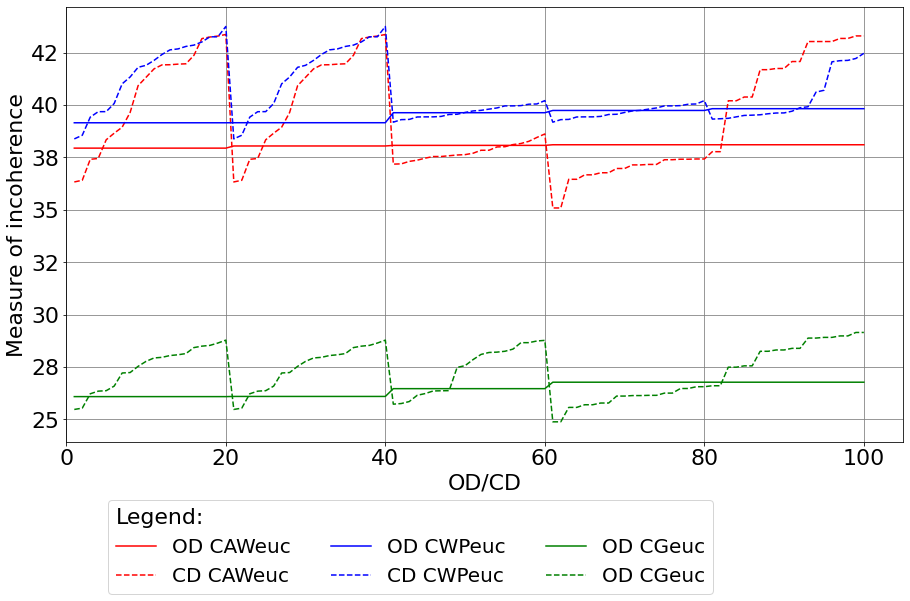

In [227]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[0:100], 
                   lista_perturbado_ordenado_CeucCAW[0:100], 
                   lista_original_ordenado_CeucCWP[0:100], 
                   lista_perturbado_ordenado_CeucCWP[0:100], 
                   lista_original_ordenado_CeucCG[0:100], 
                   lista_perturbado_ordenado_CeucCG[0:100],
                   medida = medida)

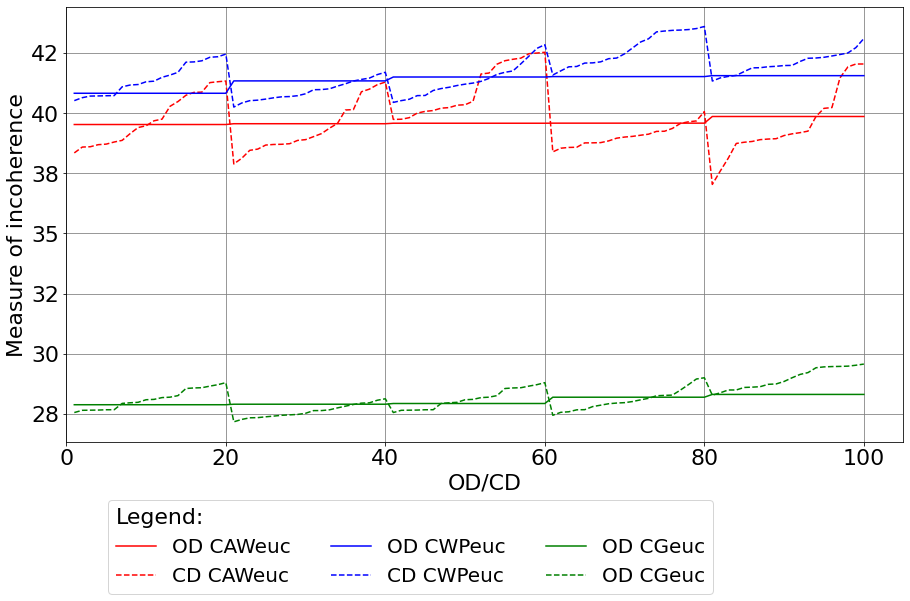

In [228]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

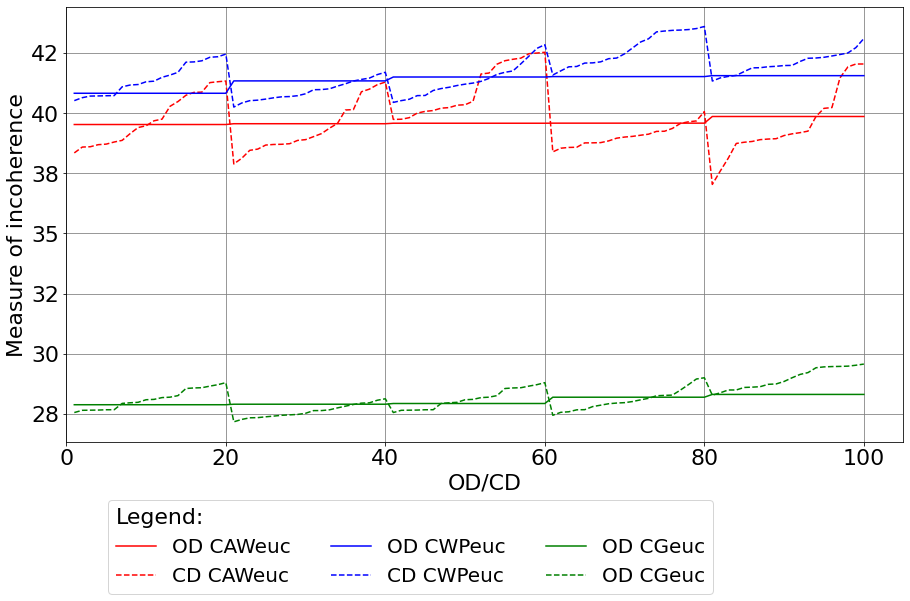

In [229]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CeucCAW[300:400], 
                   lista_perturbado_ordenado_CeucCAW[300:400], 
                   lista_original_ordenado_CeucCWP[300:400], 
                   lista_perturbado_ordenado_CeucCWP[300:400], 
                   lista_original_ordenado_CeucCG[300:400], 
                   lista_perturbado_ordenado_CeucCG[300:400],
                   medida = medida)

# DO central do gráfico com a maior diferença
# idDO = 3
# difabs= 66.91955484662748, 
# 'How to push elements in a stack?'
# Posição gráfico 18 * 20 = 360

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [230]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 981.7333464664204

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 5.828973423350945, 23, 'In a queue does the enqueue operation occur at which end?']
['19p0', 7.360540216619256, 26, 'In a stack does the enqueue operation occur at which end?']
['15p0', 7.865855693817167, 33, 'What is a queue and how to push and pop its elements?']
['10p0', 7.873362922668463, 9, 'What is a stack and how to enqueue its element?']
['18', 8.005241687481139, 11, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 48.55347851344517, 4, 'How to dequeue elements in a stack?']
['2p0', 48.55347851344517, 5, 'How to dequeue elements in a stack?']
['2', 58.58945083618163, 2, 'How to dequeue elements in a q

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [231]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 484.75462844138076

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.20822991265190893, 35, 'How to push elements in a stack data structure?']
['5p0', 0.22408252292209596, 34, 'How to push elements in a queue data structure?']
['6', 0.3757809725674761, 39, 'How to push and pop elements in a stack data structure?']
['10', 0.5396219253540124, 6, 'What is a queue and how to enqueue its element?']
['9', 0.6277305603027372, 19, 'What is a stack and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['1p0', 35.67756652832025, 4, 'How to dequeue elements in a stack?']
['2p0', 35.67756652832025, 5, 'How to dequeue elements in 

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [232]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [233]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [234]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CAW onde Cm(pertDO)<Cm(DO) *

In [235]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 496.9787180250395

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.25886007455680726, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['13p0', 0.8691040674845425, 22, 'What is a stack and how to enqueue an element in it?']
['10p0', 0.9867082595825281, 9, 'What is a stack and how to enqueue its element?']
['12', 1.044405619303447, 21, 'What is a stack and how to pop an element from it?']
['19p0', 1.0716299577192885, 26, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 30.835755030314097, 35, 'How to push elements in a stack data structur

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [236]:
# id_documento = "1"
id_documento = lista[-1:][0][0]

In [237]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [238]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CWP

In [239]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 790.3259358834791

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['10', 5.034560394287098, 3, 'What is a queue and how to enqueue its element?']
['9p0', 5.056249028986159, 4, 'What is a queue and how to push its element?']
['19p0', 5.350007692972788, 26, 'In a stack does the enqueue operation occur at which end?']
['19', 5.96811051802198, 31, 'In a stack does the pop operation occur at which end?']
['20', 6.768554745298488, 22, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6', 40.81319297443733, 39, 'How to push and pop elements in a stack data structure?']
['16p0', 46.80092112223287, 11, 'What is a stack and how to enqueue and dequeue its elements?']
['3', 48.23435769762305, 36, 'How to push element

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [240]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 450.54328827463604

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.25208566453723336, 33, 'How to push elements in a queue data structure?']
['5', 0.29235810173882015, 37, 'How to push elements in a stack data structure?']
['17', 0.2968035058660732, 40, 'How are the operations to push and pop elements in a stack implemented?']
['20', 0.3076264930493835, 22, 'In a queue does the enqueue operation occur at which end?']
['14', 0.5398884553175733, 28, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 27.5772362436567, 7, 'How to dequeue elements in a stack?']
['7', 32.4586576734270

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [241]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [242]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a queue ? [enqueue(CWPeuc(DO)=39,1498506410) -> organize(>CWPeuc(pertDO)=38,3811018808)] - VERB/VERB-1-0
  2 - How to use elements in a queue ? [enqueue(CWPeuc(DO)=39,1498506410) -> use(>CWPeuc(pertDO)=38,5545558929)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> arrange(CWPeuc(pertDO)=39,4187649318)] - VERB/VERB-1-0
  4 - How to put elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> put(CWPeuc(pertDO)=39,6786402294)] - VERB/VERB-1-0
  5 - How to store elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> store(CWPeuc(pertDO)=39,6815622875)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> place(CWPeuc(pertDO)=40,0689068522)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CWPeuc(DO)=39,1498506410) -> group(CWPeuc(pertDO)=41,0

In [243]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [244]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 339.7826476088425

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.1037563788585274, 11, 'What is a stack and how to enqueue and dequeue its elements?']
['10p0', 0.13990898132324503, 9, 'What is a stack and how to enqueue its element?']
['13p0', 0.18268983792034987, 21, 'What is a stack and how to enqueue an element in it?']
['11', 0.3308937610724101, 15, 'What is a queue and how to dequeue an element in it?']
['18', 0.34878565190911814, 20, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6p0', 20.60643612254745, 30, 'How to push and pop elements in a q

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [245]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [246]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> organize(>CWPeuc(pertDO)=37,6427433831)] - VERB/VERB-1-0
  2 - How to stack elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> stack(>CWPeuc(pertDO)=38,6504412379)] - VERB/NOUN-0-0
  3 - How to store elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> store(>CWPeuc(pertDO)=38,8817342349)] - VERB/VERB-1-0
  4 - How to arrange elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> arrange(>CWPeuc(pertDO)=38,9668880190)] - VERB/VERB-1-0
  5 - How to combine elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> combine(>CWPeuc(pertDO)=39,5025003978)] - VERB/VERB-1-0
  6 - How to handle elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> handle(>CWPeuc(pertDO)=39,5537834849)] - VERB/VERB-1-0
  7 - How to place elements in a stack ? [push(CWPeuc(DO)=43,1446408544) -> place(>CWPeuc(pertDO)=39,5619644438)

In [247]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CG

In [248]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 497.2453315490651

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 3.3563974553888514, 6, 'What is a queue and how to push its element?']
['19p0', 3.431324640909839, 28, 'In a stack does the enqueue operation occur at which end?']
['19', 3.9330929120381697, 34, 'In a stack does the pop operation occur at which end?']
['10', 4.289674585515797, 8, 'What is a queue and how to enqueue its element?']
['20', 4.304771900177002, 23, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 26.64438306368314, 15, 'What is a stack and how to enqueue and dequeue its elements?']
['6', 27.197179953257262, 39, 'How to push and pop elements in a stack data structure?']
['1', 29.77384948730468, 2, 'How to enqueue ele

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [249]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 255.27931430048386

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 0.15842933654785085, 36, 'How to push elements in a stack data structure?']
['20', 0.17985026041666785, 23, 'In a queue does the enqueue operation occur at which end?']
['5p0', 0.18076972961424076, 27, 'How to push elements in a queue data structure?']
['10', 0.29682038047097237, 8, 'What is a queue and how to enqueue its element?']
['14', 0.3340256030742843, 33, 'What is a stack and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 15.012972318209172, 37, 'What is a stack and how to push and pop its elements?']
['7', 21.2324316501618, 3, 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [250]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [251]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [dequeue(CGeuc(DO)=26,0871255398) -> use(>CGeuc(pertDO)=25,4749939442)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [dequeue(CGeuc(DO)=26,0871255398) -> organize(>CGeuc(pertDO)=25,5374321938)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> arrange(CGeuc(pertDO)=26,2221984863)] - VERB/VERB-1-0
  4 - How to put elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> put(CGeuc(pertDO)=26,3478198051)] - VERB/VERB-1-0
  5 - How to store elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> store(CGeuc(pertDO)=26,3699717522)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> place(CGeuc(pertDO)=26,5881965160)] - VERB/VERB-1-0
  7 - How to create elements in a queue ? [dequeue(>CGeuc(DO)=26,0871255398) -> create(CGeuc(pertDO)=27,2136938572)] 

In [252]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;How to place elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
2_pert_1;How to arrange elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
2_pert_2;How to organize elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
2_pert_3;How to manage elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
2_pert_4;How to put elements in 

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [253]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.03066503084622596, 20, 'What is a stack and how to dequeue an element in it?']
['16p0', 0.24832930931678376, 15, 'What is a stack and how to enqueue and dequeue its elements?']
['15', 0.48951911926269176, 37, 'What is a stack and how to push and pop its elements?']
['13p0', 0.5064461047832829, 26, 'What is a stack and how to enqueue an element in it?']
['18', 0.579809188842777, 24, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['6p0', 13.975563685099296, 30, 'How to push and pop elements 

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [254]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [255]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> organize(>CGeuc(pertDO)=24,8844165802)] - VERB/VERB-1-0
  2 - How to stack elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> stack(>CGeuc(pertDO)=25,5725605488)] - VERB/NOUN-0-0
  3 - How to store elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> store(>CGeuc(pertDO)=25,6991407871)] - VERB/VERB-1-0
  4 - How to arrange elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> arrange(>CGeuc(pertDO)=25,7810807228)] - VERB/VERB-1-0
  5 - How to combine elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> combine(>CGeuc(pertDO)=26,1128931046)] - VERB/VERB-1-0
  6 - How to place elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> place(>CGeuc(pertDO)=26,1368505955)] - VERB/VERB-1-0
  7 - How to handle elements in a stack ? [push(CGeuc(DO)=28,4580729008) -> handle(>CGeuc(pertDO)=26,1475732327)] - VERB/VERB-

In [256]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [257]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWeuc: 241.96601724858073

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['20', 0.8304439891468363, 23, 'In a queue does the enqueue operation occur at which end?']
['9p0', 0.8949918746948242, 3, 'What is a queue and how to push its element?']
['19p0', 0.952776822176844, 26, 'In a stack does the enqueue operation occur at which end?']
['10', 1.0873889923095703, 6, 'What is a queue and how to enqueue its element?']
['14p0', 1.1026581128438266, 8, 'What is a queue and how to push an element on it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 5.318277631487163, 2, 'How to dequeue elements in a queue?']
['5p0', 5.356238047281899, 34, 'How to push elements in a queue data structure?']
['1', 5.421344757080078, 1, 'Ho

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [258]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.16898473103841383, 34, 'How to push elements in a queue data structure?']
['5', 0.20822991265190893, 35, 'How to push elements in a stack data structure?']
['10', 0.35238971710204936, 6, 'What is a queue and how to enqueue its element?']
['6', 0.3757809725674761, 39, 'How to push and pop elements in a stack data structure?']
['17p0', 0.4497360816368712, 31, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 3.579747358957924, 10, 'What is a stack and how to enqueue and dequeue its elements?']
['1p0', 5.

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [259]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [260]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [261]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [262]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['18p0', 0.1469174898587795, 12, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['13p0', 0.30238914489745383, 22, 'What is a stack and how to enqueue an element in it?']
['10p0', 0.37793464660644815, 9, 'What is a stack and how to enqueue its element?']
['12', 0.43015146255493875, 21, 'What is a stack and how to pop an element from it?']
['19p0', 0.5213050842285156, 26, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5', 4.4964597490098726, 35, 'How to push elements in a stack data structure?']
[

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [263]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [264]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [265]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CWP






In [266]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPeuc: 241.96601724858073

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.5593129244717687, 4, 'What is a queue and how to push its element?']
['10', 0.5781727530739502, 3, 'What is a queue and how to enqueue its element?']
['19p0', 0.6635880325779766, 26, 'In a stack does the enqueue operation occur at which end?']
['14', 0.9269843468299328, 28, 'What is a stack and how to push an element on it?']
['20', 0.9458628278790115, 22, 'In a queue does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 4.1133411271231495, 7, 'How to dequeue elements in a stack?']
['6', 4.589181322039977, 39, 'How to push and pop elements in a stack data structure?']
['2', 4.59086356844220

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [267]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.12160089280870778, 33, 'How to push elements in a queue data structure?']
['5', 0.1448192596435547, 37, 'How to push elements in a stack data structure?']
['17', 0.20437814901163165, 40, 'How are the operations to push and pop elements in a stack implemented?']
['20', 0.20763466574928913, 22, 'In a queue does the enqueue operation occur at which end?']
['19p0', 0.22852163603810993, 26, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 3.4867659296308204, 8, 'How to pop elements from a stack?']
['1p0', 4.113341127123149

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [268]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [269]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [enqueue(CAWeuc(DO)=37,9403517587) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [enqueue(>CAWeuc(DO)=37,9403517587) -> group(CAWeuc(pertDO)=38,9

In [270]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 1
DO: How to enqueue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
1_pert_0;How to place elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
1_pert_1;How to arrange elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
1_pert_2;How to organize elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
1_pert_3;How to manage elements in a queue ?;enqueue;VERB;37,9403517587;39,1498506410;26,0954606533;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
1_pert_4;How to put elements in 

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [271]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 0.1037563788585274, 11, 'What is a stack and how to enqueue and dequeue its elements?']
['10p0', 0.13990898132324503, 9, 'What is a stack and how to enqueue its element?']
['13p0', 0.17727710039186917, 21, 'What is a stack and how to enqueue an element in it?']
['11', 0.20794376960167682, 15, 'What is a queue and how to dequeue an element in it?']
['18', 0.2230023394574161, 20, 'How are the operations to enqueue and dequeue elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 3.5862481934683714, 24, 'How to push elements in a queue?']
['5', 3.711

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [272]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [273]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [274]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

#### Usando CG






In [275]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGeuc: 241.96601724858073

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 0.370009855790574, 6, 'What is a queue and how to push its element?']
['19p0', 0.4285014470418318, 28, 'In a stack does the enqueue operation occur at which end?']
['10', 0.518332047895953, 8, 'What is a queue and how to enqueue its element?']
['20', 0.6099414825439453, 23, 'In a queue does the enqueue operation occur at which end?']
['10p0', 0.6366889260031954, 12, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['5p0', 2.483182334899908, 27, 'How to push elements in a queue data structure?']
['1', 2.6861772537231445, 2, 'How to enqueue elements in a queue?']
['2', 2.694512367248535, 1, 'How t

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [276]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 0.07219753265380291, 27, 'How to push elements in a queue data structure?']
['5', 0.08283081054687358, 36, 'How to push elements in a stack data structure?']
['20', 0.1455866495768241, 23, 'In a queue does the enqueue operation occur at which end?']
['19p0', 0.1586918830871582, 28, 'In a stack does the enqueue operation occur at which end?']
['10', 0.1661673459139763, 8, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7', 2.3036210536956823, 3, 'How to pop elements from a stack?']
['1p0', 2.3732874393463135, 4, 'How to dequeue element

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [277]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [278]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to use elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> use(>CAWeuc(pertDO)=36,3271833147)] - VERB/VERB-1-0
  2 - How to organize elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> organize(>CAWeuc(pertDO)=36,4072355543)] - VERB/VERB-1-0
  3 - How to arrange elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> arrange(>CAWeuc(pertDO)=37,4069557190)] - VERB/VERB-1-0
  4 - How to store elements in a queue ? [dequeue(CAWeuc(DO)=38,0434188843) -> store(>CAWeuc(pertDO)=37,4473912375)] - VERB/VERB-1-0
  5 - How to put elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> put(CAWeuc(pertDO)=38,3391312190)] - VERB/VERB-1-0
  6 - How to place elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> place(CAWeuc(pertDO)=38,6523573739)] - VERB/VERB-1-0
  7 - How to group elements in a queue ? [dequeue(>CAWeuc(DO)=38,0434188843) -> group(CAWeuc(pertDO)=38,9

In [279]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 2
DO: How to dequeue elements in a queue?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
2_pert_0;How to place elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;place;VERB;38,6523573739;40,0689068522;26,5881965160;0,1558294445;0;1
2_pert_1;How to arrange elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;arrange;VERB;37,4069557190;39,4187649318;26,2221984863;0,0571390726;0;1
2_pert_2;How to organize elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;organize;VERB;36,4072355543;38,3811018808;25,5374321938;0,0473415032;0;1
2_pert_3;How to manage elements in a queue ?;dequeue;VERB;38,0434188843;39,1527609825;26,0871255398;manage;VERB;40,9201338632;41,7962424414;27,5304934978;0,0467672087;0;1
2_pert_4;How to put elements in 

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [280]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc: 241.96601724858073

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGeuc ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 0.03066503084622596, 20, 'What is a stack and how to dequeue an element in it?']
['12', 0.1761913299560547, 25, 'What is a stack and how to pop an element from it?']
['18', 0.24435179574149046, 24, 'How are the operations to enqueue and dequeue elements in a queue implemented?']
['16p0', 0.24832930931678376, 15, 'What is a stack and how to enqueue and dequeue its elements?']
['13p0', 0.25876793494591155, 26, 'What is a stack and how to enqueue an element in it?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 2.330771923065189, 14, 'How to push elements in a queue?']
['5', 2.4

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [281]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [282]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
  1 - How to organize elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> organize(>CAWeuc(pertDO)=35,0861323220)] - VERB/VERB-1-0
  2 - How to arrange elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> arrange(>CAWeuc(pertDO)=36,4538773128)] - VERB/VERB-1-0
  3 - How to store elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> store(>CAWeuc(pertDO)=36,6665782928)] - VERB/VERB-1-0
  4 - How to handle elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> handle(>CAWeuc(pertDO)=36,7658792223)] - VERB/VERB-1-0
  5 - How to define elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> define(>CAWeuc(pertDO)=36,9693303789)] - VERB/VERB-1-0
  6 - How to stack elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> stack(>CAWeuc(pertDO)=37,1406852177)] - VERB/NOUN-0-0
  7 - How to combine elements in a stack ? [push(CAWeuc(DO)=42,4519824982) -> combine(>CAWeuc(pertDO)=37,163159506

In [283]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : euc
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 3
DO: How to push elements in a stack?
     SCONJ PART VERB NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWeuc(DO);CWPeuc(DO);CGeuc(DO);palavra predita;PoS predita;CAWeuc(pertDO);CWPeuc(pertDO);CGeuc(pertDO);Ranking predição;Palavra igual;PoS igual
3_pert_0;How to arrange elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;arrange;VERB;36,4538773128;38,9668880190;25,7810807228;0,1123573184;0;1
3_pert_1;How to organize elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;organize;VERB;35,0861323220;37,6427433831;24,8844165802;0,1085551530;0;1
3_pert_2;How to store elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;store;VERB;36,6665782928;38,8817342349;25,6991407871;0,0565749370;0;1
3_pert_3;How to put elements in a stack ?;push;VERB;42,4519824982;43,1446408544;28,4580729008;put;VERB;37,7712658473;39,7506514958;26,2543334961;0,0434137173;0;1
3_pert_4;How to manage elements in a stack ?;push;VER

## 3.7 Avaliando o cálculo da incoerência com todas as equações e com a medida de distância manhattan(man)









In [284]:
medida = 'man'

### Estatística

#### CAW

In [285]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCAW,medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCAW))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 253 de 800
Percentual de documentos coerentes em relação ao total: 31.624999999999996
Acertos Perturbado : 547 de 800
Percentual de documentos incoerentes em relação ao total: 68.375


#### CWP

In [286]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCWP, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCWP))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 315 de 800
Percentual de documentos coerentes em relação ao total: 39.375
Acertos Perturbado : 485 de 800
Percentual de documentos incoerentes em relação ao total: 60.62499999999999


#### CG

In [287]:
acertos_original, acertos_perturbado, resultado_original, resultado_perturbado = acertosMedidaDistanciaOriginal(df_lista_pares_documentos_mensuracaoCG, medida)
print(">>> Contando a coerência do original")
print('Acertos Original :', acertos_original, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos coerentes em relação ao total:', resultado_original*100)

print('Acertos Perturbado :', acertos_perturbado, 'de', len(df_lista_pares_documentos_mensuracaoCG))
print('Percentual de documentos incoerentes em relação ao total:', resultado_perturbado*100)

>>> Contando a coerência do original
Acertos Original : 270 de 800
Percentual de documentos coerentes em relação ao total: 33.75
Acertos Perturbado : 530 de 800
Percentual de documentos incoerentes em relação ao total: 66.25


### Documentos perturbados com as piores medidas CAW sem repetição

Documento perturbado sem repetição com a menor medida para um documento original.

In [288]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

print("Processando",len(lista_documentos_originais),"documentos originais")

# Barra de progresso dos documentos
lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

lista_documentos = []
lista_verificao_documentos = []

# Percorre os documentos originais
for i, linha_documento in lista_documentos_originais_bar: 
  #if i < 2:
  #print("linha_documento:",linha_documento)
  # Recupera o id do documento
  id_documento = linha_documento[0]     
  #print("id_documento:",id_documento)     

  # Recupera as medidas dos perturbados para o documento original
  mensuracoes = df_lista_pares_documentos_mensuracaoCAW.loc[df_lista_pares_documentos_mensuracaoCAW['id_DO'] == id_documento]

  # Ordena descrentemente a medida
  mensuracoes = mensuracoes.sort_values(by=['c' + medida + '_pertDO'], ascending=False)

  # Localiza o documento com a maior medida(euc) sem repetição
  adicionado = False
  indiceMenor = 0
  # Enquanto não tiver adicionado
  while adicionado == False:
    # localiza o documento perturbado que possui a menor medida ceuc
    dfmenor = mensuracoes.iloc[indiceMenor]
    id_documento_perturbado = dfmenor['id_pertDO']
    # print("menor:",dfmenor['id_pertDO'])
    # Recupera o registro documento
    dfdocumento_perturbado = lista_documentos_perturbados_indexado.loc[id_documento_perturbado]
    # Recupera o documento
    documento = dfdocumento_perturbado['documento_perturbado']        
    # Verifica se está na lista
    if documento not in lista_verificao_documentos:
       lista_verificao_documentos.append(documento)
       lista_documentos.append([id_documento, id_documento_perturbado, documento])
       adicionado = True
    else:
      indiceMenor = indiceMenor + 1

Processando 40 documentos originais


Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

In [289]:
for i, documento in enumerate(lista_documentos):
    # print(documento[0] + ";" + documento[1] + ";" + documento[2])
    print(documento[0] + ";" + documento[2])

1;How to position elements in a queue ?
1p0;How to connect elements in a stack ?
2;How to create elements in a queue ?
2p0;How to order elements in a stack ?
3;How to separate elements in a stack ?
3p0;How to rank elements in a queue ?
4;How to throw and pop elements in a stack ?
4p0;How to jazz and pop elements in a queue ?
5;How to sort elements in a stack data structure ?
5p0;How to sort elements in a queue data structure ?
6;How to drag and pop elements in a stack data structure ?
6p0;How to drag and pop elements in a queue data structure ?
7;How to construct elements from a stack ?
7p0;How to fetch elements from a queue ?
8;How to write elements in a stack data structure ?
8p0;How to order elements in a queue data structure ?
9;What is a stack and how to count its element ?
9p0;What is a queue and how to select its element ?
10;What is a queue and how to choose its element ?
10p0;What is a stack and how to find its element ?
11;What is a queue and how to keep an element in it ?
11

### Gráficos

#### Gráfico de linha das medida de coerência Cman dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações





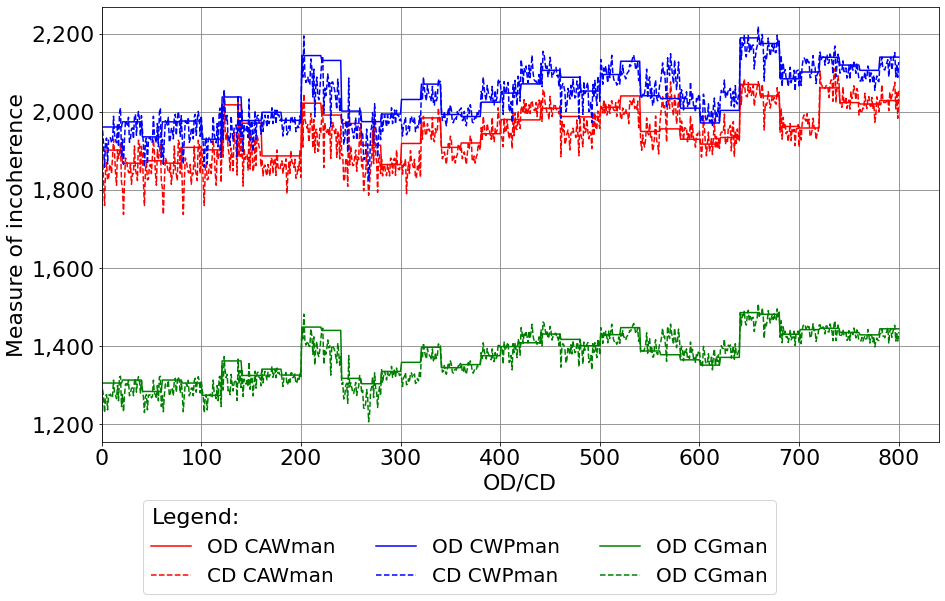

In [290]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW, 
                   lista_perturbado_CmanCAW, 
                   lista_original_CmanCWP, 
                   lista_perturbado_CmanCWP, 
                   lista_original_CmanCG, 
                   lista_perturbado_CmanCG,
                   medida = medida)

In [291]:
print("Diferença entre as equação CAW      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCAW, lista_perturbado_CmanCAW))
print("Diferença entre as equação CWP      :", getSomatorioDiferencaAbsoluta(lista_original_CmanCWP, lista_perturbado_CmanCWP))
print("Diferença entre as equação CG       :", getSomatorioDiferencaAbsoluta(lista_original_CmanCG, lista_perturbado_CmanCG))

Diferença entre as equação CAW      : 29078.556254636478
Diferença entre as equação CWP      : 24608.340860144537
Diferença entre as equação CG       : 16490.401388695063


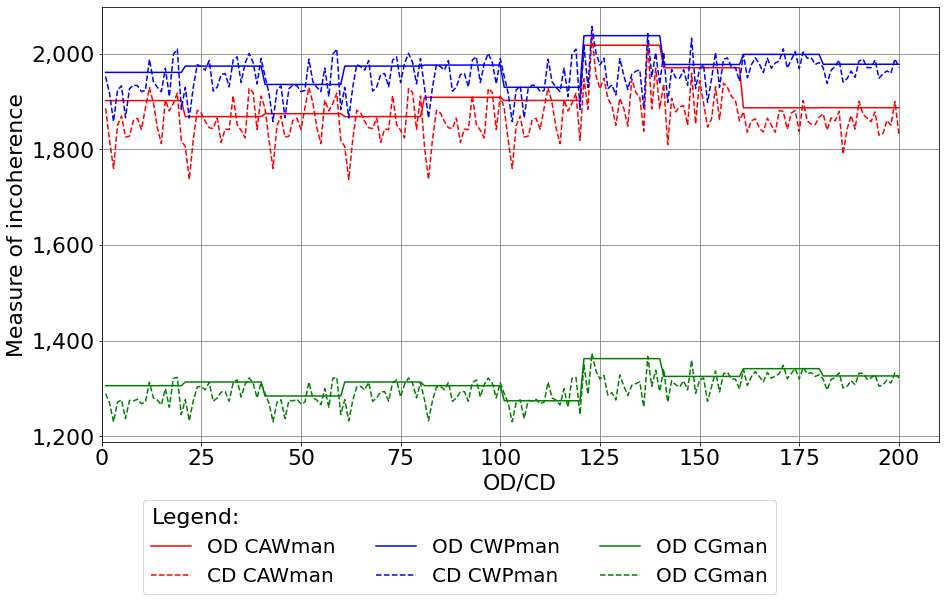

In [292]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:200], 
                   lista_perturbado_CmanCAW[0:200], 
                   lista_original_CmanCWP[0:200], 
                   lista_perturbado_CmanCWP[0:200], 
                   lista_original_CmanCG[0:200], 
                   lista_perturbado_CmanCG[0:200],
                   medida = medida)

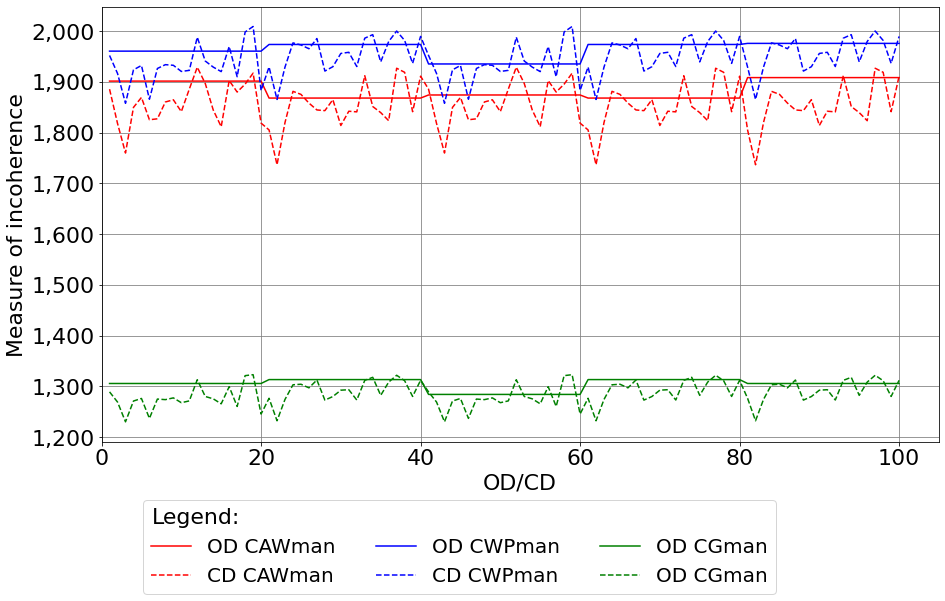

In [293]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:100], 
                   lista_perturbado_CmanCAW[0:100], 
                   lista_original_CmanCWP[0:100], 
                   lista_perturbado_CmanCWP[0:100], 
                   lista_original_CmanCG[0:100], 
                   lista_perturbado_CmanCG[0:100],
                   medida = medida)

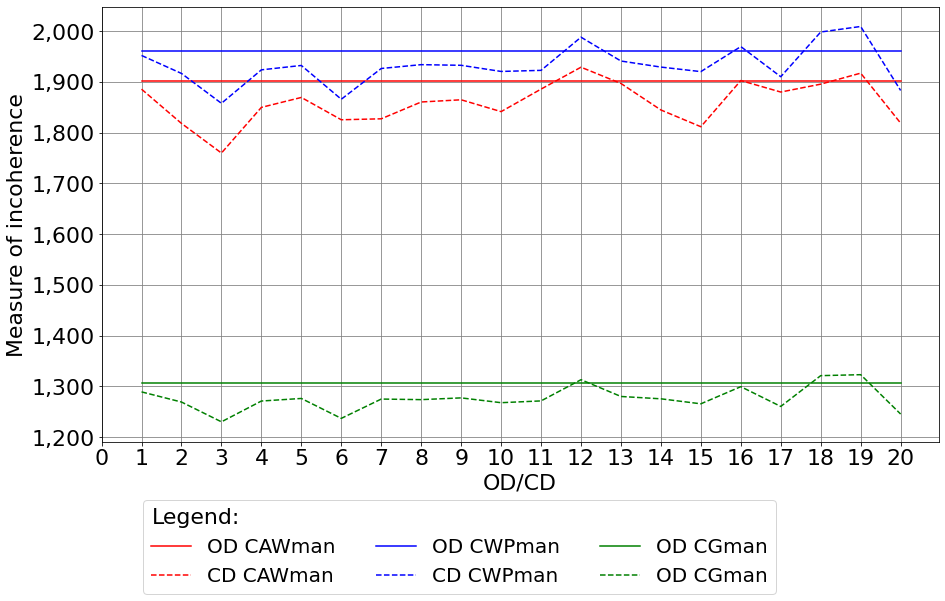

In [294]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_CmanCAW[0:20], 
                   lista_perturbado_CmanCAW[0:20], 
                   lista_original_CmanCWP[0:20], 
                   lista_perturbado_CmanCWP[0:20], 
                   lista_original_CmanCG[0:20], 
                   lista_perturbado_CmanCG[0:20],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando todas as equações

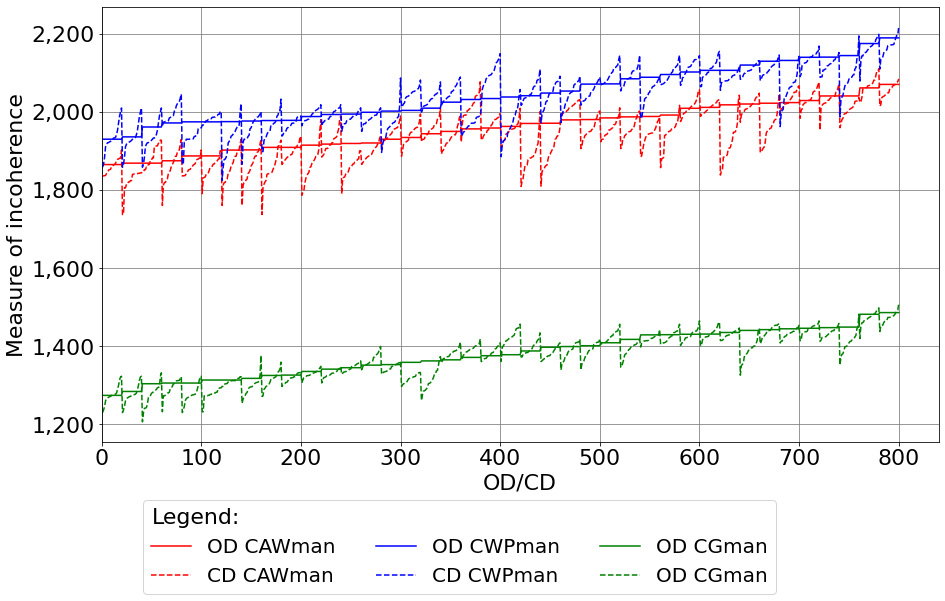

In [295]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW, 
                   lista_perturbado_ordenado_CmanCAW, 
                   lista_original_ordenado_CmanCWP, 
                   lista_perturbado_ordenado_CmanCWP, 
                   lista_original_ordenado_CmanCG, 
                   lista_perturbado_ordenado_CmanCG,
                   medida = medida)

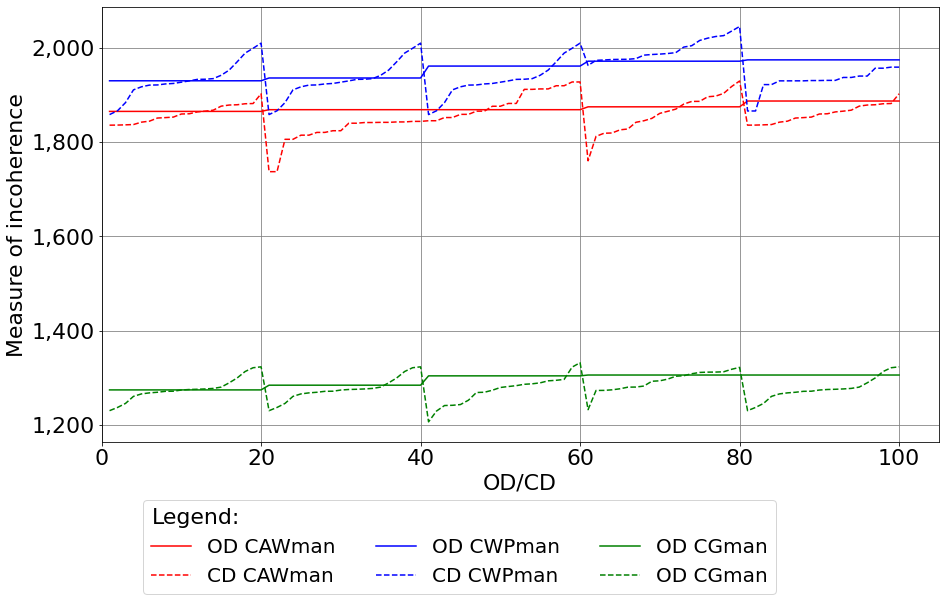

In [296]:
graficoLinhaMedida('Measure of incoherence', 
                   lista_original_ordenado_CmanCAW[0:100], 
                   lista_perturbado_ordenado_CmanCAW[0:100], 
                   lista_original_ordenado_CmanCWP[0:100], 
                   lista_perturbado_ordenado_CmanCWP[0:100], 
                   lista_original_ordenado_CmanCG[0:100], 
                   lista_perturbado_ordenado_CmanCG[0:100],
                   medida = medida)

#### Gráfico de linha da medida de coerência Cman ordenada crescentemente dos documentos originais e suas permutações aleatórias do conjunto de dados Cohebert Auto utilizando 1 equação.

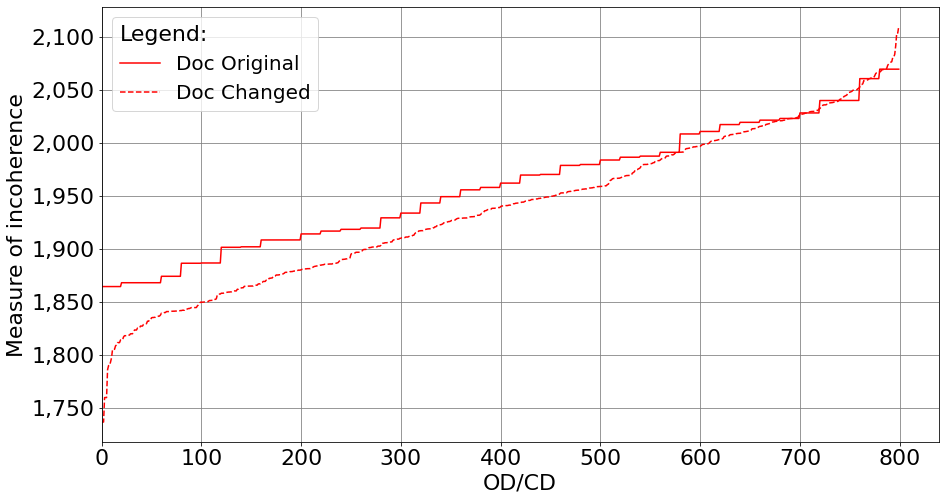

In [297]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_ordenado_CmanCAW, 
                    lista_perturbado_ordenado_CmanCAW,
                    'r',
                    medida = medida)

Sem ordem

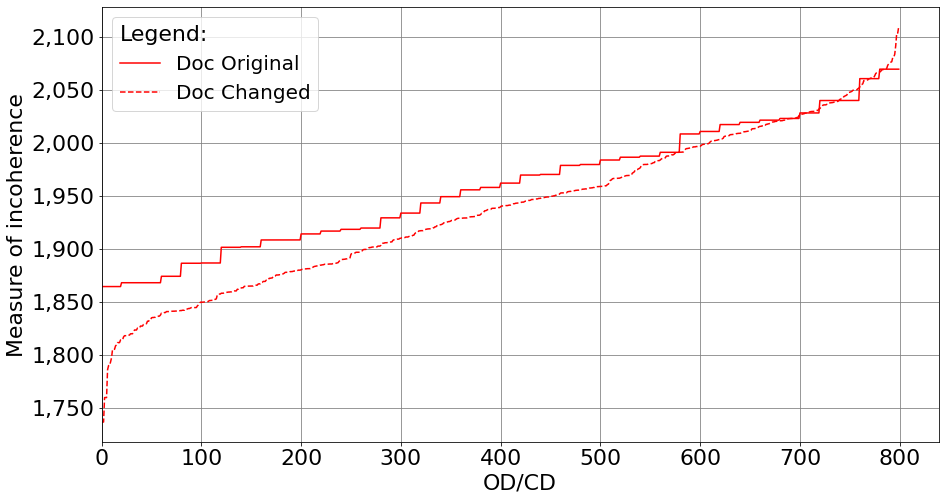

In [298]:
graficoLinhaMedida2('Measure of incoherence', 
                    lista_original_CmanCAW, 
                    lista_perturbado_CmanCAW,
                    'r',
                    medida = medida)

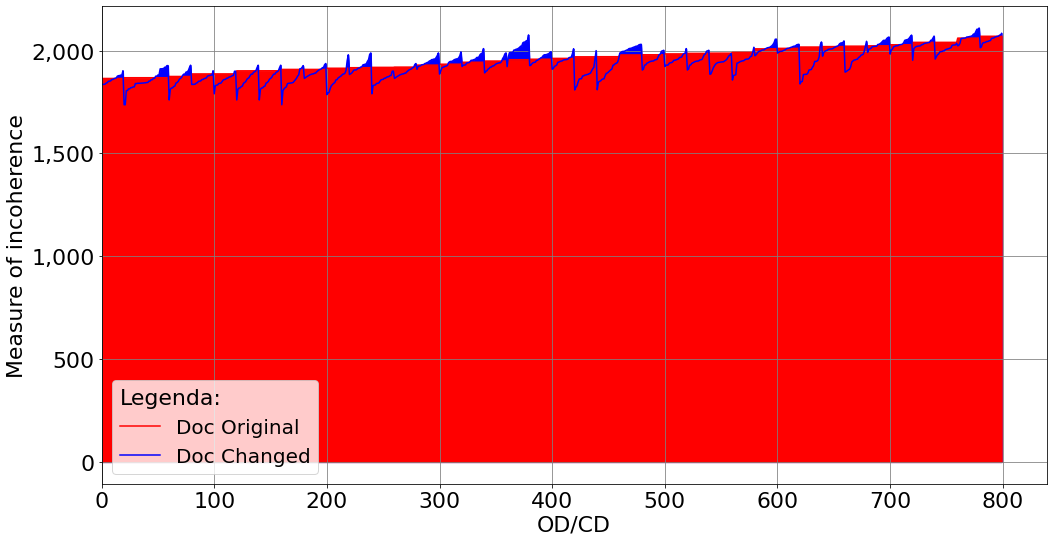

In [299]:
graficoLinhaMedida2Preenchido('Measure of incoherence', 
                              lista_original_ordenado_CmanCAW, 
                              lista_perturbado_ordenado_CmanCAW,
                              medida = 'man')

### Somatórios das diferenças absolutas de DO com as versões perturbadas

#### Usando CAW






In [300]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 29078.556254636478

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13p0', 219.64754999999877, 31, 'What is a stack and how to enqueue an element in it?']
['20', 307.742418181816, 33, 'In a queue does the enqueue operation occur at which end?']
['8', 321.2357777777788, 1, 'How to pop elements in a stack data structure?']
['12', 330.6598249999995, 30, 'What is a stack and how to pop an element from it?']
['17p0', 345.66954615385043, 37, 'How are the operations to push and pop elements in a queue implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 1242.0741000000012, 11, 'How to pop elements from a queue?']
['6', 1389.9341727272672, 34, 'How to push and pop elements in a stack data structure?']
['4p0', 1553.6536888888866, 23, 'How to push and pop ele

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [301]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 6046.229960585522

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5', 15.383877777778025, 5, 'How to push elements in a stack data structure?']
['6', 23.6912636363636, 34, 'How to push and pop elements in a stack data structure?']
['6p0', 24.969736363636912, 29, 'How to push and pop elements in a queue data structure?']
['17', 25.93735384615411, 40, 'How are the operations to push and pop elements in a stack implemented?']
['5p0', 26.10956666666675, 6, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 293.110508333335, 16, 'What is a stack and how to enqueue and dequeue its elements?']
['1

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [302]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [303]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [304]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [305]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCAW, 
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 23032.326294050956

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15', 33.701483333333044, 19, 'What is a stack and how to push and pop its elements?']
['15p0', 35.03530833333366, 15, 'What is a queue and how to push and pop its elements?']
['10p0', 70.80836999999951, 17, 'What is a stack and how to enqueue its element?']
['19p0', 90.53540909090975, 35, 'In a stack does the enqueue operation occur at which end?']
['19', 100.93227272727313, 39, 'In a stack does the pop operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8p0', 1230.5471333333346, 13, 'How to pop elements in a queue data structure?']
['6', 1366.2429090

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [306]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [307]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> stack(>CAWman(pertDO)=1837,8163777778)] - VERB/NOUN-0-0
  2 - How to create and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> create(>CAWman(pertDO)=1848,6216333333)] - VERB/VERB-1-0
  3 - How to trap and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> trap(>CAWman(pertDO)=1850,0916555556)] - VERB/VERB-1-0
  4 - How to combine and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> combine(>CAWman(pertDO)=1883,6236111111)] - VERB/VERB-1-0
  5 - How to write and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> write(>CAWman(pertDO)=1884,3337333333)] - VERB/VERB-1-0
  6 - How to layer and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> layer(>CAWman(pertDO)=1885,1910222222)] - VERB/VERB-1-0
  7 - How to use and pop elements

In [308]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

#### Usando CWP

In [309]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 24608.340860144537

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 262.4416618181822, 12, 'What is a queue and how to push its element?']
['10', 262.5742109090902, 11, 'What is a queue and how to enqueue its element?']
['19', 280.1366999999982, 36, 'In a stack does the pop operation occur at which end?']
['8', 294.6850777777777, 13, 'How to pop elements in a stack data structure?']
['19p0', 305.88472878787024, 33, 'In a stack does the enqueue operation occur at which end?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 1288.7236019230907, 20, 'What is a stack and how to push and pop its elements?']
['8p0', 1298.3476422222338, 19, 'How to pop elements in a queue data structure?']
['6', 1307.6139916060533, 38, 'How to push and pop elements in a stack

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [310]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 7781.829959333996

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 1.8618307692313465, 28, 'What is a queue and how to pop an element from it?']
['6p0', 10.63692121212216, 35, 'How to push and pop elements in a queue data structure?']
['20', 11.989758181816796, 32, 'In a queue does the enqueue operation occur at which end?']
['20p0', 14.485621212121714, 37, 'In a queue does the push operation occur at which end?']
['5', 22.41808666666452, 14, 'How to push elements in a stack data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 497.0880153846265, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['10p0

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [311]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [312]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CWPman(DO)=2033,6013538462) -> grab(>CWPman(pertDO)=2009,1158461538)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CWPman(DO)=2033,6013538462) -> lock(CWPman(pertDO)=2056,4807358974)] - VERB/VERB-1-0
  3 - What is a stack and how to push and shove its elements ? [pop(>CWPman(DO)=2033,6013538462) -> shove(CWPman(pertDO)=2065,3970653846)] - VERB/VERB-1-0
  4 - What is a stack and how to push and manipulate its elements ? [pop(>CWPman(DO)=2033,6013538462) -> manipulate(CWPman(pertDO)=2071,1733666667)] - VERB/VERB-1-0
  5 - What is a stack and how to push and pull its elements ? [pop(>CWPman(DO)=2033,6013538462) -> pull(CWPman(pertDO)=2074,6235307692)] - VERB/VERB-1-0
  6 - What is a stack and how to push and shift its elements ? [pop(>CWPman(DO)=

In [313]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [314]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCWP,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 16826.51090081057

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 4.558497435897607, 26, 'What is a stack and how to dequeue an element in it?']
['16', 8.970151282050438, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['10p0', 10.749699999998938, 18, 'What is a stack and how to enqueue its element?']
['15p0', 14.515930769230636, 17, 'What is a queue and how to push and pop its elements?']
['15', 24.485507692307692, 20, 'What is a stack and how to push and pop its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 998.3942803571533, 7, 'How to pop elements from a queue?']
['6', 1257.3275385757502, 38,

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é menor que a medida de DO.

In [315]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [316]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 1,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CWP - Todos os pares de palavras
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> jam(>CWPman(pertDO)=1961,7842121212)] - VERB/VERB-1-0
  2 - How to pop and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> pop(>CWPman(pertDO)=1995,3746651515)] - VERB/NOUN-0-0
  3 - How to scratch and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> scratch(>CWPman(pertDO)=2003,0388621212)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> try(>CWPman(pertDO)=2005,8724181818)] - VERB/VERB-1-0
  5 - How to dump and pop elements in a queue data structure ? [push(CWPman(DO)=2131,0975136364) -> dump(>CWPman(pertDO)=2033,1538606061)] - VERB/VERB-1-0
  6 - How to load and pop elements in a queue data structure ? [push(CWPman(DO)=2131,09

In [317]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;drag;VERB;2016,3287636364;2141,7344348485;1446,1165583333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;pop;NOUN;1856,8926636364;1995,3746651515;1353,2942366667;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

#### Usando CG

In [318]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)
print("\nLista da soma das diferenças entre cada DO e suas \nversões perturbadas usando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)    

Soma das diferenças absolutas entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 16490.401388695063

Lista da soma das diferenças entre cada DO e suas 
versões perturbadas usando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 176.88745454545506, 13, 'What is a queue and how to push its element?']
['19p0', 181.11138749999986, 32, 'In a stack does the enqueue operation occur at which end?']
['8', 193.51988000000074, 11, 'How to pop elements in a stack data structure?']
['19', 200.7491500000001, 36, 'In a stack does the pop operation occur at which end?']
['10', 209.05932727272375, 15, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['8p0', 825.764441000003, 16, 'How to pop elements in a queue data structure?']
['6', 856.1786916666683, 38, 'How to push and pop elements in a stack data structure?']
['15', 907.0573538461585, 21, 'What is a stack and how to push and pop 

###### Usando CG onde Cm(pertDO)>Cm(DO)

In [319]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG, 
                                                         1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 4250.880259357997

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 0.3402846153842347, 27, 'What is a queue and how to pop an element from it?']
['6p0', 5.69622500000014, 33, 'How to push and pop elements in a queue data structure?']
['5', 10.225720000000365, 12, 'How to push elements in a stack data structure?']
['1p0', 12.965024999999969, 6, 'How to dequeue elements in a stack?']
['2p0', 12.965024999999969, 7, 'How to dequeue elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16', 290.4409023076928, 14, 'What is a queue and how to enqueue and dequeue its elements?']
['11p0', 312.9542153846171, 26, 'What is a stack a

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [320]:
id_documento = "1"
id_documento = lista[-1:][0][0]

In [321]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CGman(DO)=1378,2652923077) -> grab(>CGman(pertDO)=1361,0997538462)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CGman(DO)=1378,2652923077) -> lock(CGman(pertDO)=1396,5423153846)] - VERB/VERB-1-0
  3 - What is a stack and how to push and shove its elements ? [pop(>CGman(DO)=1378,2652923077) -> shove(CGman(pertDO)=1400,3038923077)] - VERB/VERB-1-0
  4 - What is a stack and how to push and manipulate its elements ? [pop(>CGman(DO)=1378,2652923077) -> manipulate(CGman(pertDO)=1404,6188692308)] - VERB/VERB-1-0
  5 - What is a stack and how to push and pull its elements ? [pop(>CGman(DO)=1378,2652923077) -> pull(CGman(pertDO)=1408,6402923077)] - VERB/VERB-1-0
  6 - What is a stack and how to push and shift its elements ? [pop(>CGman(DO)=1378,265292

In [322]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

###### Usando CG onde Cm(pertDO)<Cm(DO)

In [323]:
diferenca = getSomatorioDiferencaAbsolutaTotalDocumentos(medida, 
                                                         df_lista_pares_documentos_mensuracaoCG,
                                                         -1)
print("Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com a soma da diferenças entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getSomatorioDiferencaPorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG, 
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado descrescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado descrescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['16p0', 6.687723076923476, 19, 'What is a stack and how to enqueue and dequeue its elements?']
['11p0', 7.258469230768469, 26, 'What is a stack and how to dequeue an element in it?']
['15p0', 9.160253846153864, 18, 'What is a queue and how to push and pop its elements?']
['15', 17.165538461538517, 21, 'What is a stack and how to push and pop its elements?']
['16', 17.889587692307487, 14, 'What is a queue and how to enqueue and dequeue its elements?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['7p0', 655.4109962500002, 3, 'How to pop elements from a queue?']
['6', 823.2012750

Exibindo dados do documento com as maiores diferenças para a medida CG onde a medida pertDO é menor que a medida de DO.

In [324]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [325]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 2,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CG - Contexto global
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to jam and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -> jam(>CGman(pertDO)=1325,9975533333)] - VERB/VERB-1-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -> scratch(>CGman(pertDO)=1350,7753500000)] - VERB/VERB-1-0
  3 - How to pop and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -> pop(>CGman(pertDO)=1353,2942366667)] - VERB/NOUN-0-0
  4 - How to try and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -> try(>CGman(pertDO)=1356,8803916667)] - VERB/VERB-1-0
  5 - How to load and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -> load(>CGman(pertDO)=1373,3860833333)] - VERB/VERB-1-0
  6 - How to dump and pop elements in a queue data structure ? [push(CGman(DO)=1440,4203333333) -

In [326]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;drag;VERB;2016,3287636364;2141,7344348485;1446,1165583333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;pop;NOUN;1856,8926636364;1995,3746651515;1353,2942366667;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

### Amplitudes medidas de DO com as versões perturbadas

#### Usando CAW






In [327]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CAWman: 12239.521129337056

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['13p0', 23.01974166666696, 31, 'What is a stack and how to enqueue an element in it?']
['18p0', 36.67056153846147, 20, 'How are the operations to enqueue and dequeue elements in a stack implemented?']
['8', 37.380811111110916, 1, 'How to pop elements in a stack data structure?']
['19p0', 42.95432727272714, 35, 'In a stack does the enqueue operation occur at which end?']
['9p0', 43.59434999999962, 10, 'What is a queue and how to push its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 142.21118571428565, 8, 'How to push elements in a queue?']
['4p0', 160.89016666666635, 23, 'How to push and pop elements in a queue?']
['7', 161.1069

##### Usando CAW onde Cm(pertDO)>Cm(DO)


In [328]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['5p0', 13.289544444445028, 6, 'How to push elements in a queue data structure?']
['17', 14.046192307692309, 40, 'How are the operations to push and pop elements in a stack implemented?']
['13', 15.122466666666924, 27, 'What is a queue and how to enqueue an element in it?']
['5', 15.383877777778025, 5, 'How to push elements in a stack data structure?']
['10', 17.434979999999996, 14, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['16p0', 59.90992499999993, 16, 'What is a stack and how to enqueue and dequeue its elements?']
['7p0', 65.3019000

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [329]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [330]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [331]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CAW onde Cm(pertDO)<Cm(DO)

In [332]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCAW,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCAW,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CAW" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CAWman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['15p0', 20.316100000000006, 15, 'What is a queue and how to push and pop its elements?']
['10p0', 20.513419999999996, 17, 'What is a stack and how to enqueue its element?']
['13p0', 23.01974166666696, 31, 'What is a stack and how to enqueue an element in it?']
['8', 29.20656666666696, 1, 'How to pop elements in a stack data structure?']
['18p0', 30.890761538460993, 20, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3p0', 142.21118571428565, 8, 'How to push elements in a queue?']
['4p0', 160.89016666666635, 2

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [333]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [334]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
  1 - How to stack and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> stack(>CAWman(pertDO)=1837,8163777778)] - VERB/NOUN-0-0
  2 - How to create and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> create(>CAWman(pertDO)=1848,6216333333)] - VERB/VERB-1-0
  3 - How to trap and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> trap(>CAWman(pertDO)=1850,0916555556)] - VERB/VERB-1-0
  4 - How to combine and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> combine(>CAWman(pertDO)=1883,6236111111)] - VERB/VERB-1-0
  5 - How to write and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> write(>CAWman(pertDO)=1884,3337333333)] - VERB/VERB-1-0
  6 - How to layer and pop elements in a stack ? [push(CAWman(DO)=2017,5291111111) -> layer(>CAWman(pertDO)=1885,1910222222)] - VERB/VERB-1-0
  7 - How to use and pop elements

In [335]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 4
DO: How to push and pop elements in a stack?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
4_pert_0;How to mix and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;mix;VERB;1947,4194111111;2017,2973200000;1349,7309000000;0,2388779521;0;1
4_pert_1;How to combine and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;combine;VERB;1883,6236111111;1929,4046177778;1287,8964600000;0,0675081611;0;1
4_pert_2;How to throw and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;throw;VERB;2042,1681555556;2056,7698022222;1373,4772100000;0,0290309936;0;1
4_pert_3;How to put and pop elements in a stack ?;push;VERB;2017,5291111111;2037,5589666667;1362,3902700000;put;VERB;1954,1022777778;2002,49086222

#### Usando CWP






In [336]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CWPman: 12239.521129337056

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 28.959501818181025, 12, 'What is a queue and how to push its element?']
['10', 30.10035454545323, 11, 'What is a queue and how to enqueue its element?']
['19p0', 36.420695454545694, 33, 'In a stack does the enqueue operation occur at which end?']
['5p0', 40.26061555555589, 10, 'How to push elements in a queue data structure?']
['18p0', 41.970269670330254, 30, 'How are the operations to enqueue and dequeue elements in a stack implemented?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['15', 114.79158461538486, 20, 'What is a stack and how to push and pop its elements?']
['7p0', 150.18655892857169, 7, 'How to pop elements from a queue?']
['

##### Usando CWP onde Cm(pertDO)>Cm(DO)


In [337]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 1.8618307692313465, 28, 'What is a queue and how to pop an element from it?']
['6p0', 10.63692121212216, 35, 'How to push and pop elements in a queue data structure?']
['20', 10.989455151514449, 32, 'In a queue does the enqueue operation occur at which end?']
['19p0', 11.254869696969763, 33, 'In a stack does the enqueue operation occur at which end?']
['5p0', 11.31530666666572, 10, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2', 73.87284999999974, 2, 'How to dequeue elements in a queue?']
['16p0', 77.77324358974306, 16, 'What i

Exibindo dados do documento com as maiores diferenças para a medida CWP onde a medida pertDO é maior que a medida de DO.

In [338]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [339]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [340]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CWP onde Cm(pertDO)<Cm(DO)

In [341]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCWP,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCWP,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CWP" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CWPman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 3.054708974359073, 26, 'What is a stack and how to dequeue an element in it?']
['10p0', 7.697685454544853, 18, 'What is a stack and how to enqueue its element?']
['16', 8.970151282050438, 4, 'What is a queue and how to enqueue and dequeue its elements?']
['15p0', 10.03329871794881, 17, 'What is a queue and how to push and pop its elements?']
['10', 23.766063636363924, 11, 'What is a queue and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['3', 110.49834285714314, 8, 'How to push elements in a stack?']
['7p0', 150.18655892857169, 7, 'How to pop elements

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [342]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [343]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> pop(>CAWman(pertDO)=1856,8926636364)] - VERB/NOUN-0-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> scratch(>CAWman(pertDO)=1879,0913000000)] - VERB/VERB-1-0
  3 - How to jam and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> jam(>CAWman(pertDO)=1880,5382545455)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> try(>CAWman(pertDO)=1883,0113272727)] - VERB/VERB-1-0
  5 - How to sit and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> sit(>CAWman(pertDO)=1939,2357000000)] - VERB/VERB-1-0
  6 - How to squeeze and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3

In [344]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;drag;VERB;2016,3287636364;2141,7344348485;1446,1165583333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;pop;NOUN;1856,8926636364;1995,3746651515;1353,2942366667;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

#### Usando CG






In [345]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG)
print("Soma das amplitudes entre as medidas de DOs e suas versões \nperturbadas utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG)

print("\nLista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões 
perturbadas utilizando CGman: 12239.521129337056

Lista das maiores amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['9p0', 17.422445454545596, 13, 'What is a queue and how to push its element?']
['19p0', 20.69049999999993, 32, 'In a stack does the enqueue operation occur at which end?']
['10', 24.710763636363026, 15, 'What is a queue and how to enqueue its element?']
['13p0', 26.791761538462197, 29, 'What is a stack and how to enqueue an element in it?']
['5p0', 29.256700000000137, 10, 'How to push elements in a queue data structure?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 81.15646874999993, 7, 'How to dequeue elements in a stack?']
['6', 97.10486666666702, 38, 'How to push and pop elements in a stack data structure?']
['7p0', 97.45565624999995, 3

##### Usando CG onde Cm(pertDO)>Cm(DO)


In [346]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são maiores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são maiores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['12p0', 0.3402846153842347, 27, 'What is a queue and how to pop an element from it?']
['6p0', 5.69622500000014, 33, 'How to push and pop elements in a queue data structure?']
['5p0', 6.502309999999852, 10, 'How to push elements in a queue data structure?']
['5', 7.163580000000138, 12, 'How to push elements in a stack data structure?']
['1p0', 8.494293749999997, 6, 'How to dequeue elements in a stack?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['11p0', 47.41336153846191, 26, 'What is a stack and how to dequeue an element in it?']
['16', 47.994998461538444, 14, 'What is a queue and how to

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é maior que a medida de DO.

In [347]:
id_documento = "4"
id_documento = lista[-1:][0][0]

In [348]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
  1 - What is a stack and how to push and grab its elements ? [pop(CAWman(DO)=1955,9650250000) -> grab(>CAWman(pertDO)=1922,2635416667)] - VERB/VERB-1-0
  2 - What is a stack and how to push and lock its elements ? [pop(>CAWman(DO)=1955,9650250000) -> lock(CAWman(pertDO)=1968,5000583333)] - VERB/VERB-1-0
  3 - What is a stack and how to push and manipulate its elements ? [pop(>CAWman(DO)=1955,9650250000) -> manipulate(CAWman(pertDO)=1989,6290083333)] - VERB/VERB-1-0
  4 - What is a stack and how to push and retrieve its elements ? [pop(>CAWman(DO)=1955,9650250000) -> retrieve(CAWman(pertDO)=1990,9416083333)] - VERB/VERB-1-0
  5 - What is a stack and how to push and shove its elements ? [pop(>CAWman(DO)=1955,9650250000) -> shove(CAWman(pertDO)=1991,5227916667)] - VERB/VERB-1-0
  6 - What is a stack and how to push and pull its elements ? [pop(>CAWm

In [349]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 15
DO: What is a stack and how to push and pop its elements?
     PRON AUX DET NOUN CCONJ SCONJ PART VERB CCONJ VERB PRON NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
15_pert_0;What is a stack and how to push and pull its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;pull;VERB;1991,5839583333;2074,6235307692;1408,6402923077;0,8126082420;0;1
15_pert_1;What is a stack and how to push and hold its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;hold;VERB;2011,3254250000;2098,8881243590;1424,1693384615;0,0315466076;0;1
15_pert_2;What is a stack and how to push and push its elements ?;pop;VERB;1955,9650250000;2033,6013538462;1378,2652923077;push;VERB;2038,3121500000;2124,8838423077;1446,0659538462;0,0236924365;0;1
15_pert_3;What is a stack and how to push and extract its elements ?;pop;VERB;19

##### Usando CG onde Cm(pertDO)<Cm(DO)

In [350]:
amplitude = getSomatorioAmplitudeTotalDocumentos(medida, 
                                                 df_lista_pares_documentos_mensuracaoCG,
                                                 -1)
print("Soma das amplitudes entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + ":",diferenca)

# Retorna uma lista com as maiores amplitudes entre os DOs e suas versões perturbadas utilizando uma medida de distância ou similaridade
lista = getMaiorAmplitudePorDocumento(medida, 
                                          df_lista_pares_documentos_mensuracaoCG,
                                          -1)

print("\nLista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas \nonde as medidas de pertDO são menores que seu DO utilizando CG" + medida + " ordenado crescentemente")

print("Os 5 primeiros DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[:5]):  
    print(x)

print("\nOs 5 últimos DOs")
print("id_DO, difabs, posição gráfico, DO")
# Mostra os 5 primeiros
for i, x in enumerate(lista[-5:]):  
    print(x)

Soma das amplitudes entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman: 12239.521129337056

Lista da soma das diferenças absolutas entre as medidas de DOs e suas versões perturbadas 
onde as medidas de pertDO são menores que seu DO utilizando CGman ordenado crescentemente
Os 5 primeiros DOs
id_DO, difabs, posição gráfico, DO
['11p0', 3.893100000000004, 26, 'What is a stack and how to dequeue an element in it?']
['16p0', 4.656630769231015, 19, 'What is a stack and how to enqueue and dequeue its elements?']
['15p0', 6.6001230769231825, 18, 'What is a queue and how to push and pop its elements?']
['16', 11.886824615384512, 14, 'What is a queue and how to enqueue and dequeue its elements?']
['10p0', 15.018454545454006, 20, 'What is a stack and how to enqueue its element?']

Os 5 últimos DOs
id_DO, difabs, posição gráfico, DO
['2p0', 81.15646874999993, 7, 'How to dequeue elements in a stack?']
['6', 97.10486666666702, 38, 'H

Exibindo dados do documento com as maiores diferenças para a medida CAW onde a medida pertDO é menor que a medida de DO.

In [351]:
id_documento = "16"
id_documento = lista[-1:][0][0]

In [352]:
visualizaMedidasEquacao(id_documento,
                        equacao_medida = 0,
                        medida = medida,
                        estrategia_medida = 0,
                        filtro_palavra = 0)

Equação medida   : CAW - Palavras adjacentes
Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
  1 - How to pop and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> pop(>CAWman(pertDO)=1856,8926636364)] - VERB/NOUN-0-0
  2 - How to scratch and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> scratch(>CAWman(pertDO)=1879,0913000000)] - VERB/VERB-1-0
  3 - How to jam and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> jam(>CAWman(pertDO)=1880,5382545455)] - VERB/VERB-1-0
  4 - How to try and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> try(>CAWman(pertDO)=1883,0113272727)] - VERB/VERB-1-0
  5 - How to sit and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3590272727) -> sit(>CAWman(pertDO)=1939,2357000000)] - VERB/VERB-1-0
  6 - How to squeeze and pop elements in a queue data structure ? [push(CAWman(DO)=1991,3

In [353]:
visualizaMedidasEquacoesCSV(id_documento,
                            medida = medida,
                            estrategia_medida = 0,
                            filtro_palavra = 0)

Medida           : man
Estratégia medida: MEAN - Média dos tokens
Filtro palavra   : ALL - Todas as palavras


Documentos:   0%|          | 0/1 [00:00<?, ? documento/s]


idDO: 6p0
DO: How to push and pop elements in a queue data structure?
     SCONJ PART VERB CCONJ NOUN NOUN ADP DET NOUN NOUN NOUN PUNCT 
idPertDO;pertDO;palavra selecionada;PoS;CAWman(DO);CWPman(DO);CGman(DO);palavra predita;PoS predita;CAWman(pertDO);CWPman(pertDO);CGman(pertDO);Ranking predição;Palavra igual;PoS igual
6p0_pert_0;How to push and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;0,2415892780;1;1
6p0_pert_1;How to drag and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;drag;VERB;2016,3287636364;2141,7344348485;1446,1165583333;0,0954431668;0;1
6p0_pert_2;How to pop and pop elements in a queue data structure ?;push;VERB;1991,3590272727;2131,0975136364;1440,4203333333;pop;NOUN;1856,8926636364;1995,3746651515;1353,2942366667;0,0518666655;0;0
6p0_pert_3;How to pull and pop elements in a queue data structure ?;push;VER

# 4 Finalização

## 4.1 Tempo final de processamento



In [354]:
 # Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print('')
print('  Tempo processamento:  {:} (h:mm:ss)'.format(tempo_total_processamento))


  Tempo processamento:  0:01:47 (h:mm:ss)
